# the script implemented in a notebook to look at whats happening

In [1]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks


def load_data(pth):
    hdst = []

    for i in tqdm(range(1,8)):
        print(f"LDC {i}", flush = True)
        flder_pth = pth + 'ldc' + str(i) + '/'
        hdst.append(load_data_fast(flder_pth))

    hdst = pd.concat(hdst)
    return hdst



def main(RUN_NUMBER, 
         TIMESTAMP, 
         CITY,
         FOM_TS):
    
    print('=' * 20, flush = True)
    print(f'RUNS: {RUN_NUMBER}\nTIMESTAMPS: {TIMESTAMP}', flush = True)
    print('=' * 20, flush = True)




    # make directory
    pre_dir = '/scratch/halmazan/NEXT/PROCESSING/FOM/data/'
    folder_name = f'{pre_dir}/{FOM_TS}'
    folder_s = Path(f'{folder_name}')
    folder_s.mkdir(parents=True, exist_ok=True)


    # load
    hdst_local = []
    for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
        print(f'R{RN}: {TS}', flush = True)
        #n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'
        n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/isaura/{TS}/'
        hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
        print(f'Loaded!', flush = True)
    hdst = pd.concat(hdst_local)
 

    # quick plot for sanity reasons.
    plt.hist(hdst.energy, bins = 100)
    plt.title(f"FULL DATASET ENERGY DISTRIBUTION")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Counts")
    plt.savefig(f'{folder_name}/hist_plot.pdf')
    plt.close()

    vars = 'energy'
    labels = '(MeV)'
    log_flag = False
    print('=' * 20, flush = True)
    print('data loaded', flush = True)

    # DEFINING ALL THE FUNCTIONS INSIDE CAUSE IM SCARED

    #def sig_func(x, ns, beta, m, loc, scale):
    #    '''
    #    signal function now defined by a crystal ball
    #    Args:
    #        x       : numpy.ndarray
    #                  Independent variable (e.g., energy values).
    #        ns      : float
    #                  Normalization factor for the signal component.
    #        B       : float
    #                  Background parameter  related to the exponential decay.
    #        M       : float
    #                  Mean value of the crystal ball distribution, representing the peak position.
    #    Returns:
    #        numpy.ndarray
    #        The evaluated signal function values for the given input parameters.
    #    '''

    #    return ns * (crystalball.pdf(x, beta, m, loc = loc, scale = scale))

    def sig_func(x, ns, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            ns      : float
                      Normalization factor for the signal component.
            
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return ns * (norm.pdf(x, loc = loc, scale = scale))


    def sig_func_no_N(x, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            B       : float
                      Background parameter  related to the exponential decay.
            M       : float
                      Mean value of the crystal ball distribution, representing the peak position.
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return (norm.pdf(x, loc = loc, scale = scale))



#    def sig_func_no_N(x, B, M, loc, scale):
#        '''
#        signal function now defined by a crystal ball
#        Args:
#            x       : numpy.ndarray
#                      Independent variable (e.g., energy values).
#            B       : float
#                      Background parameter  related to the exponential decay.
#            M       : float
#                      Mean value of the crystal ball distribution, representing the peak position.
#        Returns:
#            numpy.ndarray
#            The evaluated signal function values for the given input parameters.
#        '''
#
#        return (crystalball.pdf(x, B, M, loc = loc, scale = scale))

#    def sig_bck_func(x, ns, nb, B, M, tau, loc, scale):
#        return (sig_func(x, ns, B, M, loc, scale) + FOM_func.bck_func(x, nb, tau))

    def sig_bck_func(x, ns, nb, tau, loc, scale):
        return (sig_func(x, ns, loc, scale) + FOM_func.bck_func(x, nb, tau))



    def add_element(dict, key, value):
        if key not in dict:
            dict[key] = value
            
    def gaussian_fit_stupid(data, binning=80, plot=False):
        '''
        Function that fits using curve_fit the data with the respected binning,
        including an exponential component for the background.
        '''
        blob_np = data['energy'].to_numpy()
        # Create histogram
        heights, bins = np.histogram(blob_np, bins=binning)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Define Gaussian + Exponential function
        def gaussian_exponential(x, a, mu, sigma, b, tau):
            gaussian = a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
            exponential = b * np.exp(-tau * x)
            return gaussian + exponential

        # Initial guess for curve_fit
        initial_guess = [heights.max(), bin_centers[np.argmax(heights)], np.std(blob_np), heights.max() * 0.1, 0.1]

        # Fit the histogram data
        try:
            popt, pcov = curve_fit(gaussian_exponential, bin_centers, heights, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None

        if plot:
            # Plot the histogram and the fitted Gaussian + Exponential
            plt.hist(blob_np, bins=binning, alpha=0.6, label="Data")
            x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
            plt.plot(x_fit, gaussian_exponential(x_fit, *popt), label="Gaussian + Exponential Fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.show()

        # Return the mean (mu) and standard deviation (sigma) of the Gaussian
        return popt[1], popt[2]
    
    def gaussian_fit(data, binning = 80, plot = False):
        '''
        Fit gaussian to the data
        '''
        blob_np = data['energy'].to_numpy()

        # produce gaussian fit
        lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
        vals_g = [len(blob_np), 1.59, 0.004]
        nm_g = ['Ng', 'mu', 'sigma']

        m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                    limit_mu=(1.58, 1.60), limit_Ng=(0,None), limit_sigma=(0,5))
        m_g.print_level = 1  # Set verbosity level to show progress during minimization
        print("Starting minimization with migrad...", flush = True)
        # minimise it
        m_g.migrad()


        if (plot == True):
            # plot output
            try:
                plt.clf()
            except Exception as e:
                print(f'Couldnt clear plot:\n{e}')
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_g.show(parts=True)
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
        mu = fit_params['mu']
        sigma = fit_params['sigma']


        return (mu, sigma)

    def sb_fit(data, mu, sigma, fit_bins, plot = False, folder_input = ''):
        '''
        Fit signal and background to data
        '''
        blob_np = data['energy'].to_numpy()
        # create signal background pdf
        pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

        lh_sb = probfit.BinnedLH(pdf_sb, blob_np, bins = len(fit_bins)-1, extended = True)

        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)

        # give it rough starting spots
        ###vals_sb = [len(blob_np)/2, len(blob_np)/2, 1, 1.1, 0.9, mu, sigma]
        ###nm_sb = ['Ns', 'Nb', 'B', 'M', 'tau', 'loc', 'scale']

        vals_sb = [len(blob_np)/2, len(blob_np)/2, 0.001, mu, sigma]
        nm_sb = ['Ns', 'Nb', 'tau', 'loc', 'scale']


        print('Initial guess:', flush = True)
        FOM_func.print_parameters(vals_sb, list(np.diag(np.zeros_like(vals_sb))), nm_sb)
        #FOM_func.plot_fit(sig_bck_func, np.linspace(data['energy'].min(), data['energy'].max(), 1000), vals_sb, nm_sb, output=True)


        #m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
        #              limit_B = (0, 2),
        #              limit_M = (1, None),
        #              fix_loc = True,
        #              fix_scale = True,
        #              limit_tau=(0.1,None),
        #              print_level = 2)
        m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
                      #fix_loc = True,
                      #fix_scale = True,
                      limit_loc = (1.57, 1.62),
                      #limit_tau=(0.0000001,None),
                      print_level = 2)

        print('Scan and then fit', flush = True)
        # minimise that mfer

        m_sb.migrad()

        if (plot == True):
            # plot output
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_sb.show(parts=True)
            plt.savefig(f'{folder_input}')
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

        return (fit_params['Ns'], fit_params['Nb'])


    def sb_fit_curve_fit(data, mu, sigma, fit_bins, plot=False, folder_input=''):
        '''
        Fit signal and background to data using curve_fit, with fixed mu and sigma.
        '''
        blob_np = data['energy'].to_numpy()
        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)
        
        # Define the combined signal and background function
        def combined_func(x, ns, nb, tau):
            signal = ns * norm.pdf(x, loc=mu, scale=sigma)  # Fix mu and sigma
            background = nb * np.exp(-tau * x)
            return signal + background
        
        # Initial guess for the parameters (excluding fixed ones)
        initial_guess = [len(blob_np) / 2, len(blob_np) / 2, 0.001]
        
        try:
            # Perform the curve fitting
            popt, pcov = curve_fit(combined_func, x, y, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None
        
        # Print the optimized parameters and their covariance matrix
        param_names = ['ns', 'nb', 'tau']
        print("Optimized parameters (popt):")
        for name, value in zip(param_names, popt):
            print(f"{name}: {value}")
        
        print("\nCovariance matrix (pcov):")
        for i, row in enumerate(pcov):
            print(f"{param_names[i]}: {row}")

        
        if plot:
            # Plot the histogram and the fitted function
            plt.hist(blob_np, bins=fit_bins, alpha=0.6, label="data")
            x_fit = np.linspace(x.min(), x.max(), 1000)
            plt.plot(x_fit, combined_func(x_fit, *popt), label="fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.savefig(f'{folder_input}')
            plt.show()
        
        # Extract the fitted parameters
        ns, nb, tau = popt
        
        # Calculate the area under the signal function
        signal_area, _ = quad(lambda x: ns * norm.pdf(x, loc=mu, scale=sigma), fit_bins[0], fit_bins[-1])
        # Calculate the area under the background function
        background_area, _ = quad(lambda x: nb * np.exp(-tau * x), fit_bins[0], fit_bins[-1])
        
        # Divide the areas by the bin width
        bin_width = fit_bins[1] - fit_bins[0]
        signal_area /= bin_width
        background_area /= bin_width
        
        return signal_area, background_area
    

    def sb_fit_curve_fit_unfixed(data, mu, sigma, fit_bins, plot=False, folder_input=''):
        '''
        Fit signal and background to data using curve_fit, with fixed mu and sigma.
        '''
        blob_np = data['energy'].to_numpy()
        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)
        
        # Define the combined signal and background function
        def combined_func(x, ns, nb, tau, loc, scale):
            signal = ns * norm.pdf(x, loc, scale)  # Fix mu and sigma
            background = nb * np.exp(-tau * x)
            return signal + background
        
        # Initial guess for the parameters (excluding fixed ones)
        initial_guess = [len(blob_np) / 2, len(blob_np) / 2, 0.001, mu, sigma]
        
        try:
            # Perform the curve fitting
            popt, pcov = curve_fit(combined_func, x, y, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None
        
        # Print the optimized parameters and their covariance matrix
        param_names = ['ns', 'nb', 'tau', 'mu', 'sigma']
        print("Optimized parameters (popt):")
        for name, value in zip(param_names, popt):
            print(f"{name}: {value}")
        
        print("\nCovariance matrix (pcov):")
        for i, row in enumerate(pcov):
            print(f"{param_names[i]}: {row}")

        
        if plot:
            # Plot the histogram and the fitted function
            plt.hist(blob_np, bins=fit_bins, alpha=0.6, label="data")
            x_fit = np.linspace(x.min(), x.max(), 1000)
            plt.plot(x_fit, combined_func(x_fit, *popt), label="fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.savefig(f'{folder_input}')
            plt.show()
        
        # Extract the fitted parameters
        ns, nb, tau, loc, scale = popt
        
        # Calculate the area under the signal function
        signal_area, _ = quad(lambda x: ns * norm.pdf(x, loc=loc, scale=scale), fit_bins[0], fit_bins[-1])
        # Calculate the area under the background function
        background_area, _ = quad(lambda x: nb * np.exp(-tau * x), fit_bins[0], fit_bins[-1])
        
        # Divide the areas by the bin width
        bin_width = fit_bins[1] - fit_bins[0]
        signal_area /= bin_width
        background_area /= bin_width
        
        return signal_area, background_area


    
    binning = 150
    cut_list = np.linspace(0,0.5, 51) # normally 51 not 5
    fit_range = [hdst.energy.min(), hdst.energy.max()]



    # normalise and extend
    sig_norm = probfit.Normalized(sig_func_no_N, fit_range)
    sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

    bck_norm = probfit.Normalized(FOM_func.bck_func_no_N, fit_range)
    bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

    gauss_norm = probfit.Normalized(FOM_func.gauss_no_N, fit_range)
    gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []


    # print the blob separation for sanity reasons
    blob_title        = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_energies_post_cuts'
    #blob_2dhits_title = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_triangle_post_cuts'
    blob_2dhits_title = ''
    # make range full range of blob1 and blob2
    eblob_full = []
    eblob_full.append(hdst['eblob1'].to_numpy())
    eblob_full.append(hdst['eblob2'].to_numpy())

    minimum_e = np.min(eblob_full)
    maximum_e = np.max(eblob_full)

    func.plot_hist(hdst, column = 'eblob1', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
    func.plot_hist(hdst, column = 'eblob2', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
    plt.legend()
    plt.show()

    # blob 2dhist
    plt.hist2d(hdst['eblob1'], hdst['eblob2'], bins=(40, 40), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
    plt.colorbar(label='events')
    plt.xlabel("Blob-1 candidate energy (MeV)")
    plt.ylabel("Blob-2 candidate energy (MeV)")
    plt.title(f'{blob_2dhits_title}')
    plt.show()



    # apriori
    print('Starting the process...', flush = True)
    # [500, 1.65, 0.01]
    blob_data_fresh = hdst.copy(deep = True)
    func.plot_hist(blob_data_fresh, binning = binning, output = True, log = False)

    #gauss_hdst = func.energy_cuts(blob_data_fresh, 1.57, 1.615)
    func.plot_hist(blob_data_fresh, binning = binning, output = True, log = False, title = 'Gauss fit bins')
    # fit gaussian for mu and sigma    
    holder = gaussian_fit_stupid(blob_data_fresh)
    #holder = gaussian_fit(gauss_hdst, plot = True)
    mu = holder[0]
    # check for fix for weird first.
    sigma = abs(holder[1])

    print(f'Gaussian fixed at:\nmu: {mu}\nsigma: {sigma}', flush = True)


    for i in range(len(cut_list)):
        # generate data
        try:
            blob_data = blob_data_fresh[(blob_data_fresh['eblob2'] > cut_list[i])]
            print("", flush = True)
            print("", flush = True)
            print("====================================", flush = True)
            print("Blob cut: {} MeV".format(cut_list[i]), flush = True)
            print("====================================", flush = True)

            plt.hist(blob_data.energy, bins = 100)
            plt.show()

            fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
            #holder_sb = sb_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
            holder_sb = sb_fit_curve_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
            
            


            ns_l.append(holder_sb[0])
            nb_l.append(holder_sb[1])

            print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)), flush = True)

            # calculate the number of events by region selection
            #sig_reg = blob_data[(blob_data.energy < 1.625) & (blob_data.energy > 1.56)]
            #bck_reg = blob_data[(blob_data.energy > 1.625) | (blob_data.energy < 1.56)]
            #print(f'Signal events by selection: {sig_reg.event.nunique()}')
            #print(f'Background events by selection: {bck_reg.event.nunique()}')

            # efficiency and background rej
            e_check = ns_l[i]/ns_l[0]
            b_check = nb_l[i]/nb_l[0]
            fom_check = e_check/np.sqrt(b_check)

            e.append(e_check)
            b.append(b_check)
            fom.append(fom_check)

                # errors for fom
            e_err.append(FOM_func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
            b_err.append(FOM_func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
            fom_err.append(FOM_func.fom_error(e[i], b[i], e_err[i], b_err[i]))
            
            print(f'FOM: {fom}\nfom_err: {fom_err}', flush = True)
            print(f'ns_l: {ns_l}\nnb_l: {nb_l}', flush = True)
            del blob_data, holder_sb

            print("====================================", flush = True)

        except Exception as ex:
            print(f'Yo shit broke!\n{ex}', flush = True)
            print(traceback.format_exc())
            ns_l.append(-9999)
            nb_l.append(-9999)
            e.append(-9999)
            b.append(-9999)
            fom.append(-9999)
            e_err.append(-9999)
            b_err.append(-9999)
            fom_err.append(-9999)
            try:
                del blob_data, holder_sb
            except:
                print('Cant delete shit that doesnt exist i guess?', flush = True)


    print('=' * 20)
    print('LINEAR REGRESSION CHECK')
    print('=' * 20)
    m = 0.5
    c = 0.15
    
    # before trying that, lets try this linear reg cut
    linear_reg = hdst[hdst['eblob2'] > m * hdst['eblob1'] + c]
    fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
    #holder_sb = sb_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
    holder_sb = sb_fit_curve_fit(linear_reg, mu, sigma, fit_bins, plot = True)
    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(holder_sb[0], holder_sb[1], holder_sb[0] + holder_sb[1], len(linear_reg.index)), flush = True)
    # efficiency and background rej
    e_check = holder_sb[0]/ns_l[0]
    b_check = holder_sb[1]/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)
    print(f'FOM LINEAR REG: {fom_check}')


    print(f'FOM:\n{fom}', flush = True)
    print(f'FOM error:\n{fom_err}')
    print(f'Cut list:\n{cut_list}', flush = True)

    # remove nans and set negatives to 0
    fom = [0 if (np.isnan(value) or value < 0) else value for value in fom]
    fom_err = [0 if fom[i] == 0 else fom_err[i] for i in range(len(fom))]

    print(f'Initial Signal events: {ns_l[0]}')
    print(f'Initial Background events: {nb_l[0]}')

    print(f'Maximum FOM: {np.max(fom)} +- {fom_err[np.argmax(fom)]}')
    print(f'Found at cut value: {cut_list[np.argmax(fom)]}')
    print(f'Signal events at peak: {ns_l[np.argmax(fom)]}')
    print(f'Background events at peak: {nb_l[np.argmax(fom)]}')

    try:
        plt.show()
    except Exception as e:
        print(e, flush = True)
    # Check if any value in fom_err is negative
    if any(value < 0 for value in fom_err):
        print(f'FOM error negative! Forcing positive, but expect weird results')
        fom_err = [abs(x) for x in fom_err]
    plt.errorbar(cut_list, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
    plt.legend()
    plt.title(f"FOM LPR R{FOM_TS[0]}")
    plt.xlabel("Blob-2 energy threshold (MeV)")
    plt.xlim([0,0.55])
    #plt.ylim([0,2])
    plt.ylabel("fom")
    plt.savefig(f'{folder_name}/FOM_plot.pdf')
    plt.show()
    plt.close()

    print('=' * 20)
    print('=' * 20)
    optimal_cut = cut_list[np.argmax(fom)]
    print(f'DISTRIBUTIONS AT CUT {optimal_cut}')
    print('=' * 20)
    print('=' * 20)
    # plot the two distributions at the best cut
    background_hdst = hdst[hdst.eblob2 < optimal_cut]
    signal_hdst     = hdst[hdst.eblob2 > optimal_cut]

    plt.hist(background_hdst.energy, bins = 100)
    plt.title('Background distribution')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Counts')
    plt.show()

    plt.hist(signal_hdst.energy, bins = 100)
    plt.title('Signal distribution')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Counts')
    plt.show()

    plt.hist(signal_hdst.energy, bins = 10)
    plt.title('Signal distribution ZOOMED')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Counts')
    plt.ylim([0, 800])
    plt.grid()
    plt.show()


    # save
    with open(f'{folder_name}/FOM.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(zip(cut_list, fom))
        writer.writerows(zip(cut_list, fom_err))
        writer.writerows(zip(ns_l, nb_l))
        writer.writerows(zip(e,e_err))
        writer.writerows(zip(b,b_err))







In [47]:
#[TS] * len(TIMESTAMP)







TIMESTAMP: 1025






RUNS: [15589, 15590, 15591, 15592]
TIMESTAMPS: ['1025', '1025', '1025', '1025']
R15589: 1025
Loaded!
R15590: 1025
Loaded!
R15591: 1025
Loaded!
R15592: 1025
Loaded!
data loaded


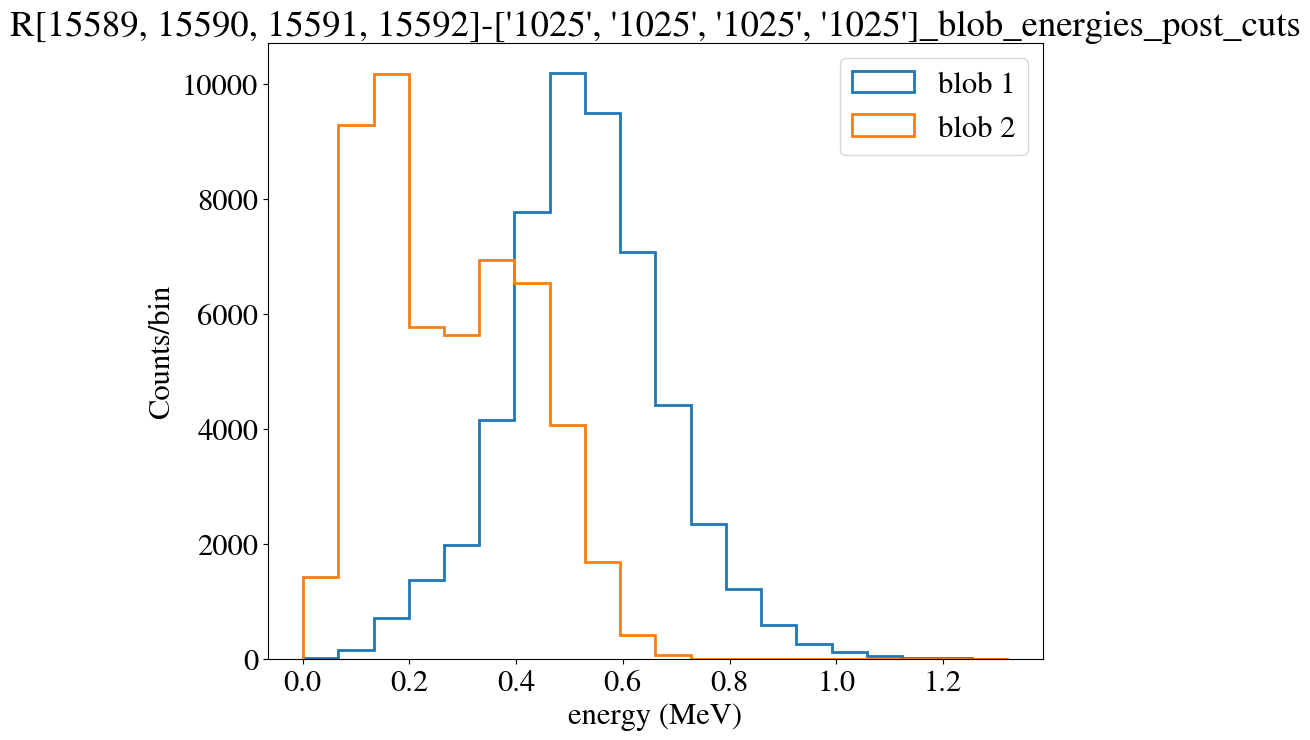

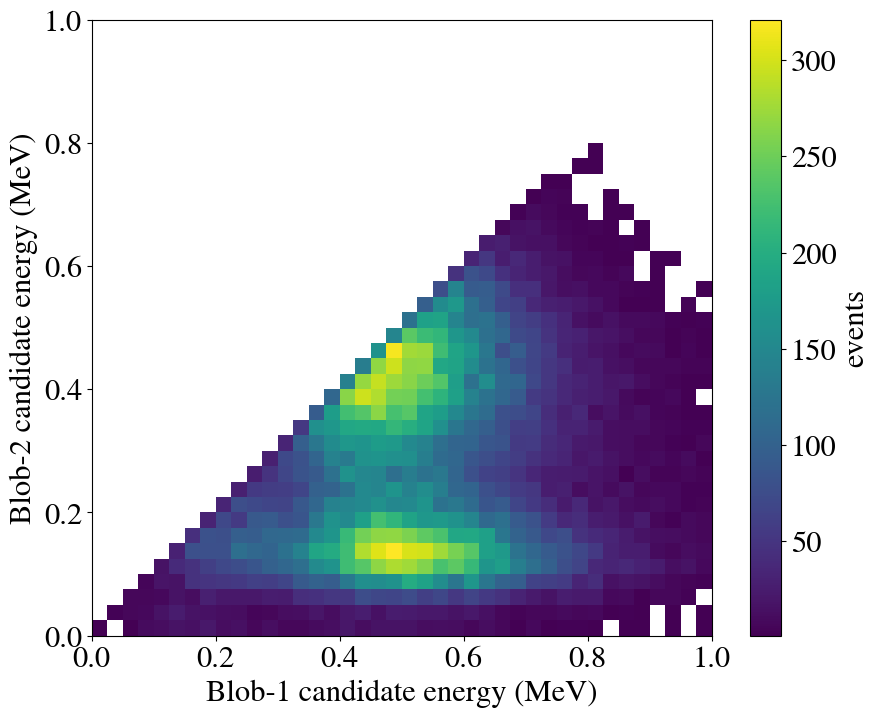

Starting the process...


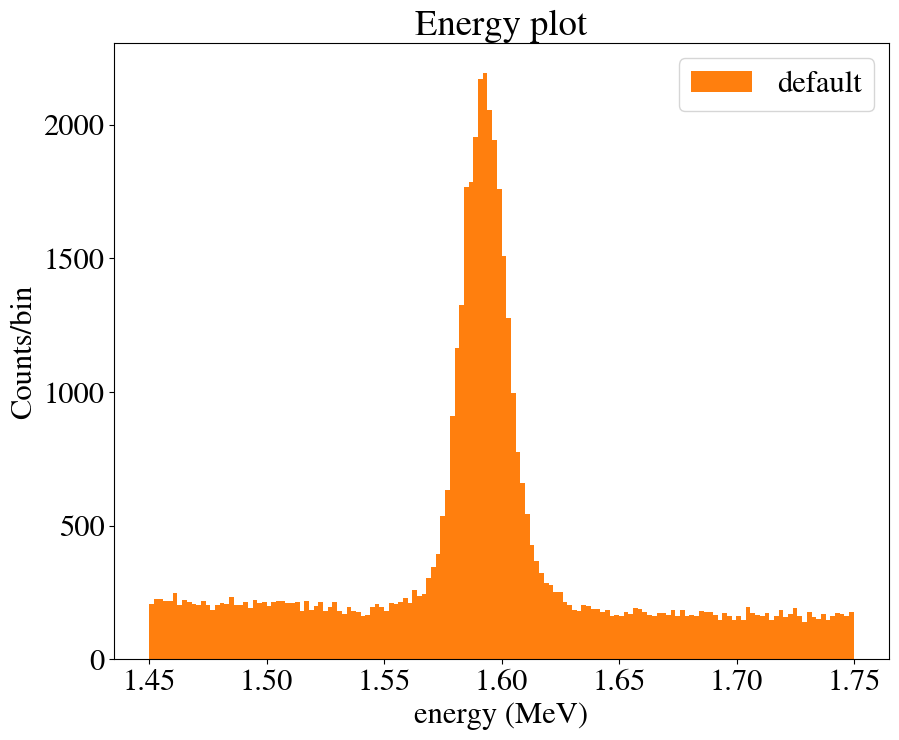

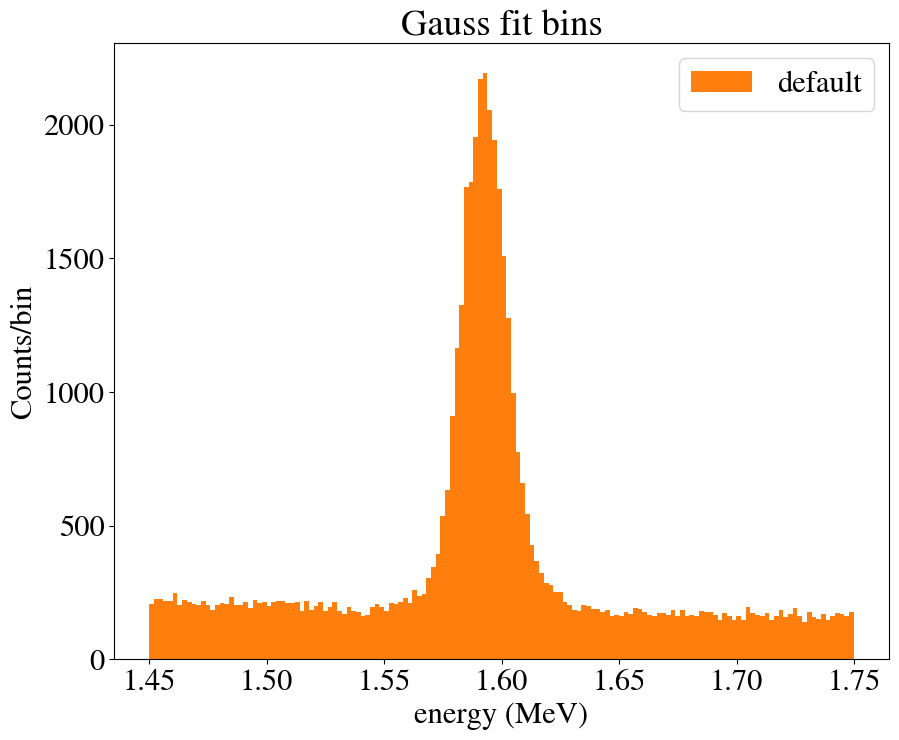

Gaussian fixed at:
mu: 1.5926003629288212
sigma: 0.009595479855785223


Blob cut: 0.0 MeV


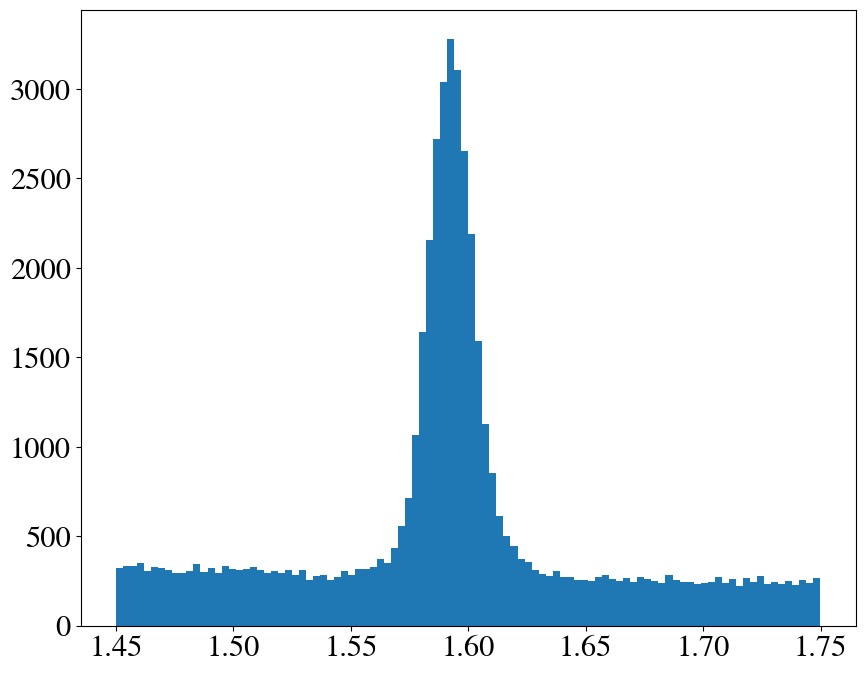

Optimized parameters (popt):
ns: 47.04830828537047
nb: 857.26042120552
tau: 0.9443558859312475

Covariance matrix (pcov):
ns: [0.05260422 0.33367044 0.00082631]
nb: [3.33670439e-01 3.16410254e+04 2.32098612e+01]
tau: [8.26305227e-04 2.32098612e+01 1.70816371e-02]


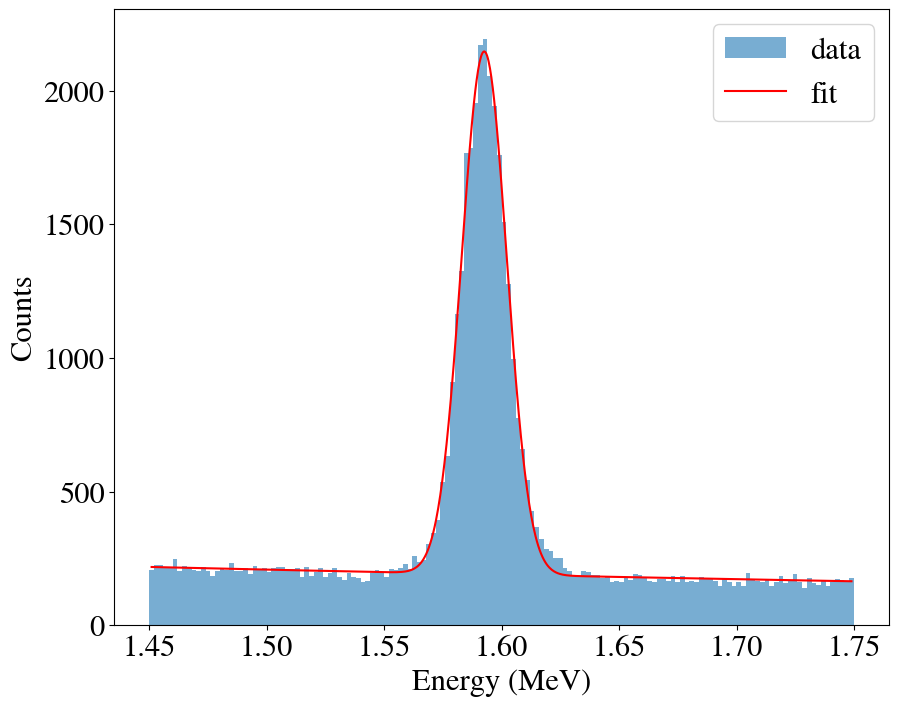

Signal events: 23530.581335177892
Background events: 28474.62798011638
Total Events by addition: 52005.20931529427
Total Events by row counting: 52004
FOM: [1.0]
fom_err: [0.01012695744331514]
ns_l: [23530.581335177892]
nb_l: [28474.62798011638]


Blob cut: 0.01 MeV


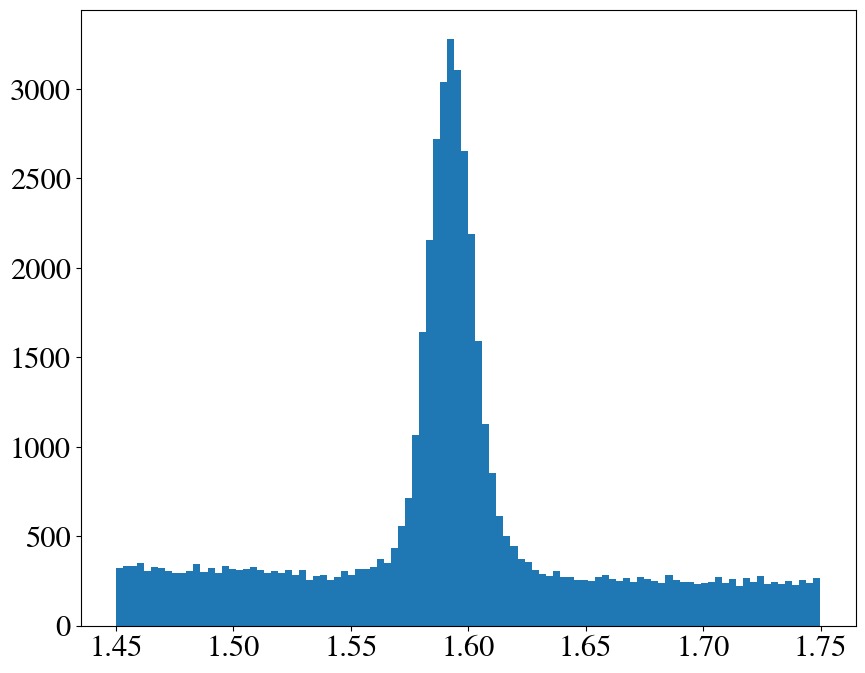

Optimized parameters (popt):
ns: 47.04671055025417
nb: 856.3217579552382
tau: 0.9438269769608838

Covariance matrix (pcov):
ns: [0.05259742 0.33202784 0.00082544]
nb: [3.32027845e-01 3.15837163e+04 2.31930762e+01]
tau: [8.25436692e-04 2.31930762e+01 1.70878903e-02]


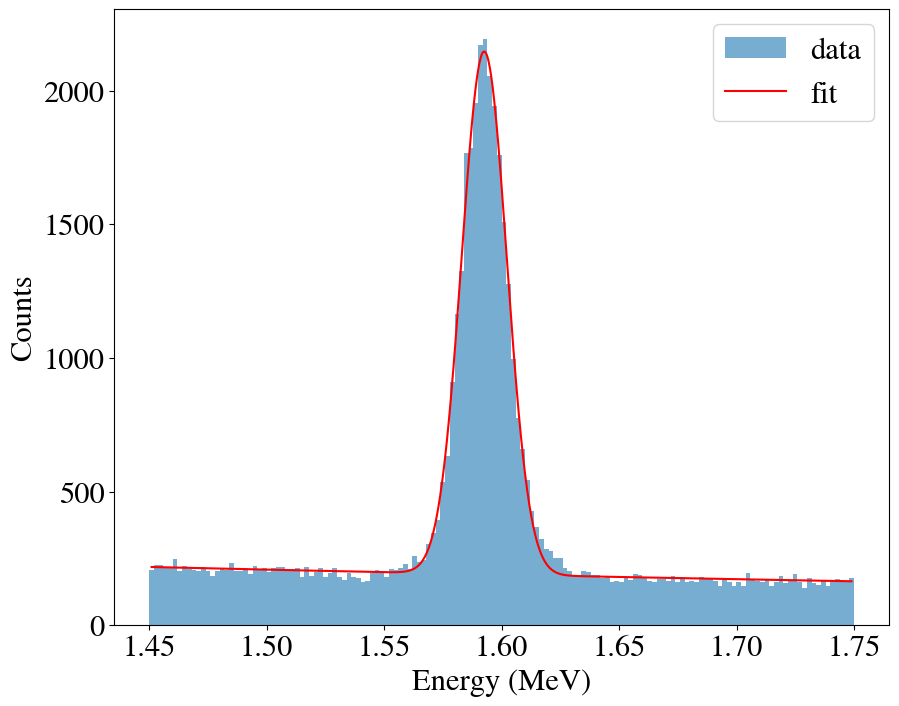

Signal events: 23529.78224935576
Background events: 28467.423324840795
Total Events by addition: 51997.20557419656
Total Events by row counting: 51996
FOM: [1.0, 1.0000925703419226]
fom_err: [0.01012695744331514, 0.010128075880333197]
ns_l: [23530.581335177892, 23529.78224935576]
nb_l: [28474.62798011638, 28467.423324840795]


Blob cut: 0.02 MeV


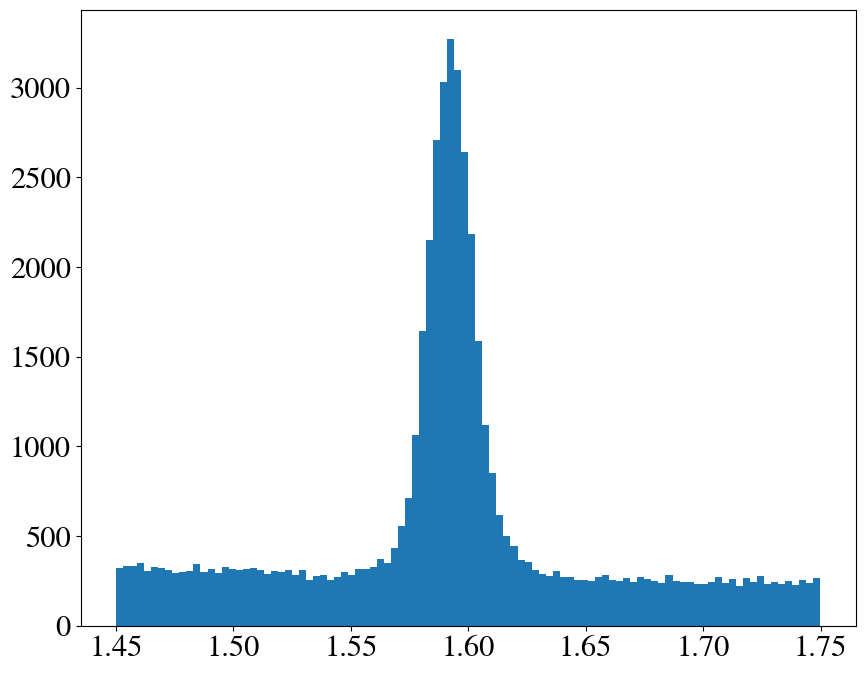

Optimized parameters (popt):
ns: 46.9228561896027
nb: 857.8168297815433
tau: 0.9476653639880221

Covariance matrix (pcov):
ns: [0.05138924 0.33586395 0.00081697]
nb: [3.35863946e-01 3.12379717e+04 2.29000968e+01]
tau: [8.16970242e-04 2.29000968e+01 1.68432804e-02]


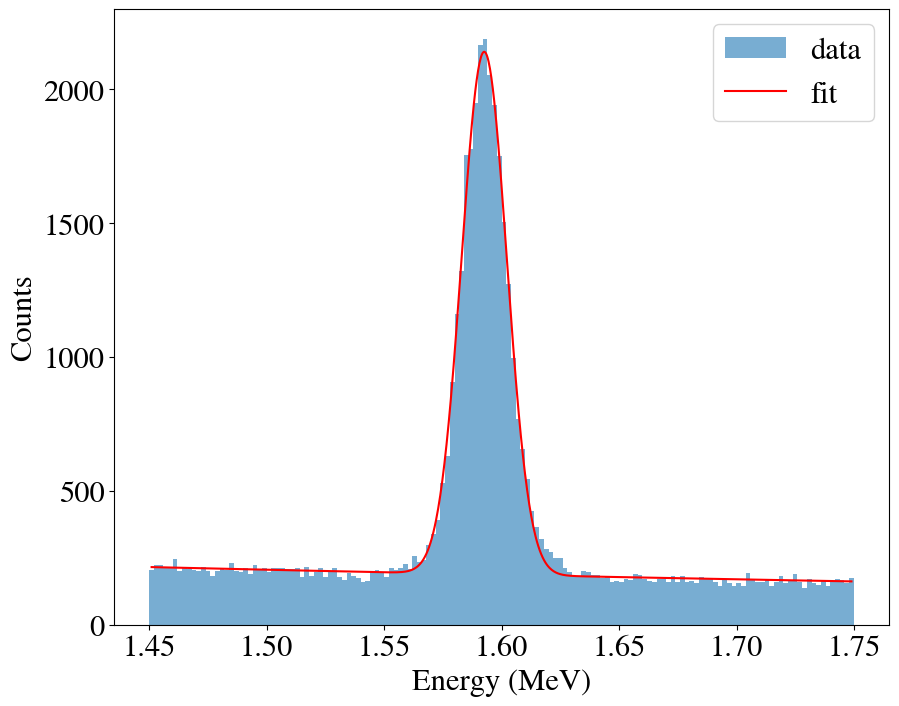

Signal events: 23467.838149488263
Background events: 28343.298939593078
Total Events by addition: 51811.13708908134
Total Events by row counting: 51810
FOM: [1.0, 1.0000925703419226, 0.9996414557226576]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078]


Blob cut: 0.03 MeV


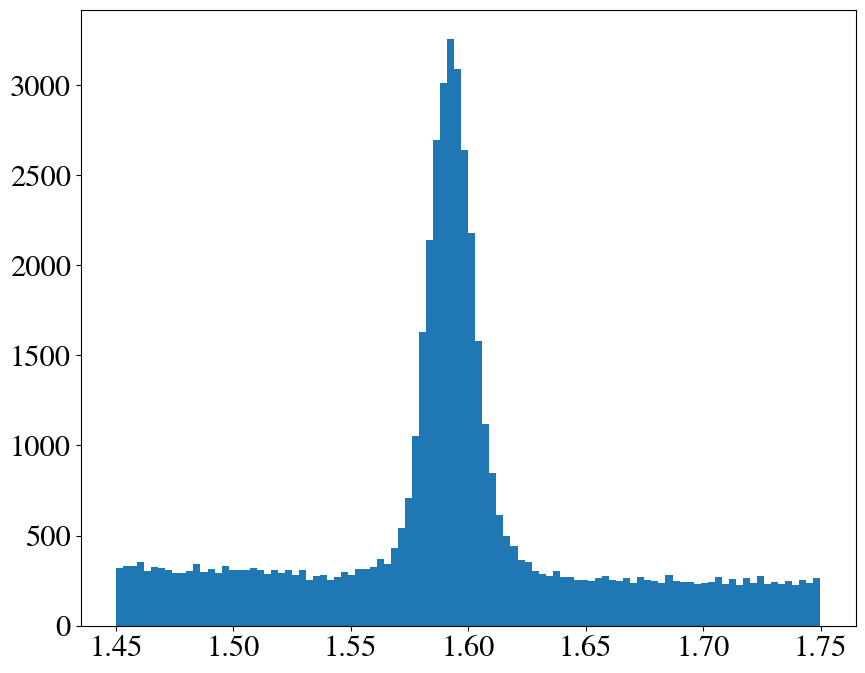

Optimized parameters (popt):
ns: 46.77579014932984
nb: 844.1509648899156
tau: 0.9409257856996793

Covariance matrix (pcov):
ns: [0.05251873 0.32277929 0.00082683]
nb: [3.22779294e-01 3.12466432e+04 2.32755622e+01]
tau: [8.26834661e-04 2.32755622e+01 1.73953044e-02]


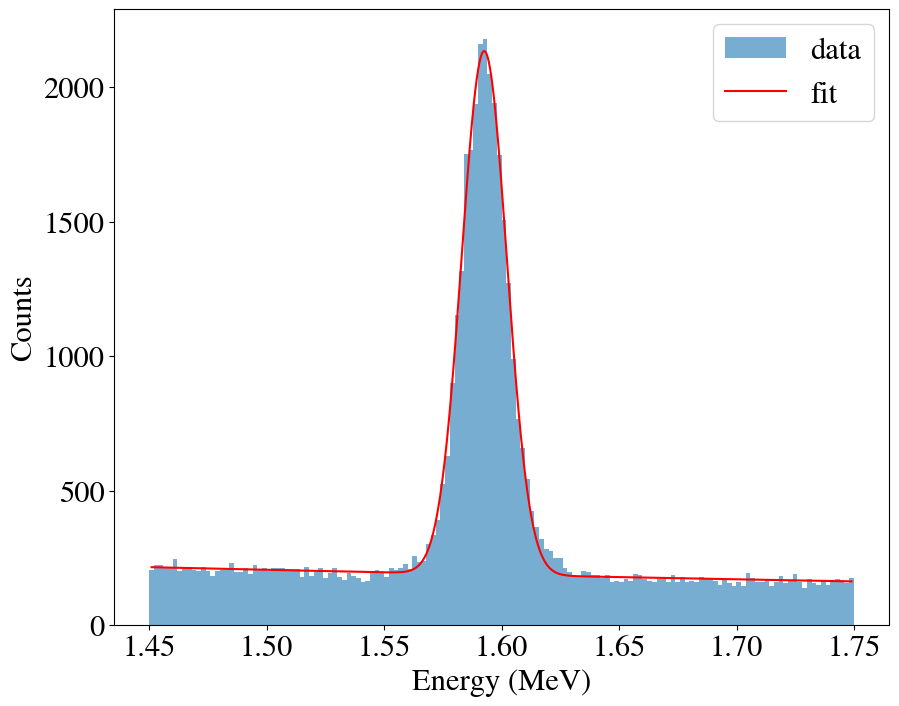

Signal events: 23394.285038900456
Background events: 28192.808380631595
Total Events by addition: 51587.09341953205
Total Events by row counting: 51586
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595]


Blob cut: 0.04 MeV


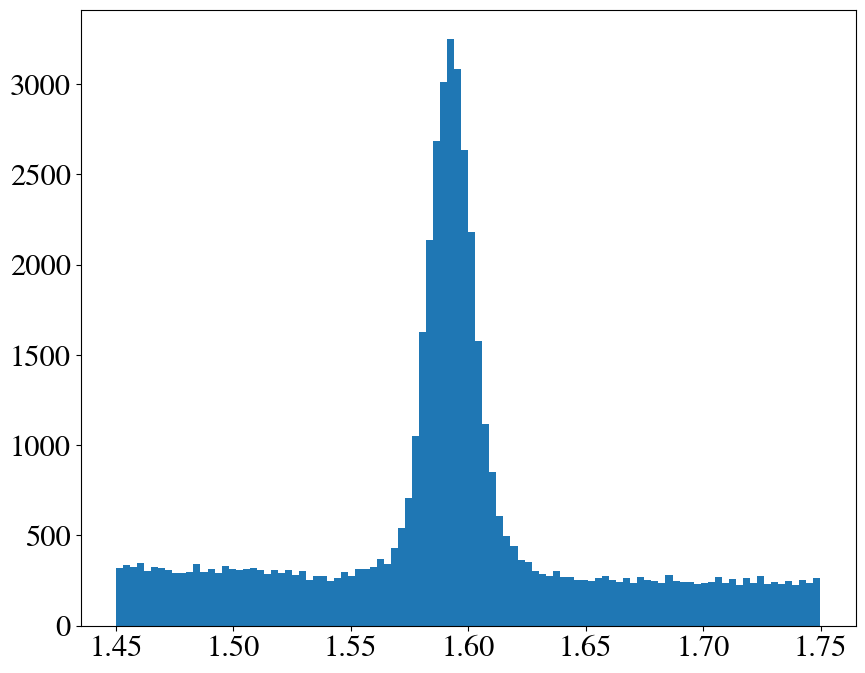

Optimized parameters (popt):
ns: 46.69228090621749
nb: 833.9943513503513
tau: 0.9358311873301732

Covariance matrix (pcov):
ns: [0.05243016 0.30704944 0.00081923]
nb: [3.07049438e-01 3.06918500e+04 2.31394538e+01]
tau: [8.19229743e-04 2.31394538e+01 1.75032343e-02]


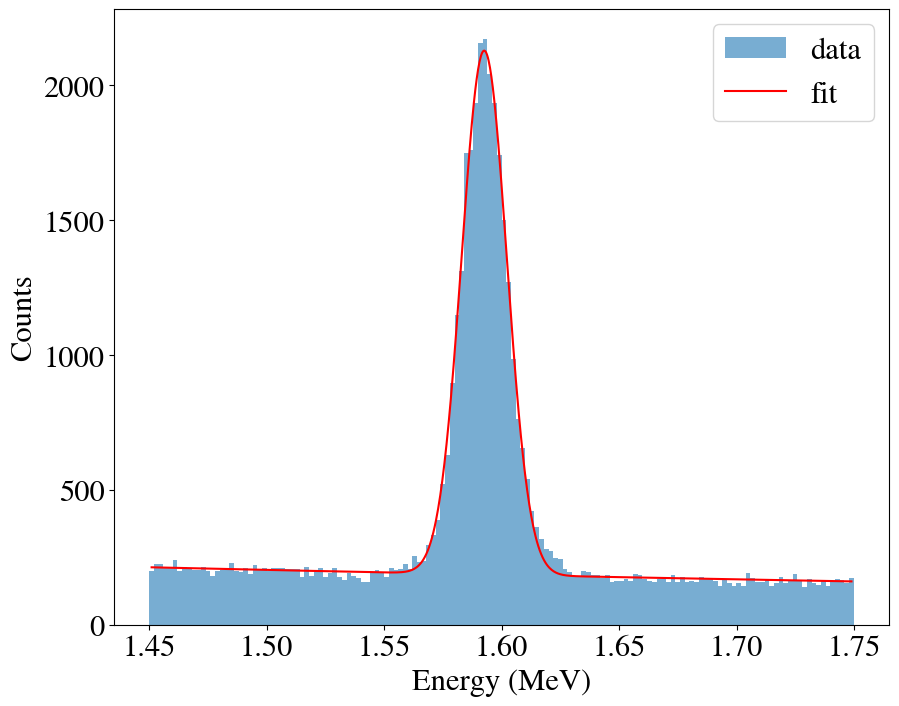

Signal events: 23352.519009283074
Background events: 28080.56394542273
Total Events by addition: 51433.08295470581
Total Events by row counting: 51432
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273]


Blob cut: 0.05 MeV


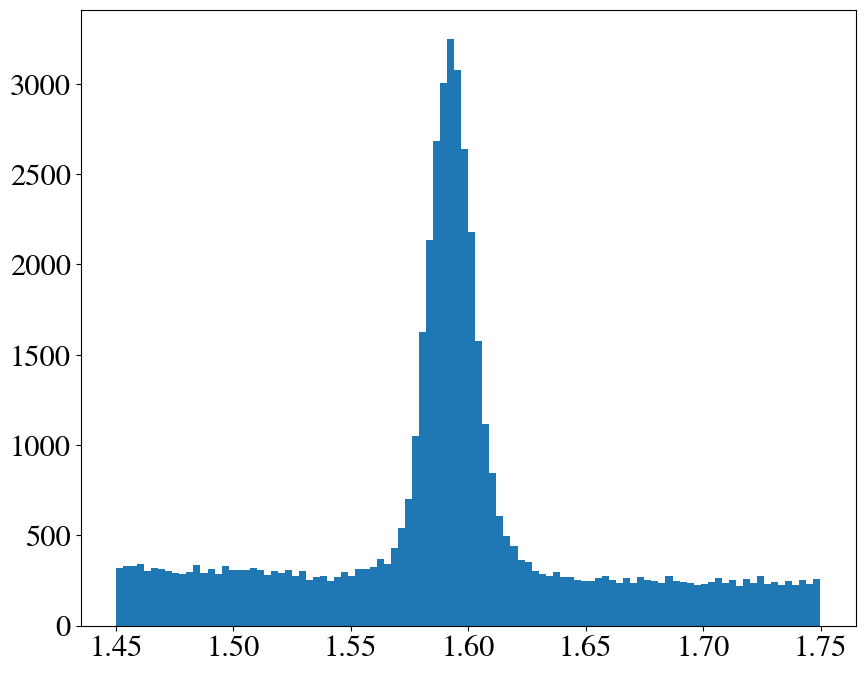

Optimized parameters (popt):
ns: 46.64189335422509
nb: 835.941092826239
tau: 0.9412365086902145

Covariance matrix (pcov):
ns: [0.05304383 0.32695084 0.00084431]
nb: [3.26950841e-01 3.15902132e+04 2.37627073e+01]
tau: [8.44311603e-04 2.37627073e+01 1.79338822e-02]


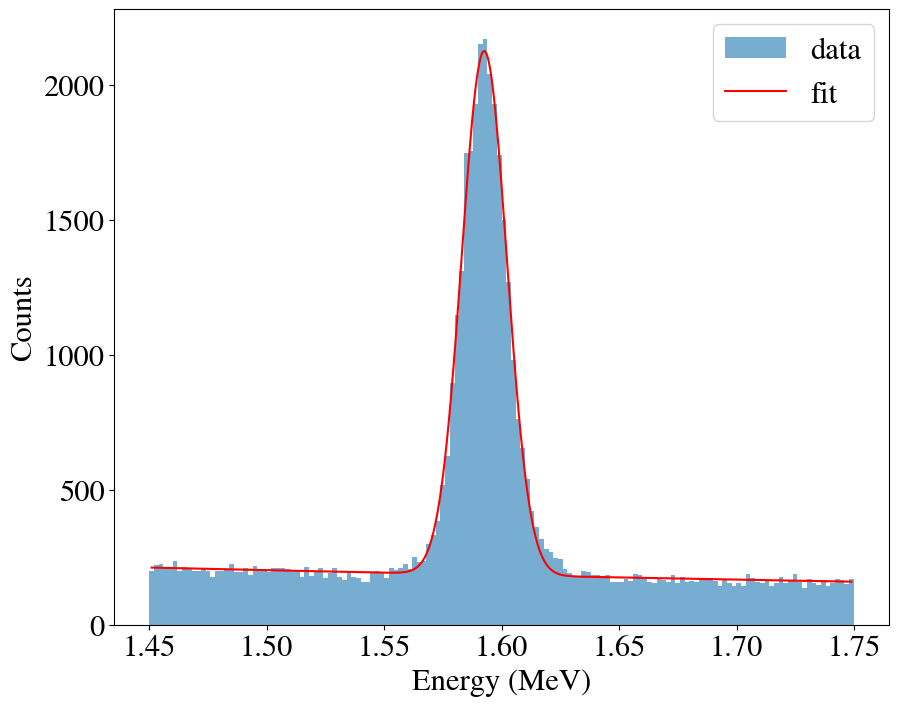

Signal events: 23327.31834992576
Background events: 27904.80128464279
Total Events by addition: 51232.119634568546
Total Events by row counting: 51231
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273, 27904.80128464279]


Blob cut: 0.06 MeV


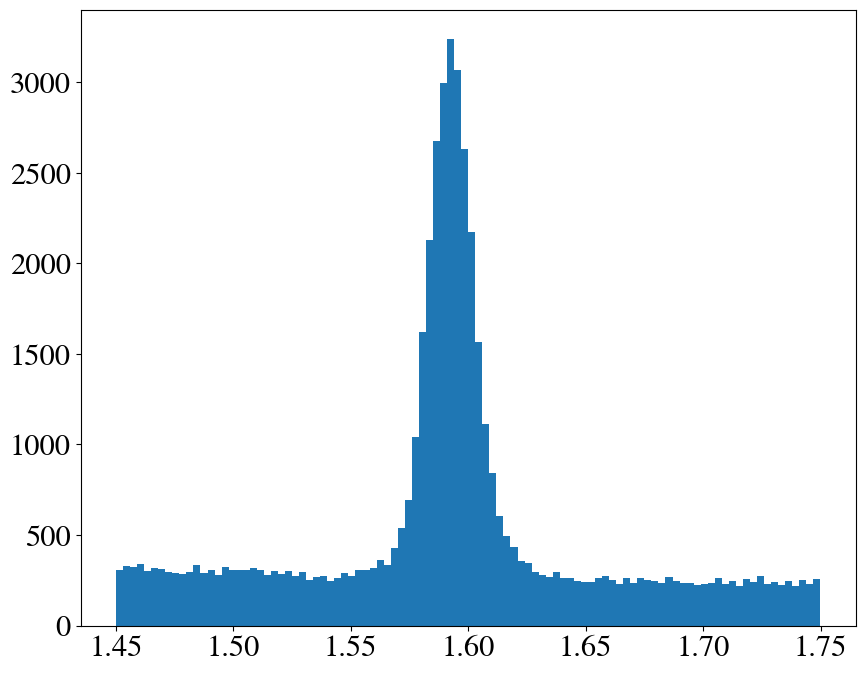

Optimized parameters (popt):
ns: 46.57510799369478
nb: 835.1124304206793
tau: 0.9473465922069552

Covariance matrix (pcov):
ns: [0.05310299 0.346078   0.00086611]
nb: [3.46078002e-01 3.22470604e+04 2.42824184e+01]
tau: [8.66114214e-04 2.42824184e+01 1.83454607e-02]


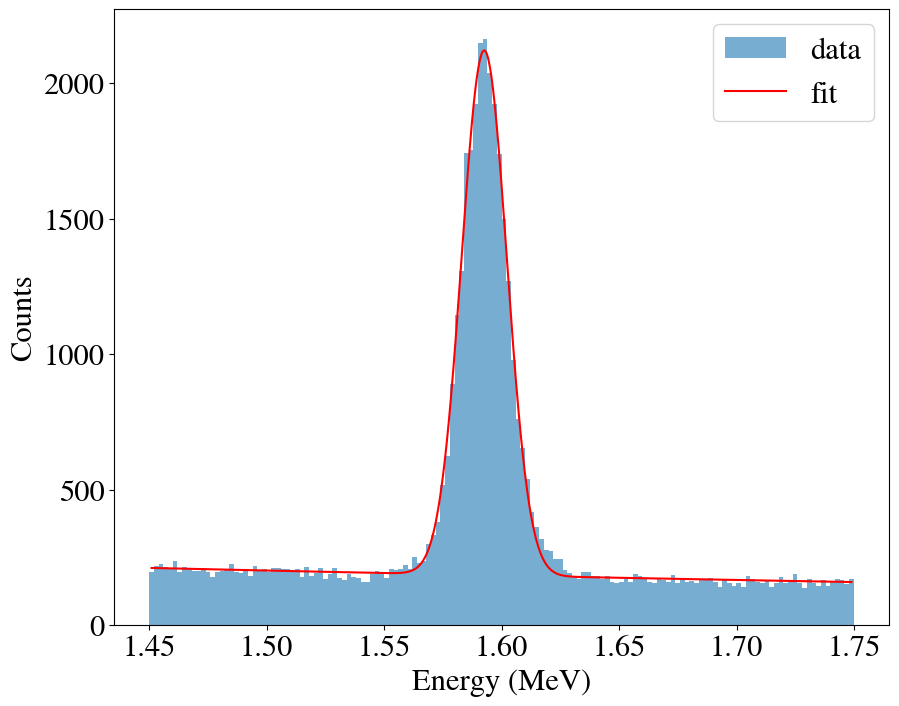

Signal events: 23293.916546221662
Background events: 27607.132726610627
Total Events by addition: 50901.049272832286
Total Events by row counting: 50900
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273, 27904.80128464279, 27607.132726610627]


Blob cut: 0.07 MeV


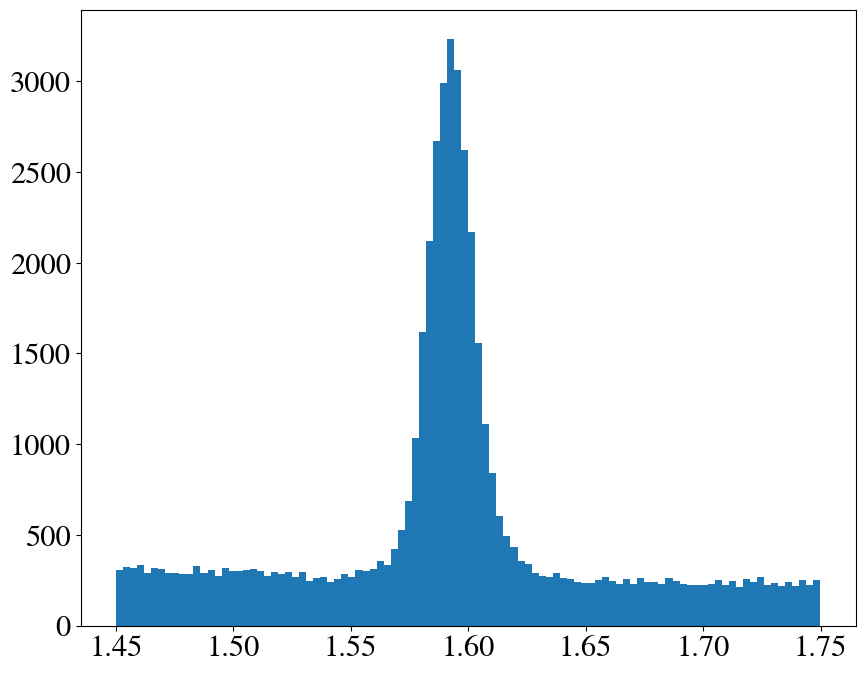

Optimized parameters (popt):
ns: 46.548474967621935
nb: 838.2299775655285
tau: 0.9609223274478507

Covariance matrix (pcov):
ns: [0.05320295 0.38970803 0.00091004]
nb: [3.89708032e-01 3.37354643e+04 2.53123911e+01]
tau: [9.10042161e-04 2.53123911e+01 1.90552291e-02]


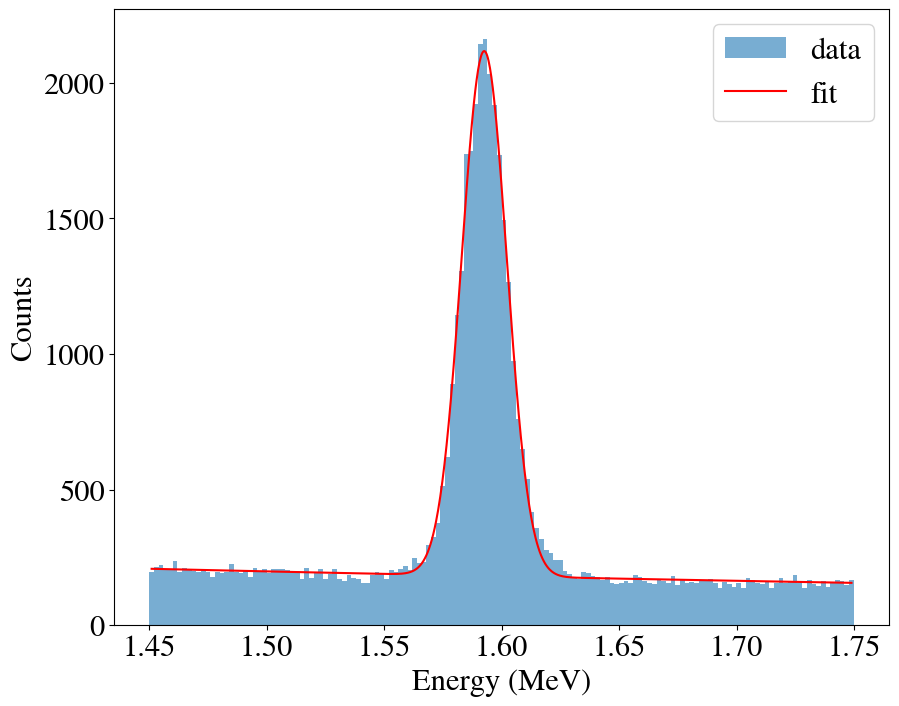

Signal events: 23280.596394891083
Background events: 27117.421849664406
Total Events by addition: 50398.01824455549
Total Events by row counting: 50397
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273, 27904.80128464279, 27607.132726610627, 27117.421849664406]


Blob cut: 0.08 MeV


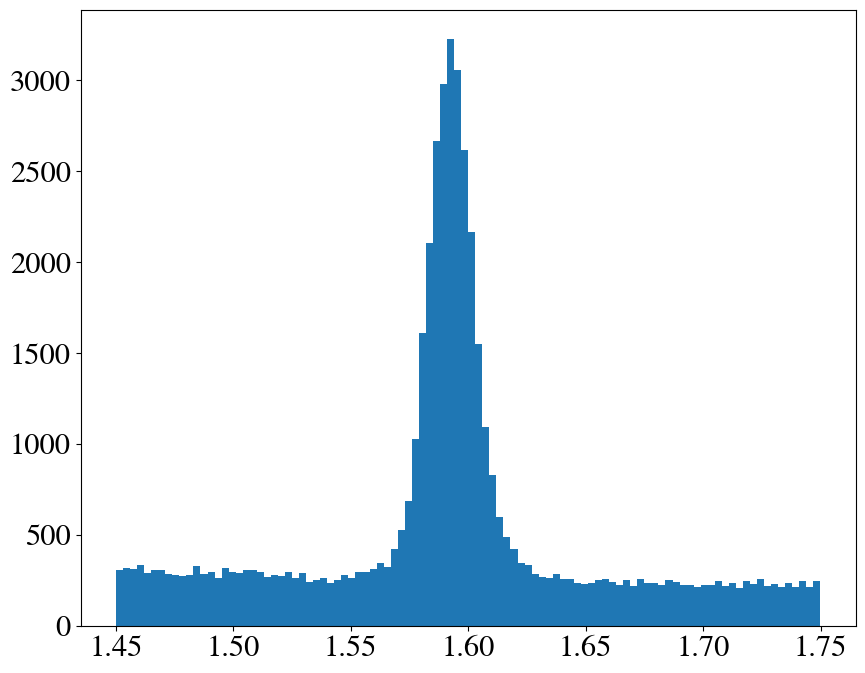

Optimized parameters (popt):
ns: 46.47708722706375
nb: 846.9161855919806
tau: 0.9847244171545197

Covariance matrix (pcov):
ns: [0.05281104 0.46588194 0.00097635]
nb: [4.65881943e-01 3.61284166e+04 2.68358581e+01]
tau: [9.76351739e-04 2.68358581e+01 1.99993516e-02]


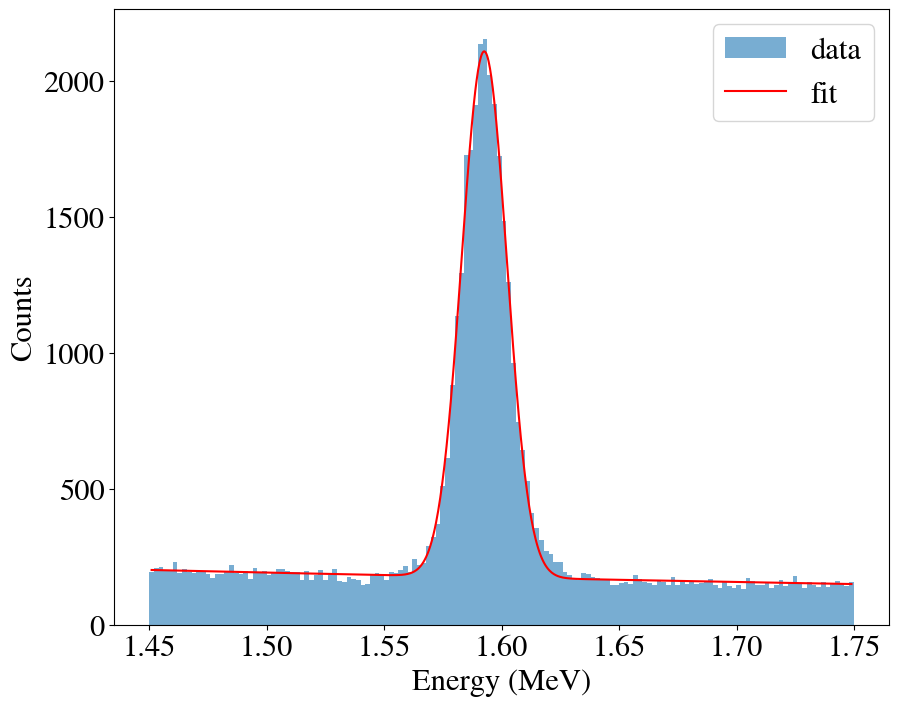

Signal events: 23244.892772449435
Background events: 26379.208327130767
Total Events by addition: 49624.101099580206
Total Events by row counting: 49623
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273, 27904.80128464279, 27607.132726610627, 27117.421849664406, 26379.208327130767]


Blob cut: 0.09 MeV


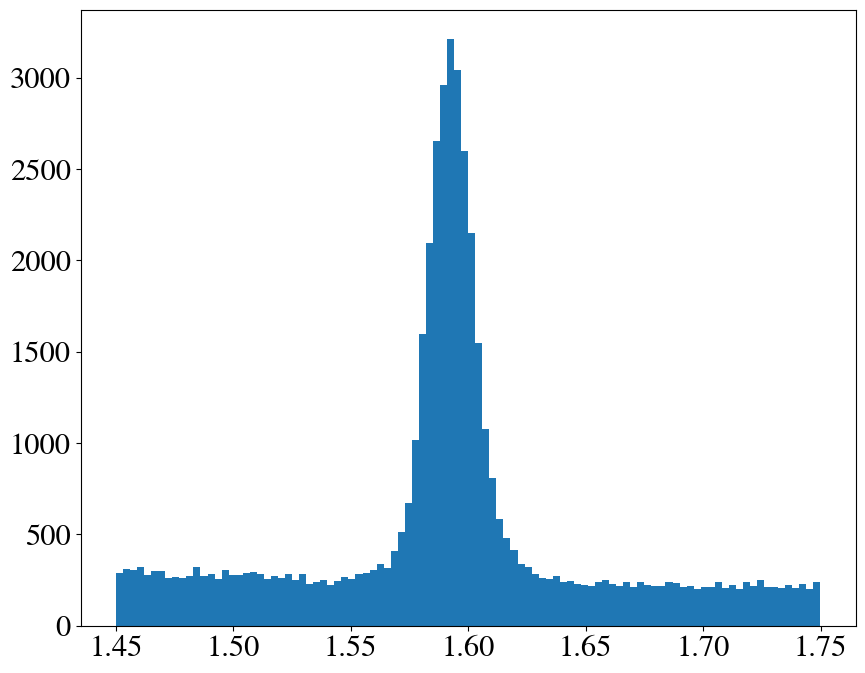

Optimized parameters (popt):
ns: 46.43700832619783
nb: 846.526907749536
tau: 1.0086755576090196

Covariance matrix (pcov):
ns: [0.05300648 0.55289584 0.00106855]
nb: [5.52895837e-01 3.91362165e+04 2.90912521e+01]
tau: [1.06854938e-03 2.90912521e+01 2.16959748e-02]


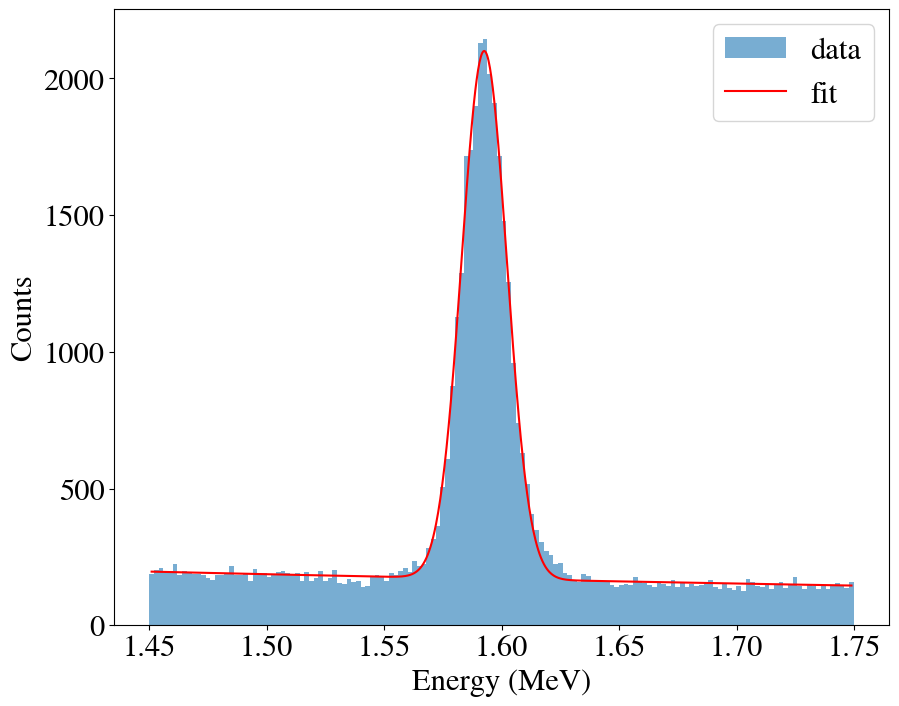

Signal events: 23224.84784690334
Background events: 25380.312398812388
Total Events by addition: 48605.16024571573
Total Events by row counting: 48604
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435, 23224.84784690334]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273, 27904.80128464279, 27607.132726610627, 27117.421849664406, 26379.208327130767, 25380.312398812388]


Blob cut: 0.1 MeV


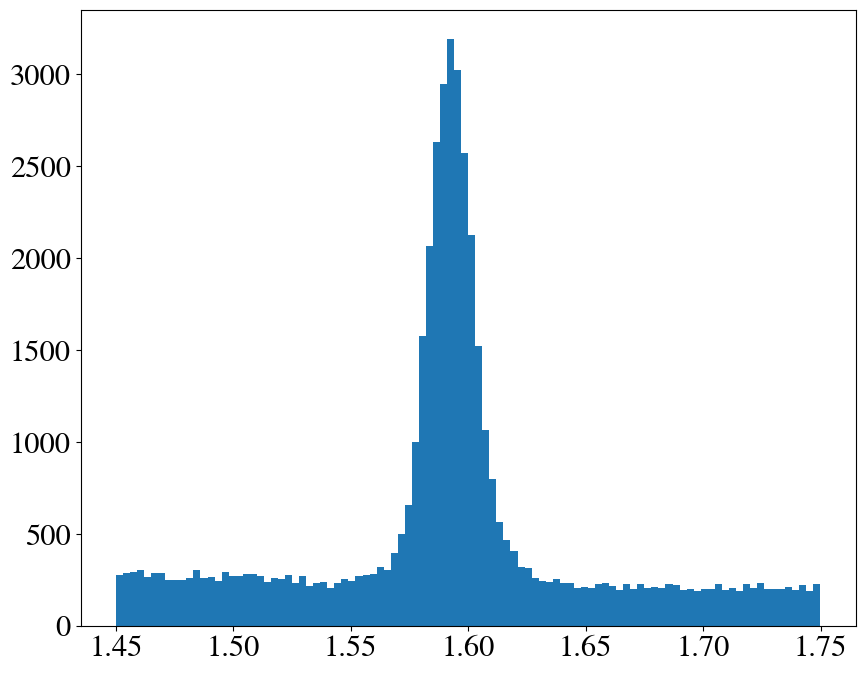

Optimized parameters (popt):
ns: 46.30107854952358
nb: 861.2908329883237
tau: 1.0536804455542026

Covariance matrix (pcov):
ns: [0.05170923 0.71169917 0.00119756]
nb: [7.11699175e-01 4.40665520e+04 3.22099375e+01]
tau: [1.19756382e-03 3.22099375e+01 2.36212278e-02]


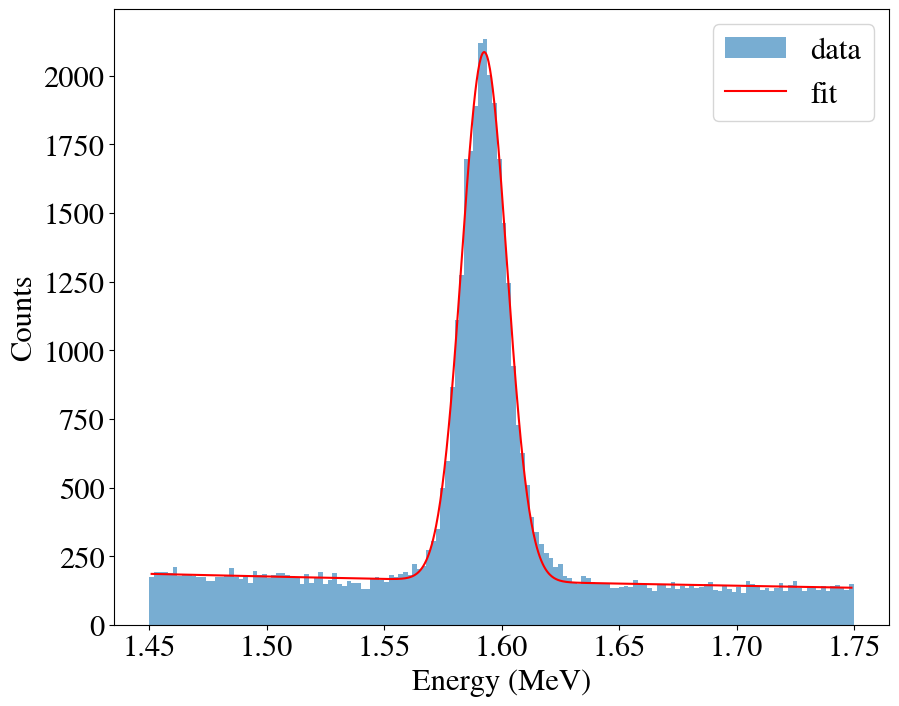

Signal events: 23156.864389421607
Background events: 24037.24509493717
Total Events by addition: 47194.10948435878
Total Events by row counting: 47193
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435, 23224.84784690334, 23156.864389421607]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273, 27904.80128464279, 27607.132726610627, 27117.421849664406, 26379.2

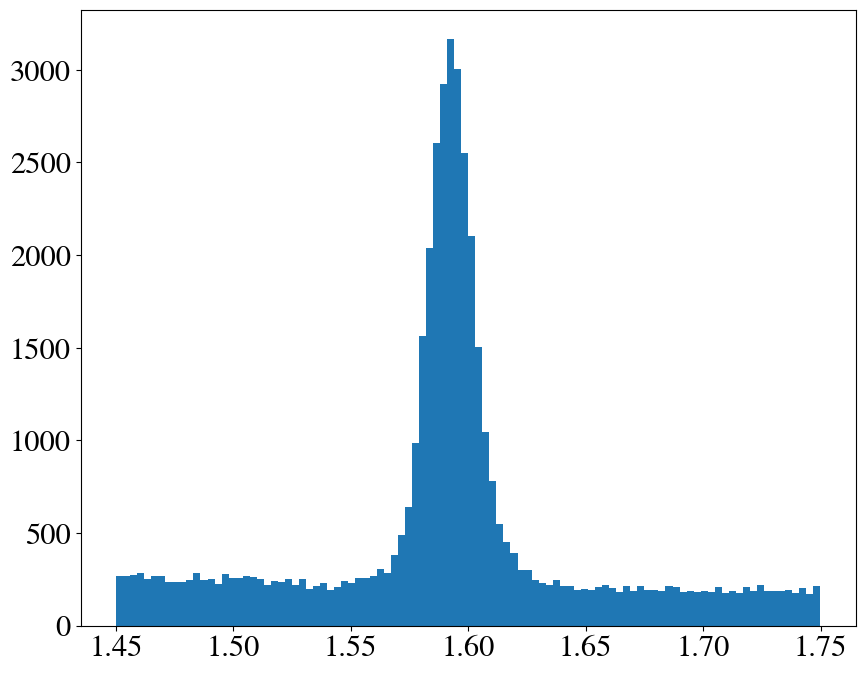

Optimized parameters (popt):
ns: 46.14572324965658
nb: 887.3315063079748
tau: 1.1131761171261425

Covariance matrix (pcov):
ns: [0.05096383 0.96053333 0.00139428]
nb: [9.60533333e-01 5.24984497e+04 3.72708398e+01]
tau: [1.39428264e-03 3.72708398e+01 2.65473754e-02]


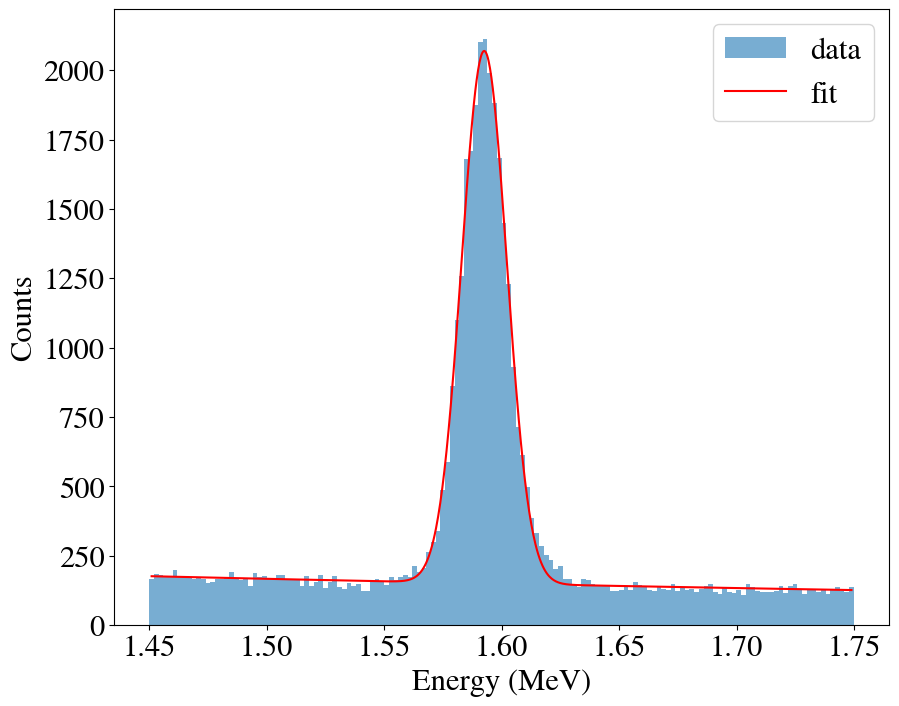

Signal events: 23079.16551665452
Background events: 22526.254548494086
Total Events by addition: 45605.4200651486
Total Events by row counting: 45604
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435, 23224.84784690334, 23156.864389421607, 23079.16551665452]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298939593078, 28192.808380631595, 28080.56394542273, 27904.

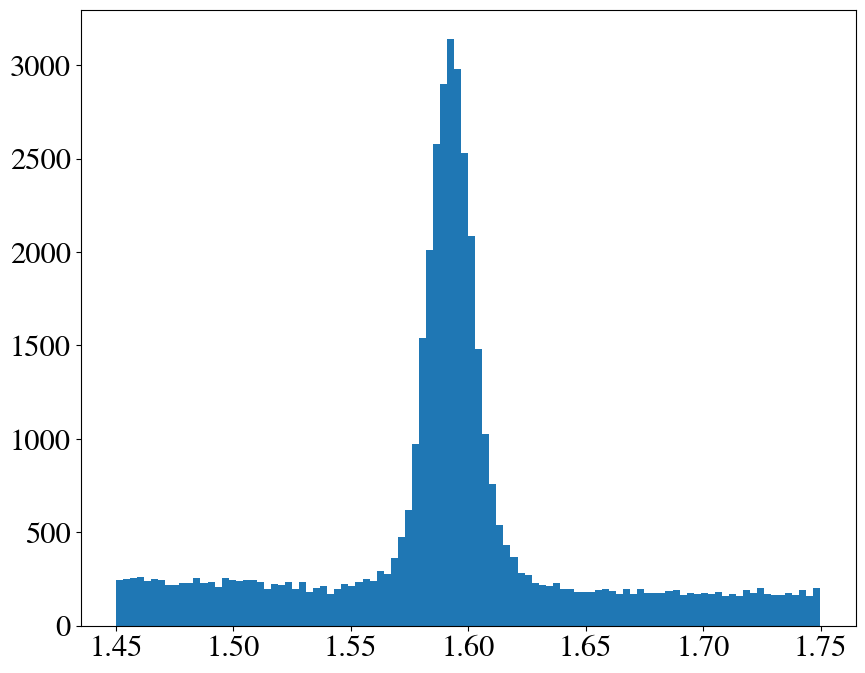

Optimized parameters (popt):
ns: 46.00980059324737
nb: 851.7581745975149
tau: 1.1384268057968763

Covariance matrix (pcov):
ns: [0.04787206 1.01788451 0.00147867]
nb: [1.01788451e+00 5.34468076e+04 3.95393640e+01]
tau: [1.47866630e-03 3.95393640e+01 2.93471786e-02]


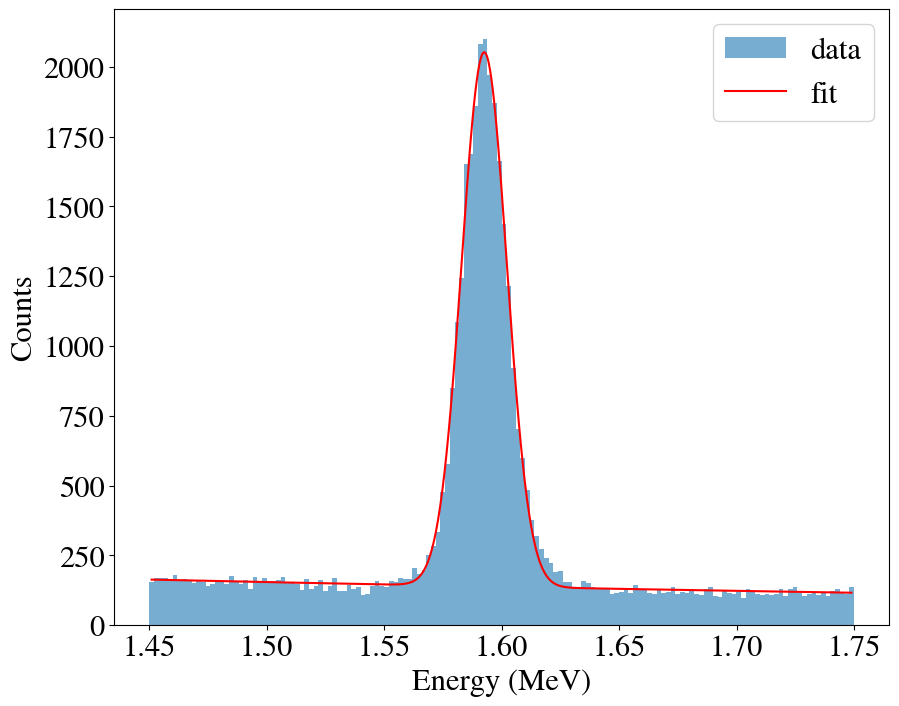

Signal events: 23011.185620278
Background events: 20771.412470981253
Total Events by addition: 43782.59809125925
Total Events by row counting: 43781
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435, 23224.84784690334, 23156.864389421607, 23079.16551665452, 23011.185620278]
nb_l: [28474.62798011638, 28467.423324840795, 28343.298

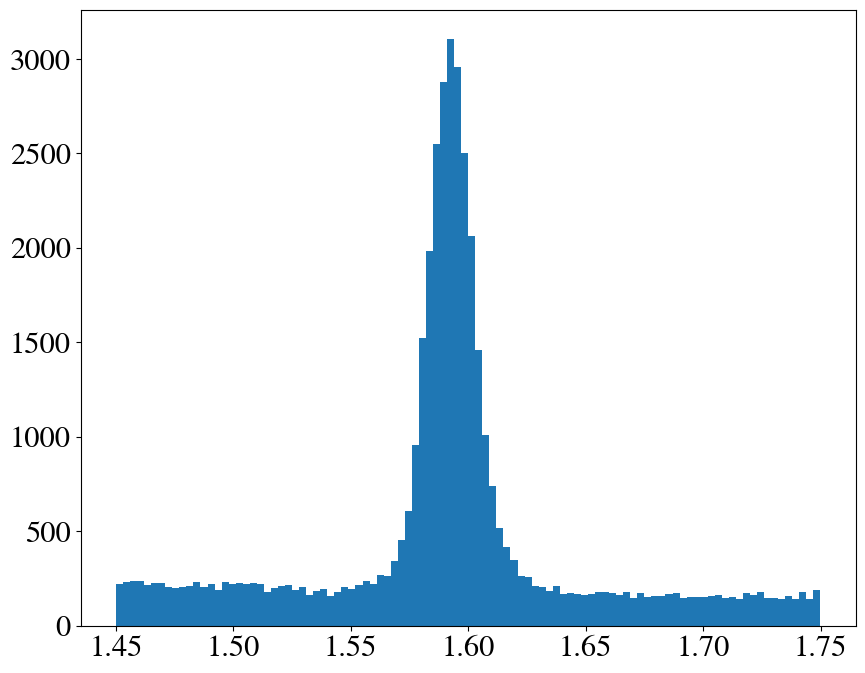

Optimized parameters (popt):
ns: 45.85160079465312
nb: 898.3161205913271
tau: 1.229848494855529

Covariance matrix (pcov):
ns: [0.04422237 1.39160038 0.00171198]
nb: [1.39160038e+00 6.60772837e+04 4.63953735e+01]
tau: [1.71197965e-03 4.63953735e+01 3.26830192e-02]


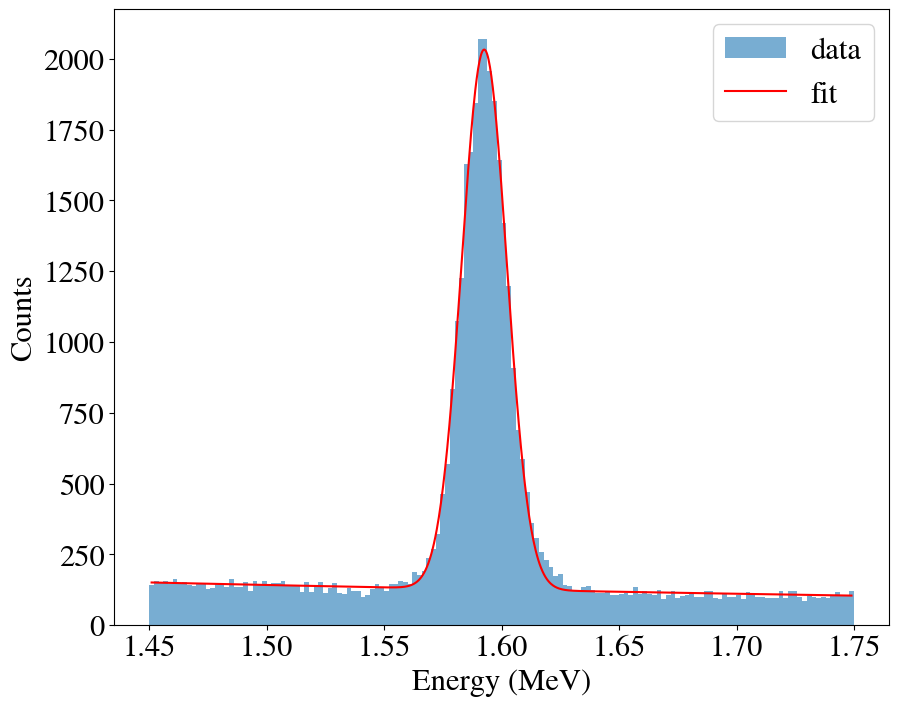

Signal events: 22932.064109564973
Background events: 18941.09900358501
Total Events by addition: 41873.16311314999
Total Events by row counting: 41871
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435, 23224.84784690334, 23156.864389421607, 23079.16551665452, 23011.185620278, 22932.064109

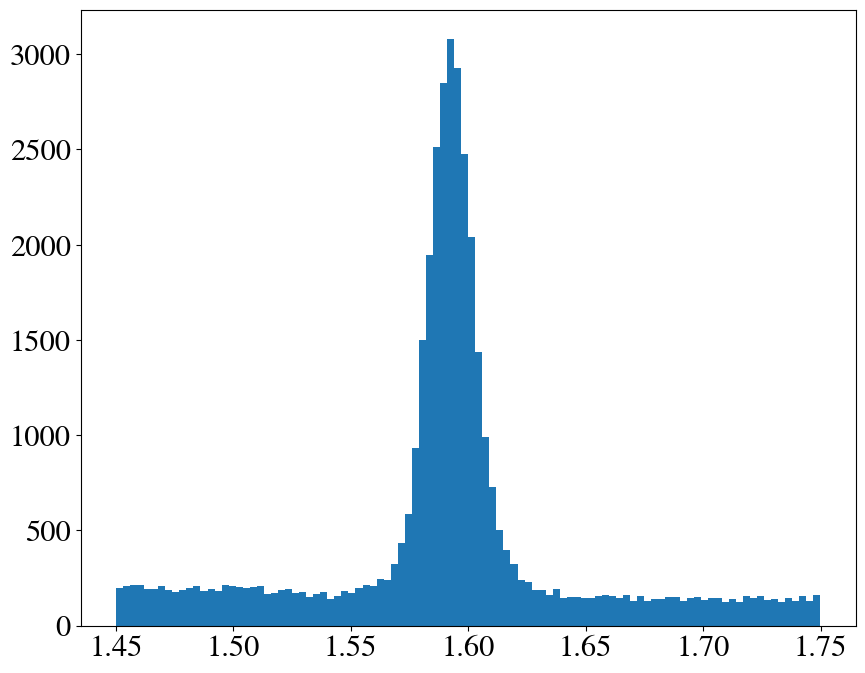

Optimized parameters (popt):
ns: 45.68354628988496
nb: 857.1081776961275
tau: 1.2652684479943221

Covariance matrix (pcov):
ns: [0.04245621 1.53322275 0.00191088]
nb: [1.53322275e+00 7.10266443e+04 5.22871643e+01]
tau: [1.91087922e-03 5.22871643e+01 3.86182223e-02]


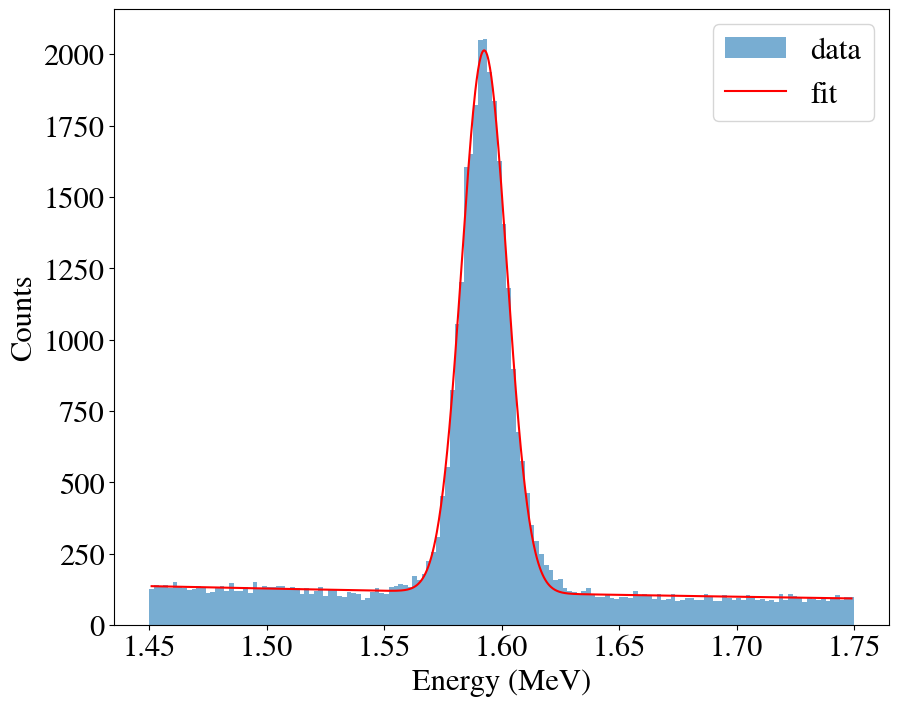

Signal events: 22848.01389952969
Background events: 17082.175250740336
Total Events by addition: 39930.18915027003
Total Events by row counting: 39928
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435, 23224.84784690334, 23156.864389421607, 23079.

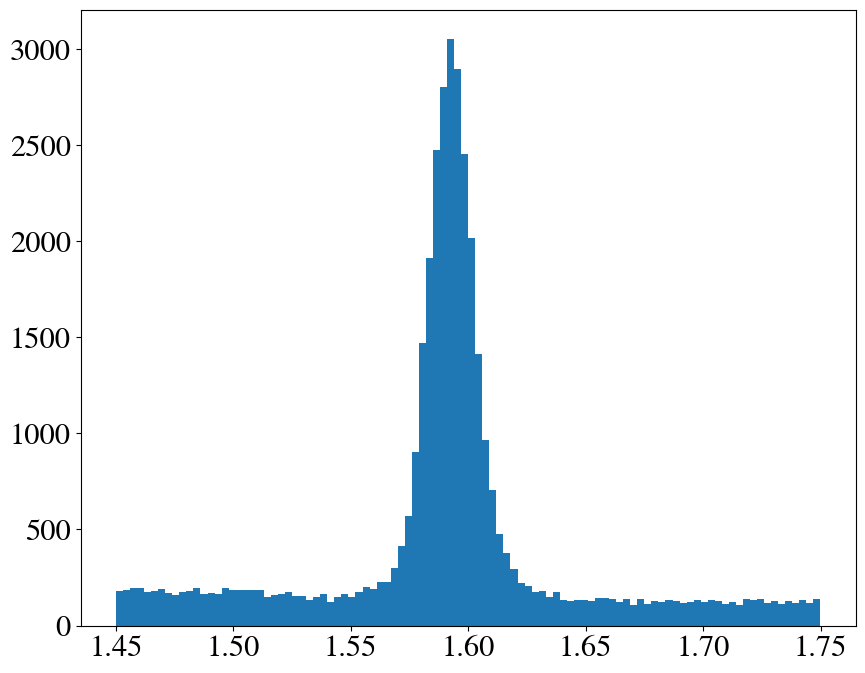

Optimized parameters (popt):
ns: 45.420050007762335
nb: 884.3784276949128
tau: 1.3504432472872718

Covariance matrix (pcov):
ns: [0.0394026  1.93554717 0.00218721]
nb: [1.93554717e+00 8.65052190e+04 6.17698307e+01]
tau: [2.18720815e-03 6.17698307e+01 4.42516756e-02]


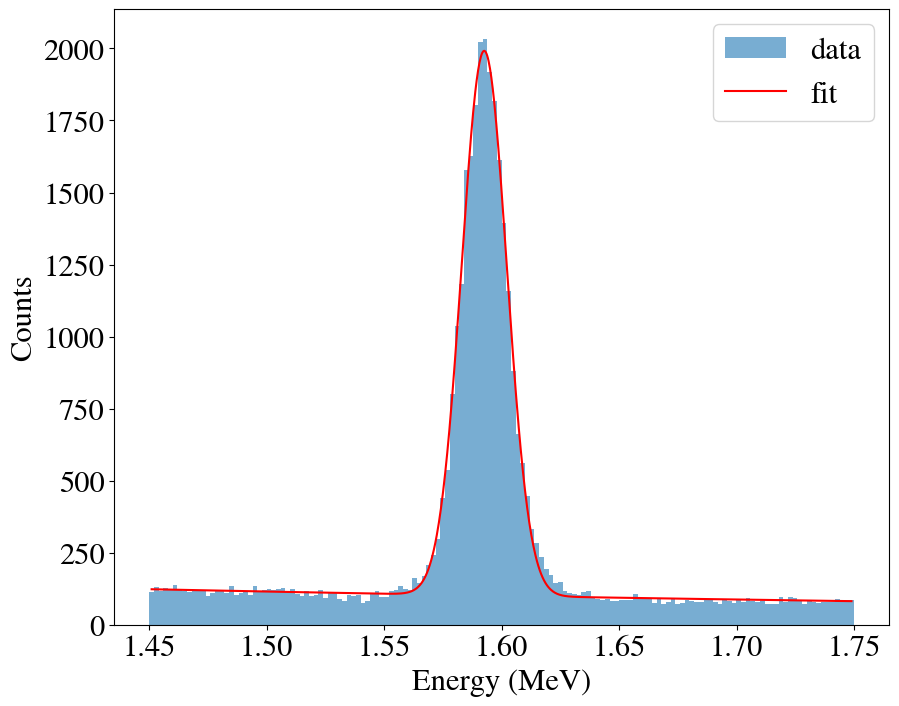

Signal events: 22716.22976267197
Background events: 15392.979660967918
Total Events by addition: 38109.209423639884
Total Events by row counting: 38107
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 23280.596394891083, 23244.892772449435, 23

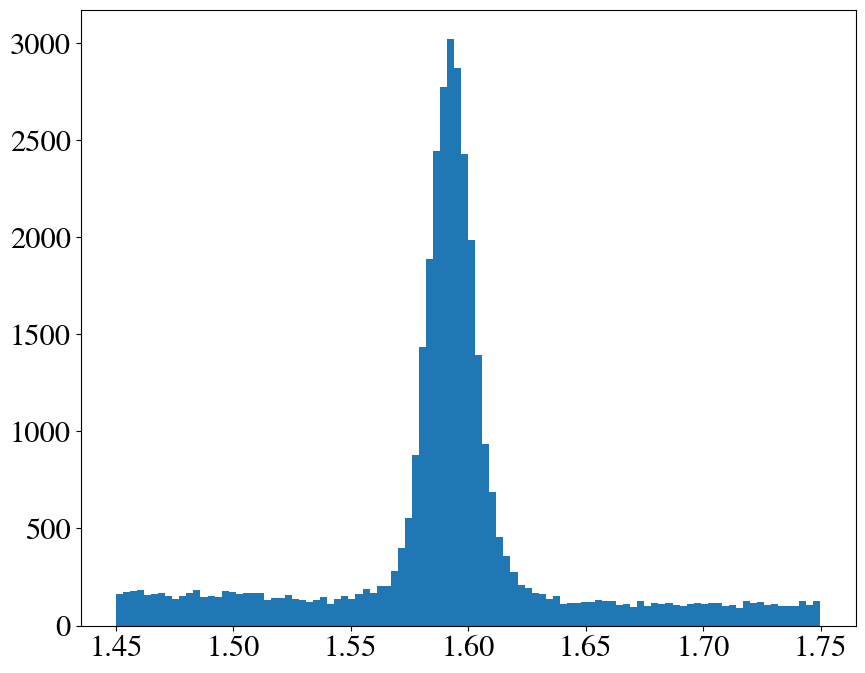

Optimized parameters (popt):
ns: 45.13843889837761
nb: 899.9104058800723
tau: 1.429253856215832

Covariance matrix (pcov):
ns: [0.03764101 2.40195713 0.00254313]
nb: [2.40195713e+00 1.06241604e+05 7.46204587e+01]
tau: [2.54313317e-03 7.46204587e+01 5.25818839e-02]


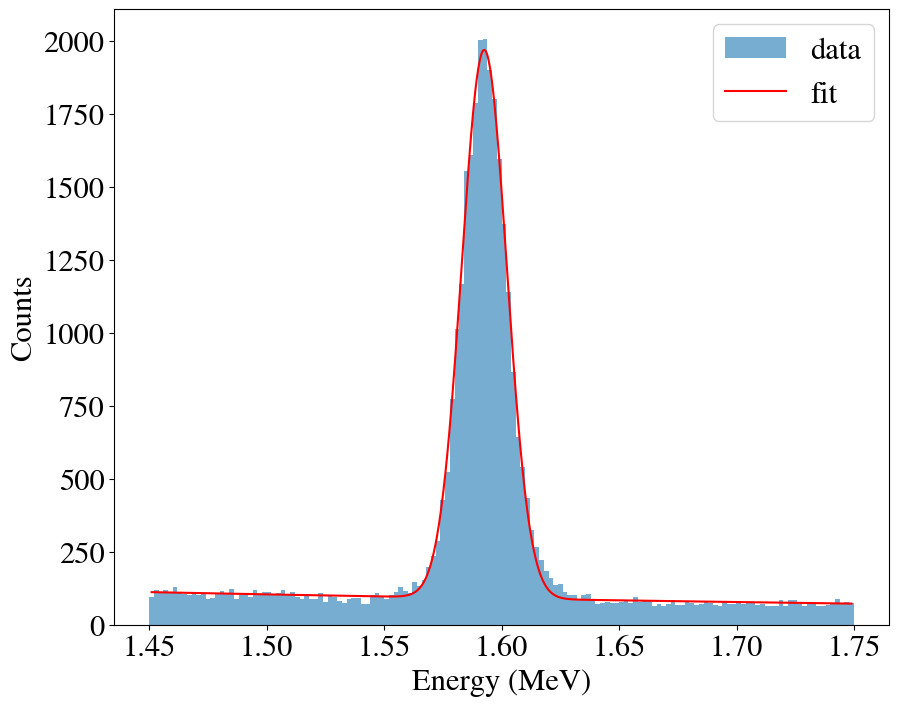

Signal events: 22575.385737546254
Background events: 13819.00961388093
Total Events by addition: 36394.395351427185
Total Events by row counting: 36392
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074, 23327.31834992576, 23293.916546221662, 2

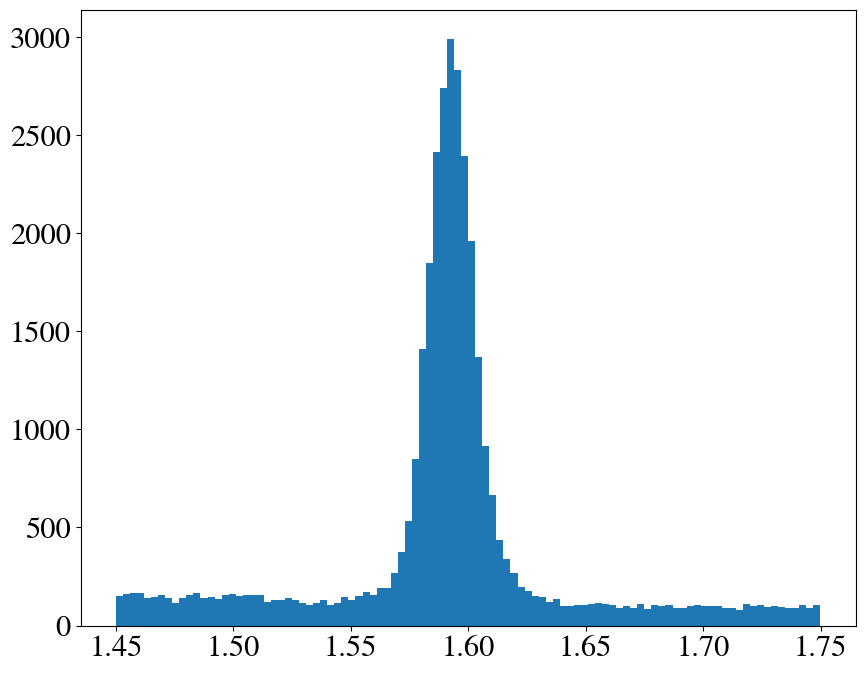

Optimized parameters (popt):
ns: 44.75531901739021
nb: 1051.943862074457
tau: 1.5945817544892695

Covariance matrix (pcov):
ns: [3.77638544e-02 3.97228474e+00 3.34445024e-03]
nb: [3.97228474e+00 1.80626113e+05 1.08724981e+02]
tau: [3.34445024e-03 1.08724981e+02 6.56572751e-02]


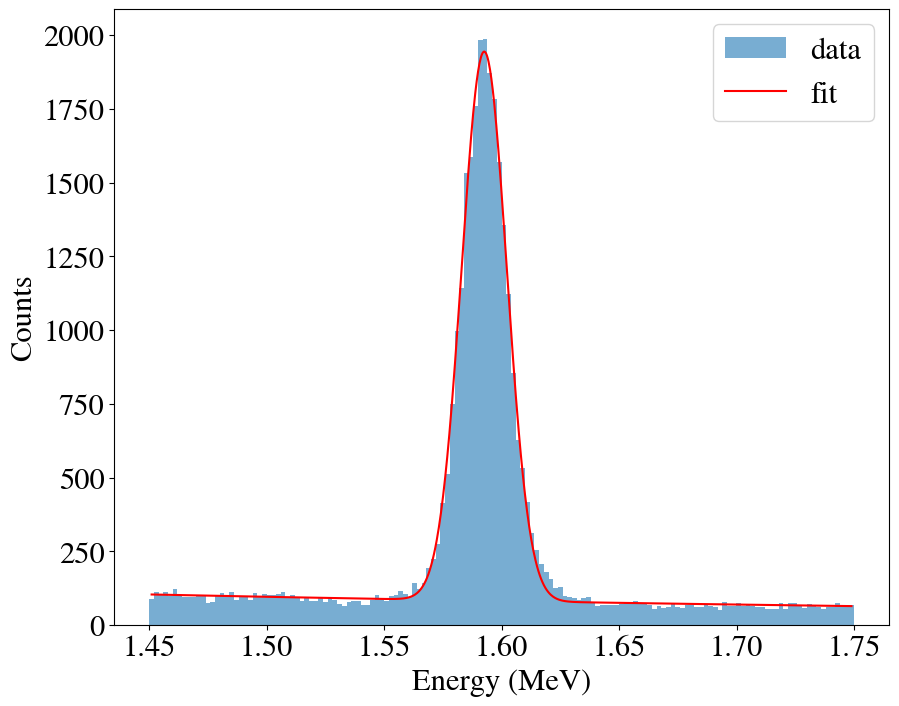

Signal events: 22383.77345967184
Background events: 12422.275514713738
Total Events by addition: 34806.04897438558
Total Events by row counting: 34803
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956, 0.015516866960953281]
ns_l: [23530.581335177892, 23529.78224935576, 23467.838149488263, 23394.285038900456, 23352.519009283074,

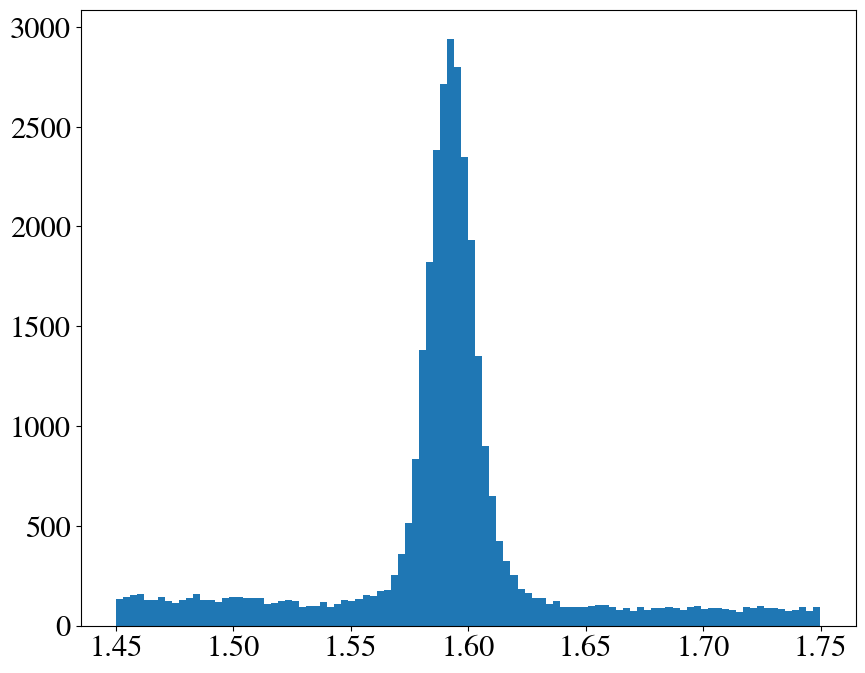

Optimized parameters (popt):
ns: 44.342910283946146
nb: 1090.9641628799302
tau: 1.6836636909719223

Covariance matrix (pcov):
ns: [3.56949465e-02 4.81919165e+00 3.79870502e-03]
nb: [4.81919165e+00 2.26982314e+05 1.31841805e+02]
tau: [3.79870502e-03 1.31841805e+02 7.68268056e-02]


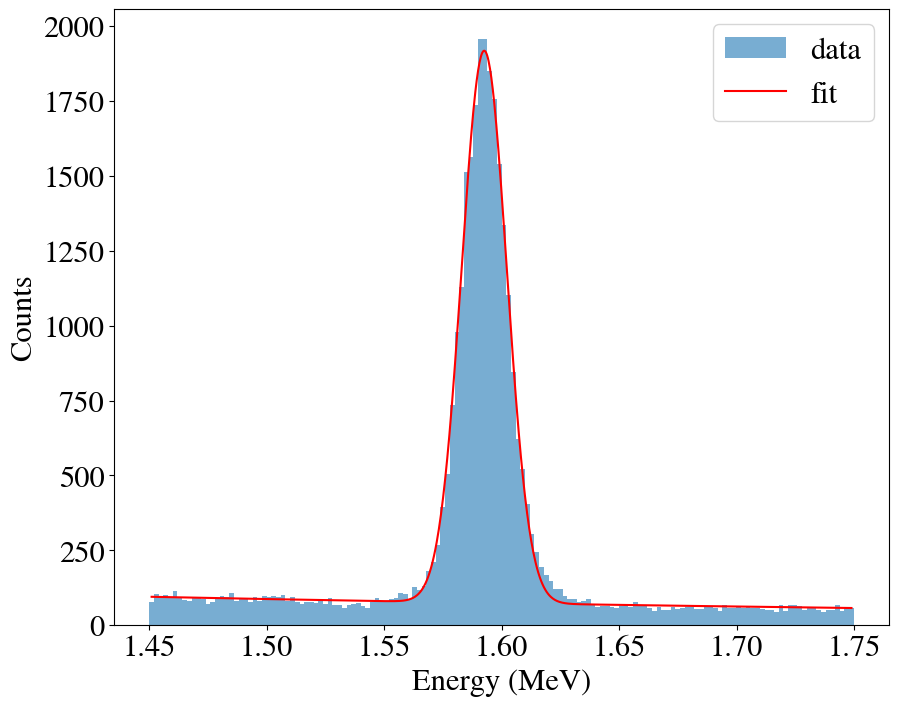

Signal events: 22177.512754466832
Background events: 11183.890446666299
Total Events by addition: 33361.40320113313
Total Events by row counting: 33358
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956, 0.015516866960953281, 0.01638619953076272]
ns_l: [23530.581335177892, 23529.78224935576, 23467.83814948826

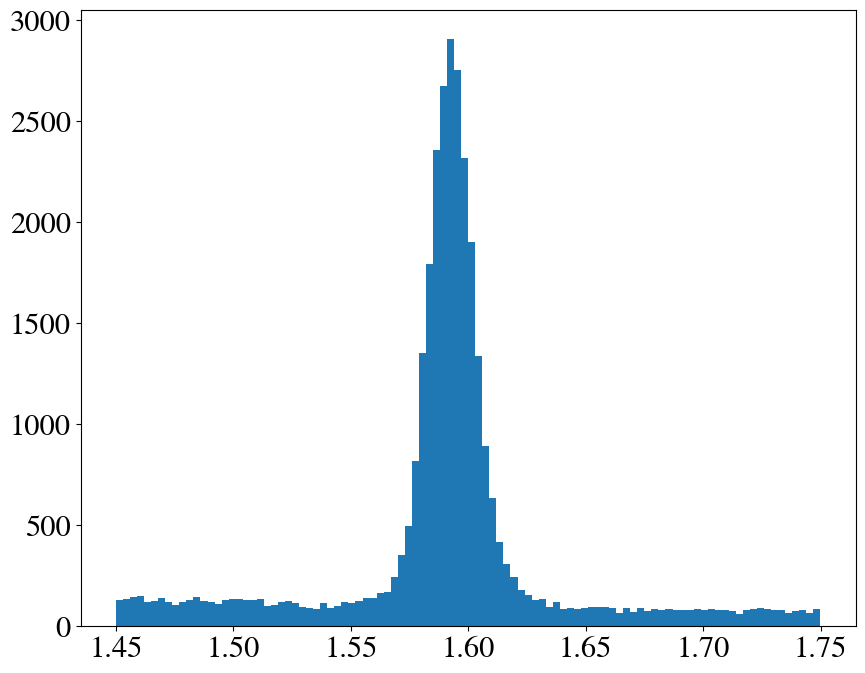

Optimized parameters (popt):
ns: 43.85900008106118
nb: 1188.4072485149725
tau: 1.7947012219105287

Covariance matrix (pcov):
ns: [3.40890494e-02 6.18662791e+00 4.34603845e-03]
nb: [6.18662791e+00 3.08891057e+05 1.64925921e+02]
tau: [4.34603845e-03 1.64925921e+02 8.83410723e-02]


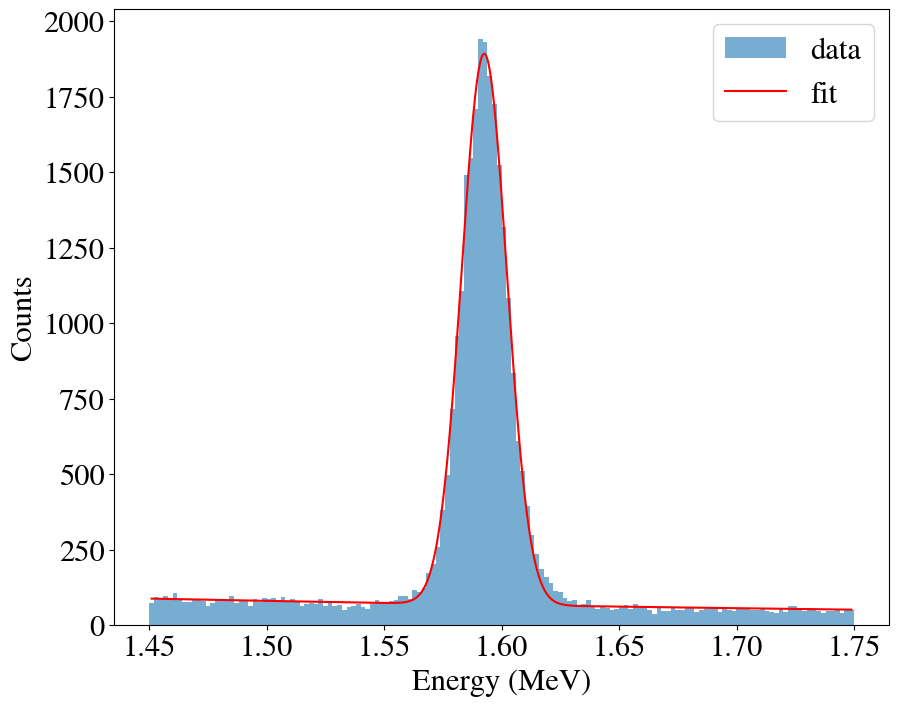

Signal events: 21935.4915468425
Background events: 10214.516962364203
Total Events by addition: 32150.008509206702
Total Events by row counting: 32146
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956, 0.015516866960953281, 0.01638619953076272, 0.017145031801828328]
ns_l: [23530.581335177

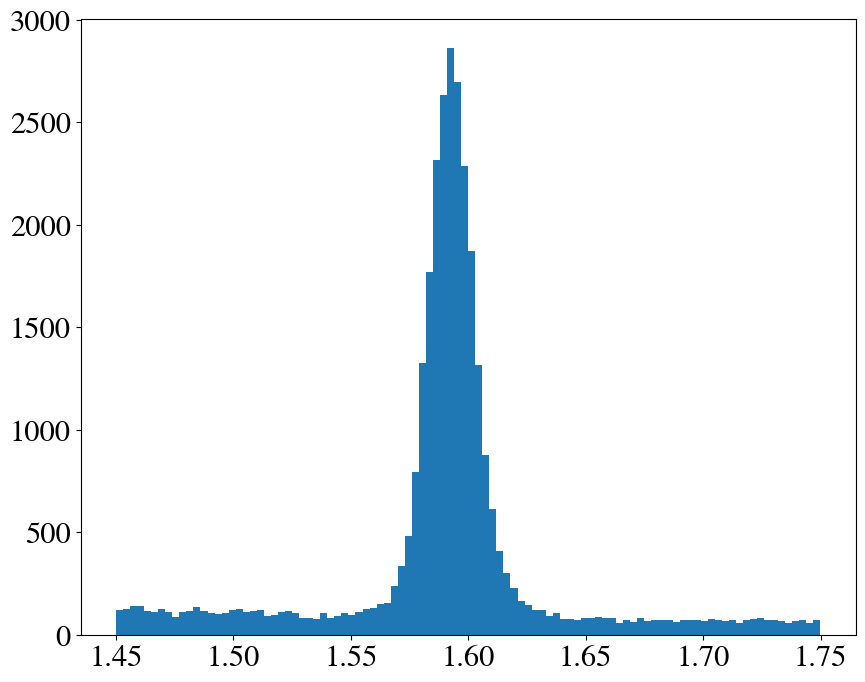

Optimized parameters (popt):
ns: 43.32642875065993
nb: 1275.8245406878987
tau: 1.8948028243894195

Covariance matrix (pcov):
ns: [3.43355222e-02 8.04880118e+00 5.15124431e-03]
nb: [8.04880118e+00 4.28389400e+05 2.13271808e+02]
tau: [5.15124431e-03 2.13271808e+02 1.06514862e-01]


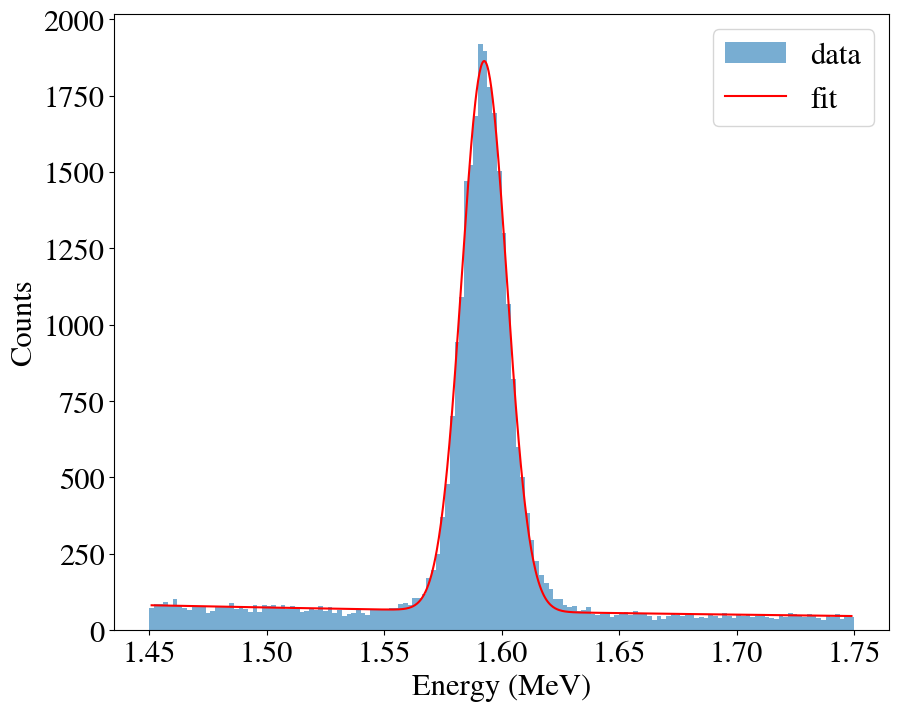

Signal events: 21669.133127942932
Background events: 9355.884376682403
Total Events by addition: 31025.017504625335
Total Events by row counting: 31021
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956, 0.015516866960953281, 0.01638619953076272, 0.017145031801828328, 0

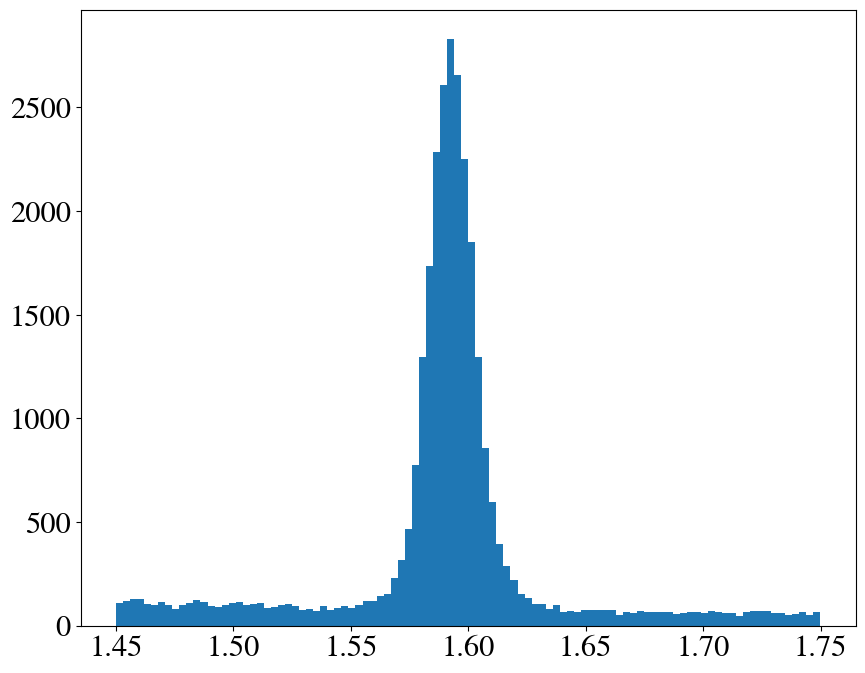

Optimized parameters (popt):
ns: 42.8518473357223
nb: 1305.3890869093864
tau: 1.9645678331756824

Covariance matrix (pcov):
ns: [3.33088095e-02 9.28669309e+00 5.73068668e-03]
nb: [9.28669309e+00 5.19549070e+05 2.52933396e+02]
tau: [5.73068668e-03 2.52933396e+02 1.23526970e-01]


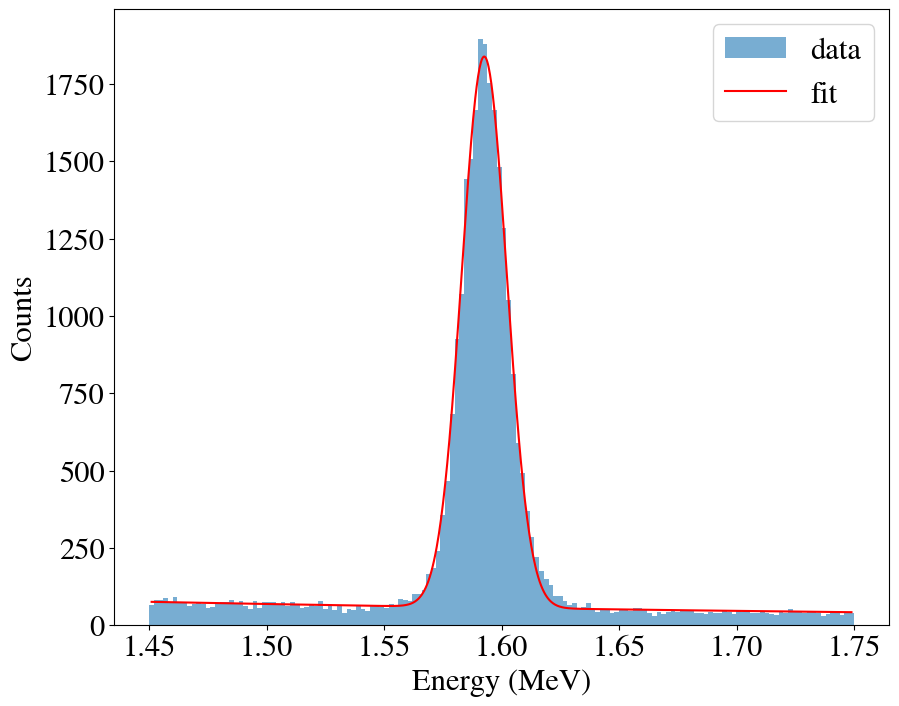

Signal events: 21431.777588682744
Background events: 8570.234022493558
Total Events by addition: 30002.0116111763
Total Events by row counting: 29998
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956, 0.015516866960953281, 0.01638619953076272, 0.017

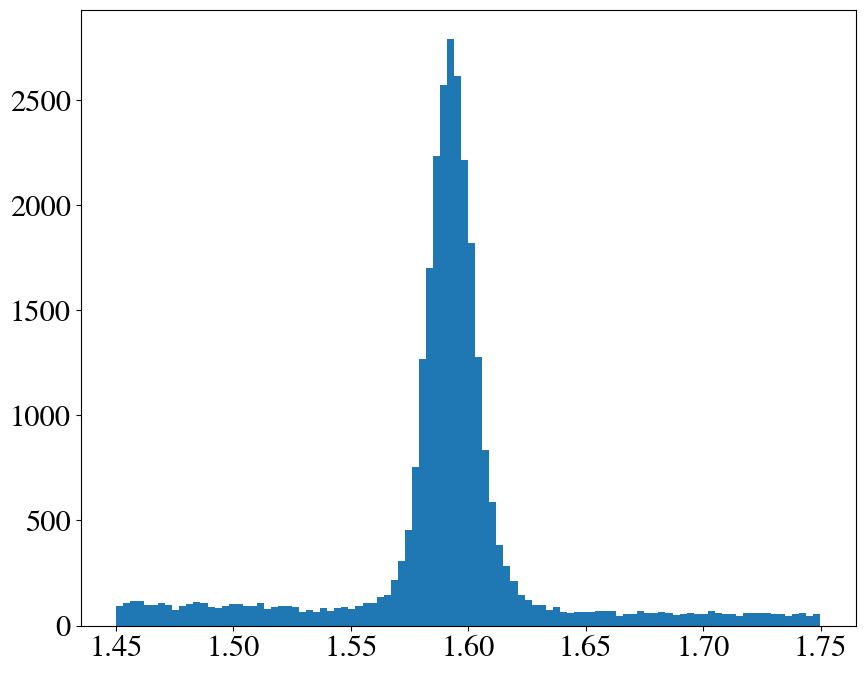

Optimized parameters (popt):
ns: 42.24964751151985
nb: 1286.3587126354141
tau: 2.006605675594514

Covariance matrix (pcov):
ns: [3.13024861e-02 9.66952061e+00 6.01076156e-03]
nb: [9.66952061e+00 5.58465191e+05 2.76016321e+02]
tau: [6.01076156e-03 2.76016321e+02 1.36850278e-01]


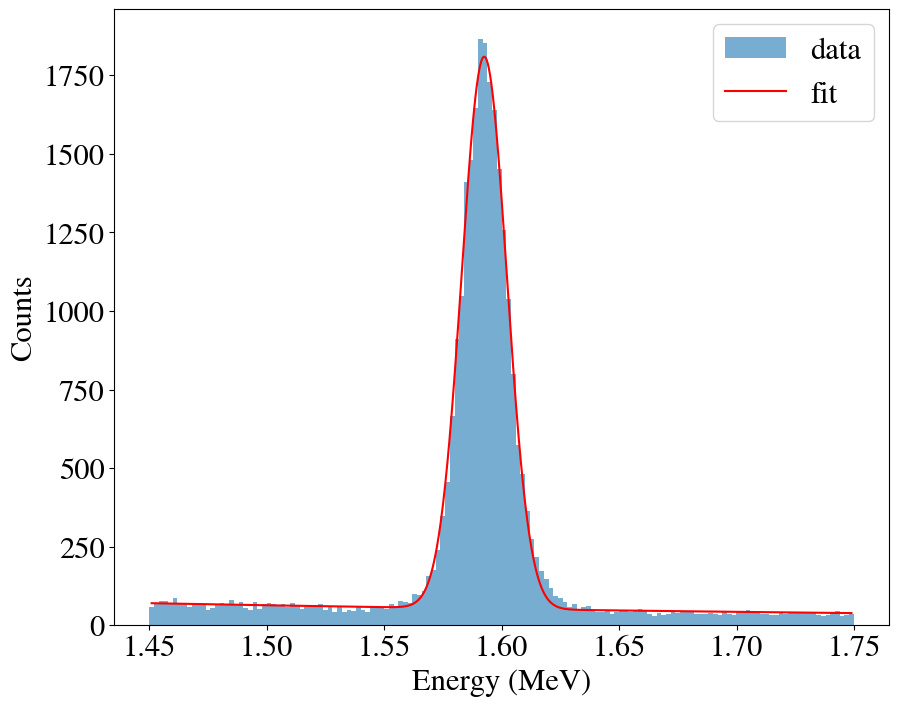

Signal events: 21130.595411047856
Background events: 7900.861555115962
Total Events by addition: 29031.456966163816
Total Events by row counting: 29027
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956, 0.015516866960953281, 0.016

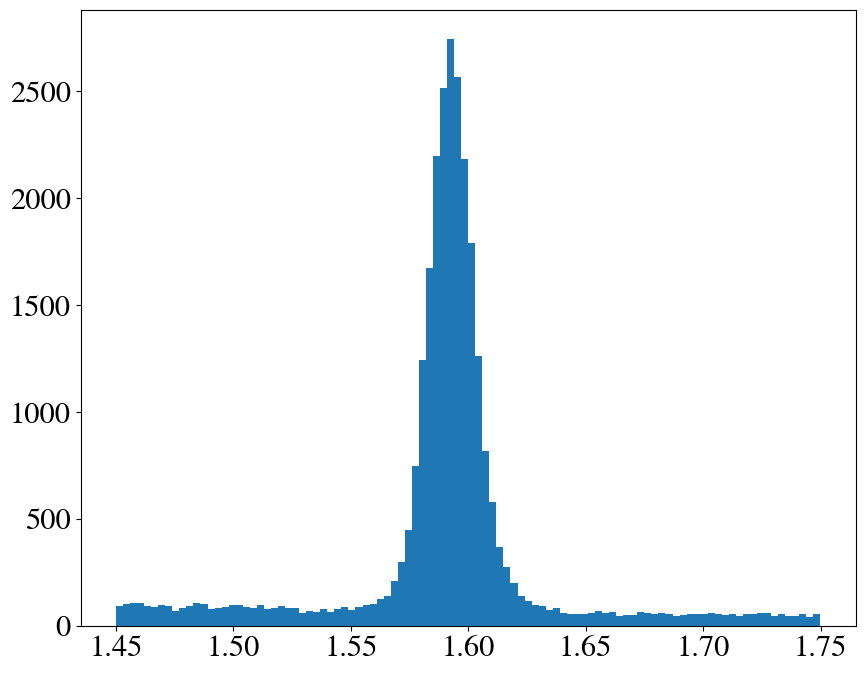

Optimized parameters (popt):
ns: 41.59639878192857
nb: 1278.5022892601557
tau: 2.0508581736913865

Covariance matrix (pcov):
ns: [3.05871570e-02 1.05112182e+01 6.52656394e-03]
nb: [1.05112182e+01 6.28627435e+05 3.12737305e+02]
tau: [6.52656394e-03 3.12737305e+02 1.56075335e-01]


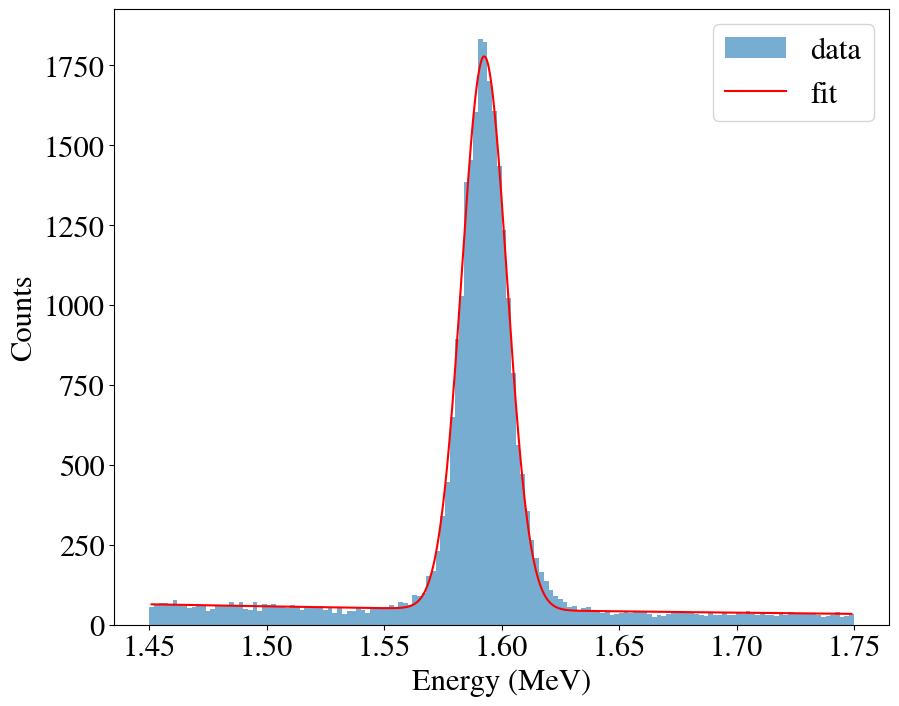

Signal events: 20803.881807011025
Background events: 7320.739989162316
Total Events by addition: 28124.621796173342
Total Events by row counting: 28120
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.014682698207177956, 0.01551

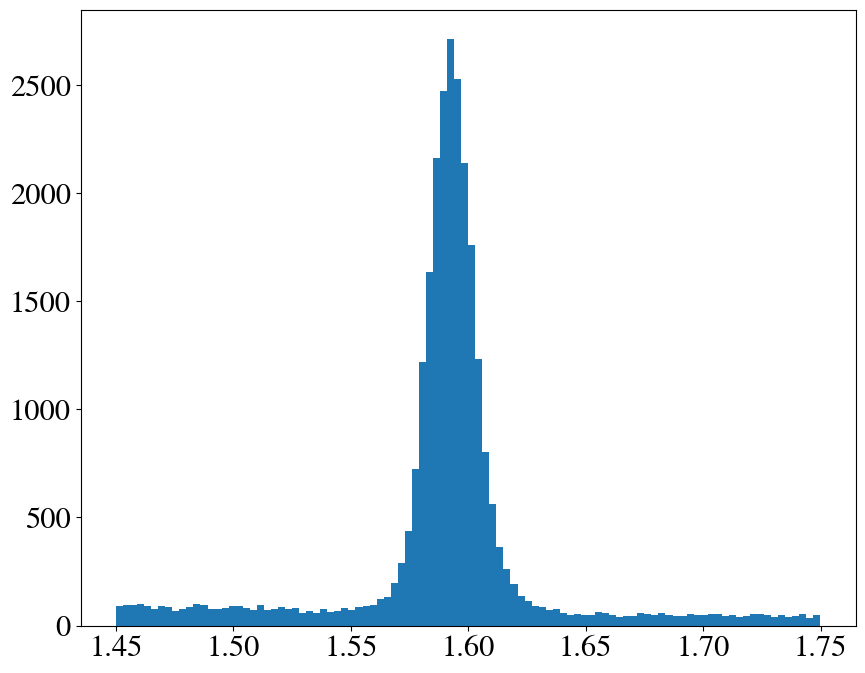

Optimized parameters (popt):
ns: 40.99220895164335
nb: 1344.2727987722044
tau: 2.129090401433719

Covariance matrix (pcov):
ns: [3.04728920e-02 1.26039941e+01 7.35638050e-03]
nb: [1.26039941e+01 8.04252271e+05 3.80824108e+02]
tau: [7.35638050e-03 3.80824108e+02 1.80891185e-01]


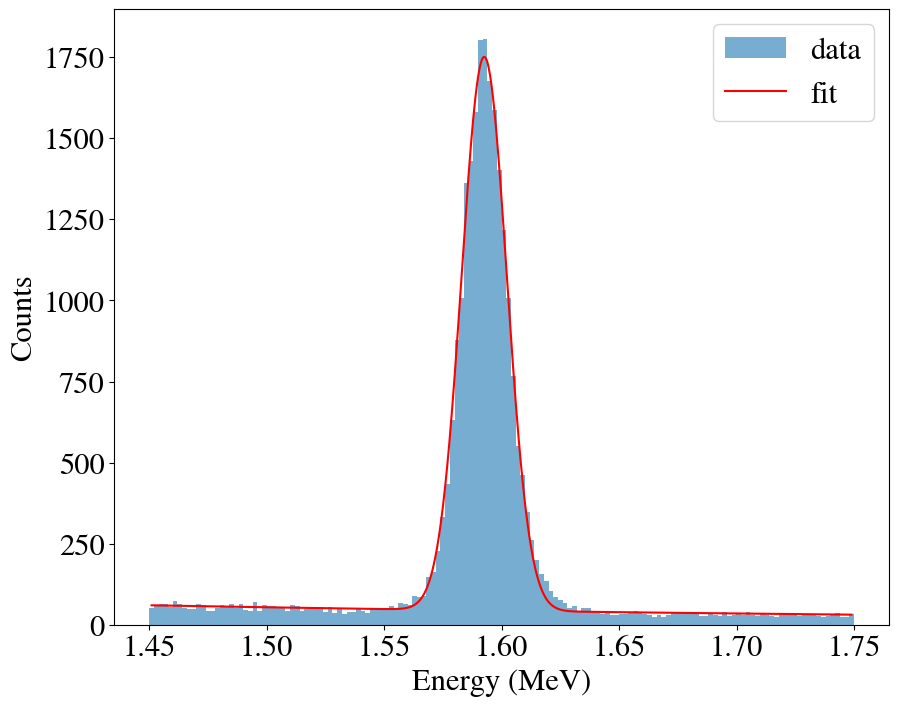

Signal events: 20501.704354483267
Background events: 6800.003459823741
Total Events by addition: 27301.707814307007
Total Events by row counting: 27297
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142345866876, 0.0146826

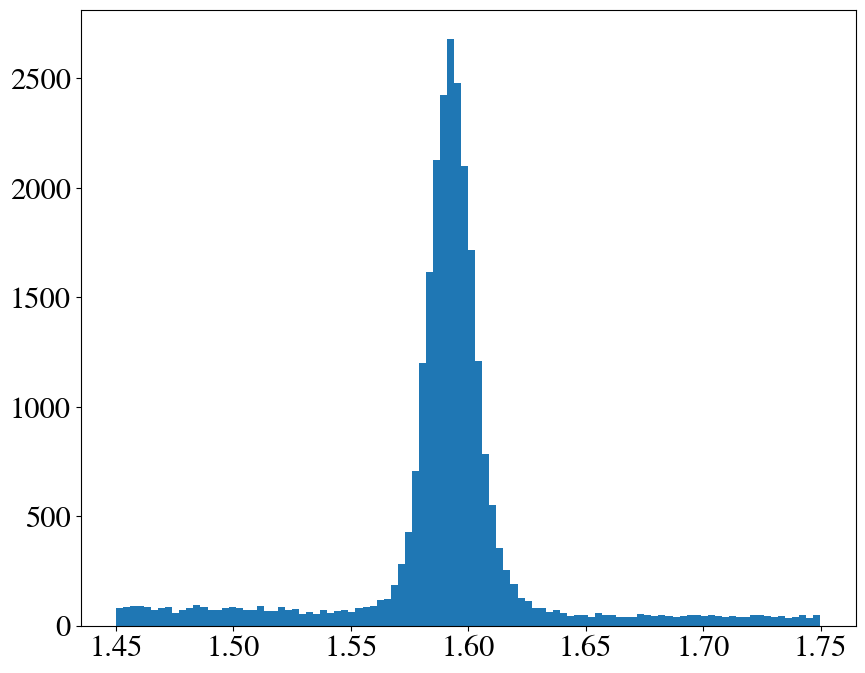

Optimized parameters (popt):
ns: 40.3666327555812
nb: 1318.9089162643231
tau: 2.1648641032087665

Covariance matrix (pcov):
ns: [2.98966455e-02 1.34405290e+01 7.95711107e-03]
nb: [1.34405290e+01 8.84458409e+05 4.27053940e+02]
tau: [7.95711107e-03 4.27053940e+02 2.06845181e-01]


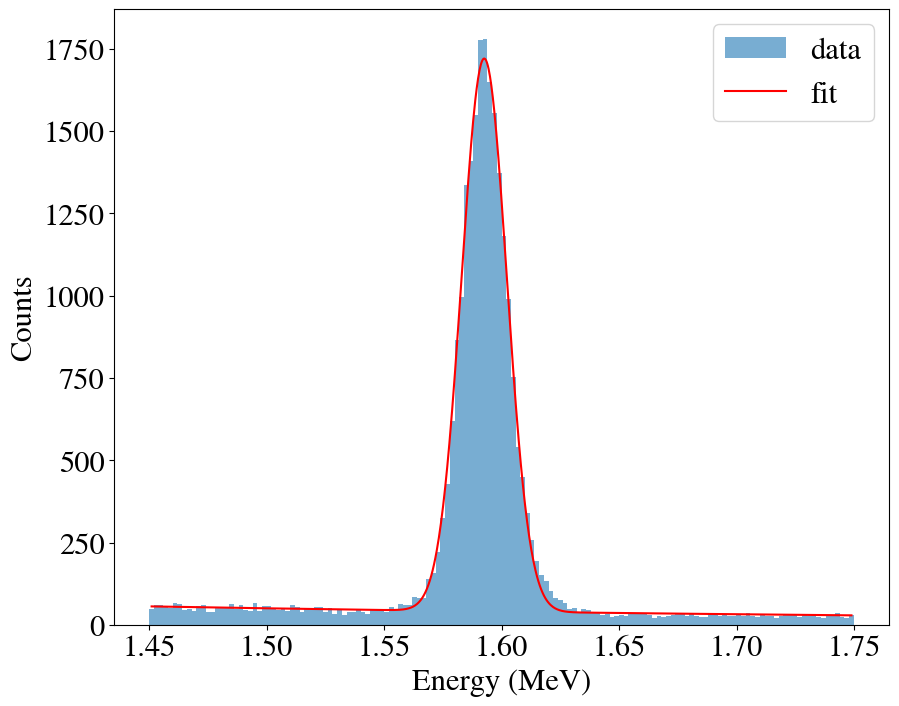

Signal events: 20188.830797510578
Background events: 6304.157861828166
Total Events by addition: 26492.988659338742
Total Events by row counting: 26488
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718248629, 0.013867142

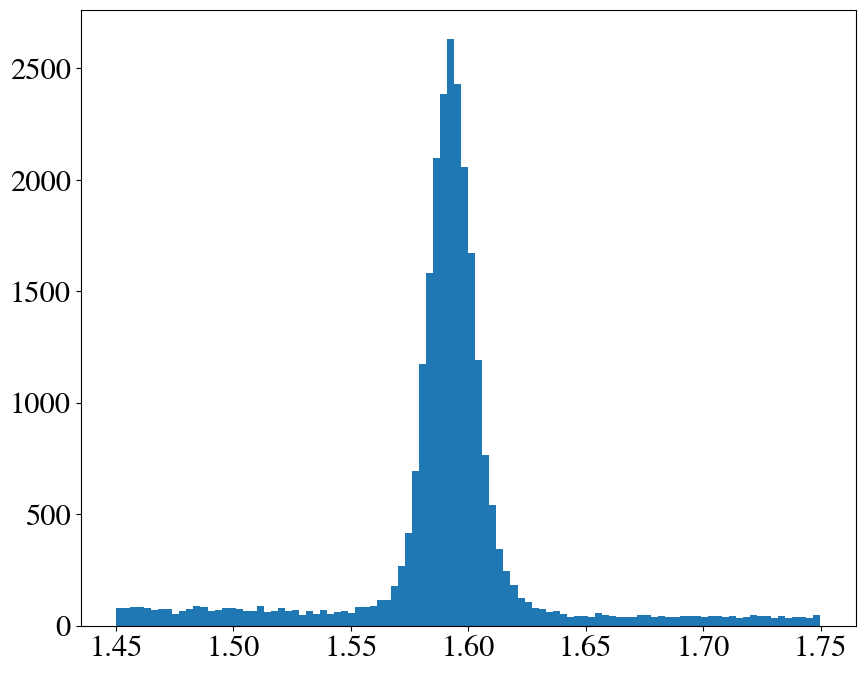

Optimized parameters (popt):
ns: 39.672446336518696
nb: 1420.028093419415
tau: 2.252630711959835

Covariance matrix (pcov):
ns: [2.85469178e-02 1.56981409e+01 8.53949435e-03]
nb: [1.56981409e+01 1.11736182e+06 5.01688156e+02]
tau: [8.53949435e-03 5.01688156e+02 2.25955247e-01]


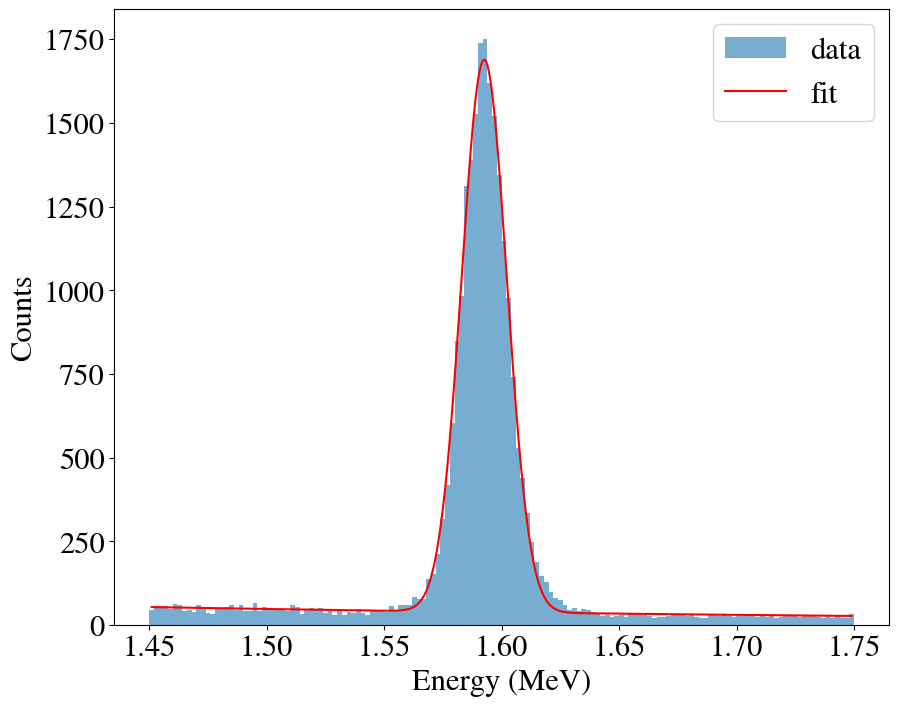

Signal events: 19841.64275630729
Background events: 5906.770233126995
Total Events by addition: 25748.412989434284
Total Events by row counting: 25743
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.01242271873476617, 0.013129175718

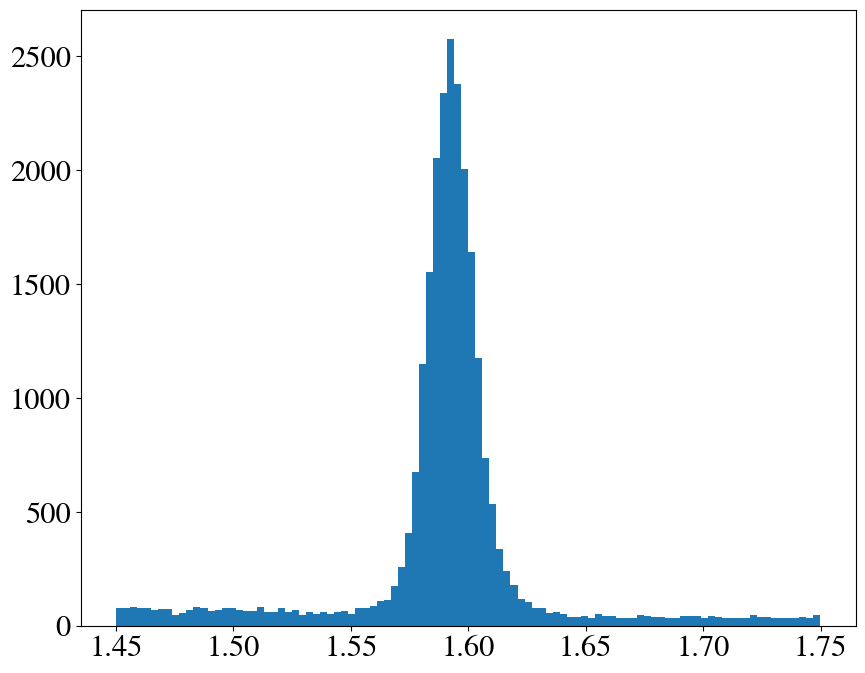

Optimized parameters (popt):
ns: 38.884357142372274
nb: 1420.1722130745982
tau: 2.294544356602098

Covariance matrix (pcov):
ns: [2.79606796e-02 1.69031983e+01 9.15180053e-03]
nb: [1.69031983e+01 1.25071119e+06 5.61868163e+02]
tau: [9.15180053e-03 5.61868163e+02 2.53195539e-01]


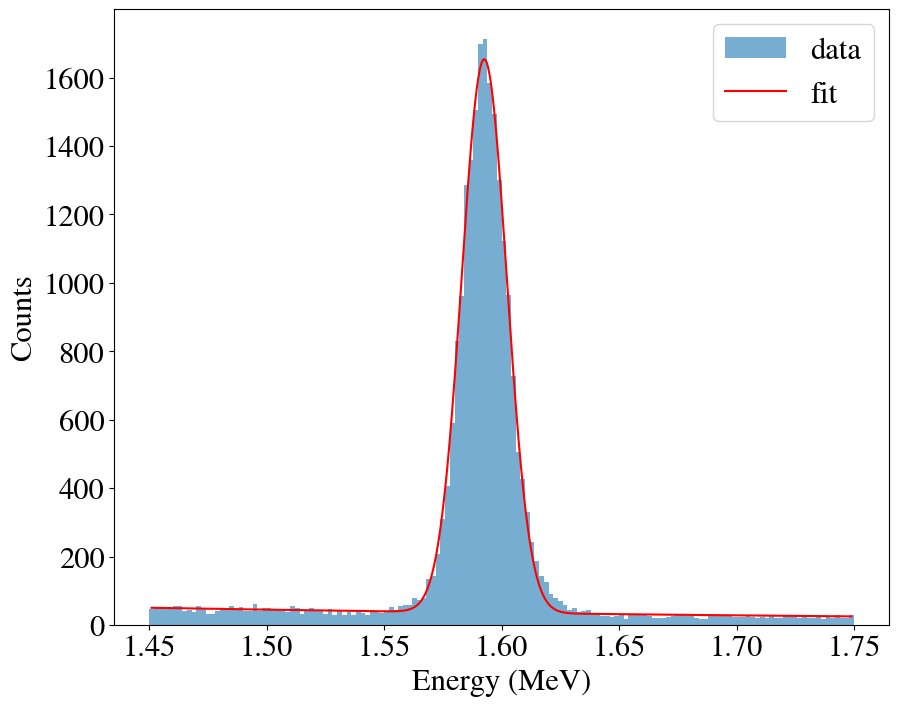

Signal events: 19447.49049965743
Background events: 5528.124525617623
Total Events by addition: 24975.615025275052
Total Events by row counting: 24970
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.01183117989282877, 0.0124227187347

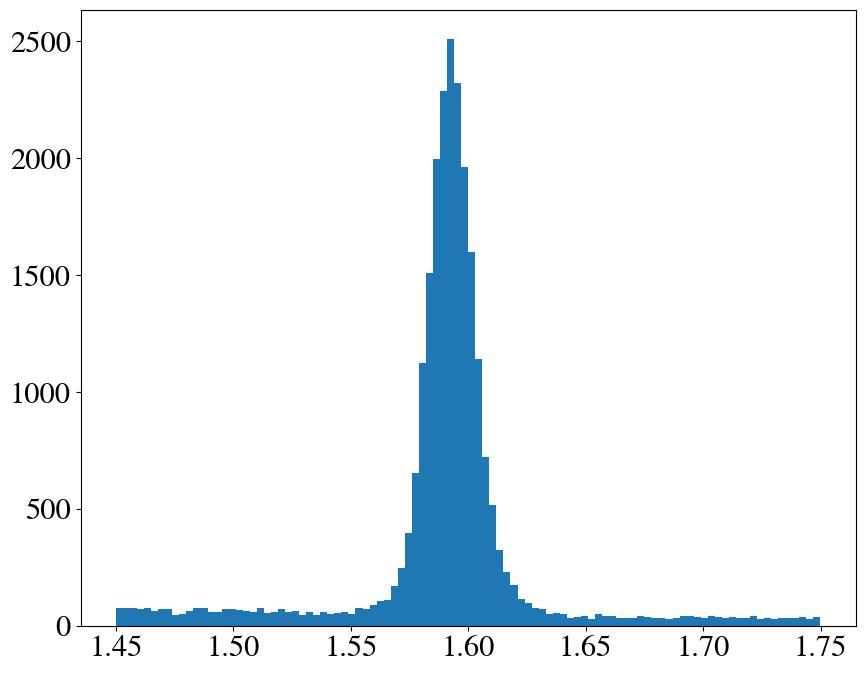

Optimized parameters (popt):
ns: 37.95308503584183
nb: 1510.0152761640188
tau: 2.37256617326024

Covariance matrix (pcov):
ns: [2.68984194e-02 1.93834764e+01 9.78279961e-03]
nb: [1.93834764e+01 1.54590246e+06 6.53352189e+02]
tau: [9.78279961e-03 6.53352189e+02 2.76980063e-01]


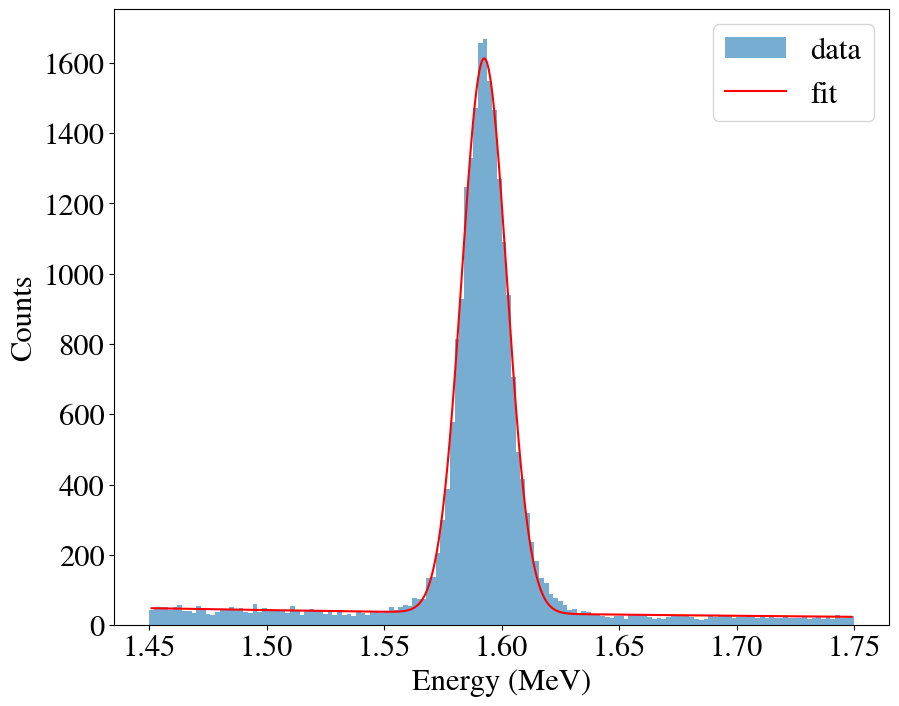

Signal events: 18981.727226831936
Background events: 5195.073676631669
Total Events by addition: 24176.800903463605
Total Events by row counting: 24171
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.011337559426816112, 0.0118311798928

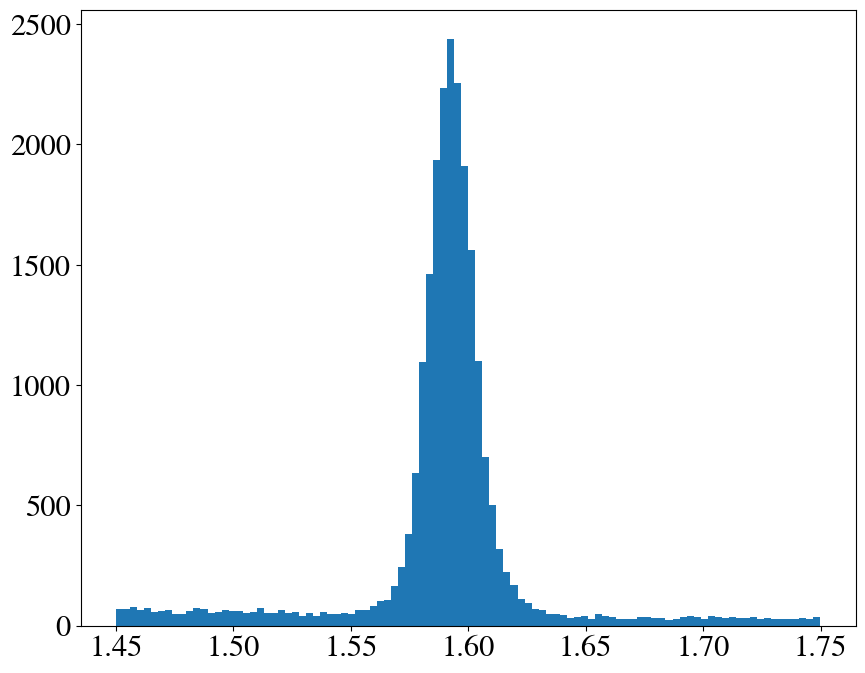

Optimized parameters (popt):
ns: 36.977500280660195
nb: 1361.0784496298072
tau: 2.349329864083574

Covariance matrix (pcov):
ns: [2.58862121e-02 1.77141192e+01 9.94171812e-03]
nb: [1.77141192e+01 1.38137984e+06 6.47506446e+02]
tau: [9.94171812e-03 6.47506446e+02 3.04448245e-01]


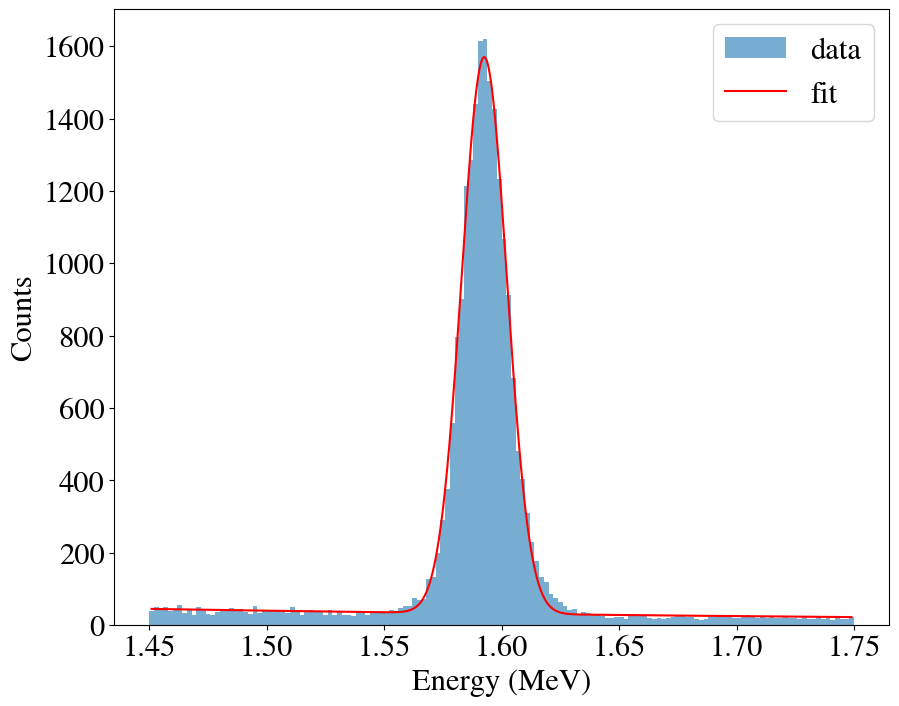

Signal events: 18493.80157620234
Background events: 4858.055020264135
Total Events by addition: 23351.856596466474
Total Events by row counting: 23346
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.0109683838082615, 0.0113375594268161

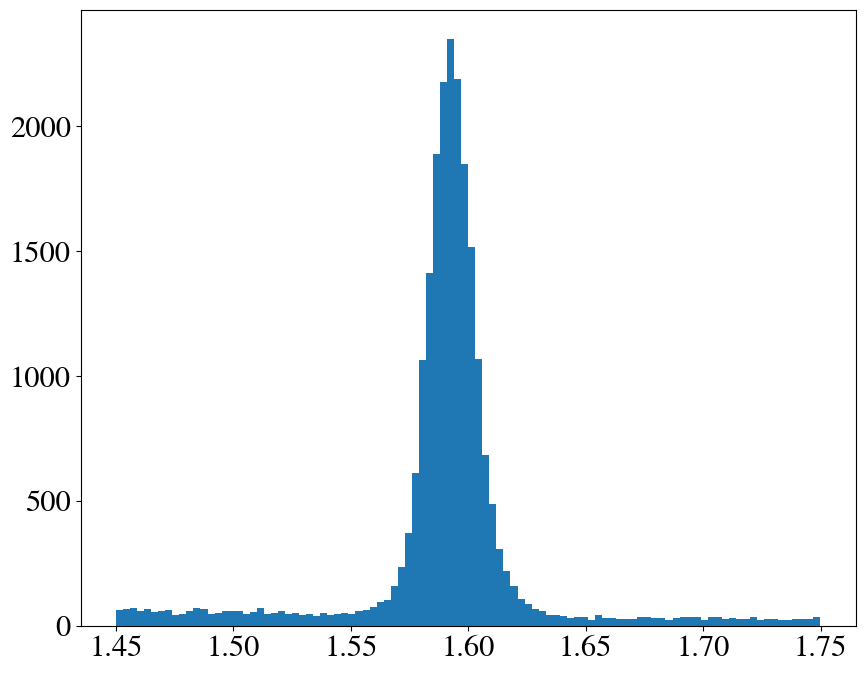

Optimized parameters (popt):
ns: 35.86939634133581
nb: 1533.4590638053992
tau: 2.468101555951742

Covariance matrix (pcov):
ns: [2.40858242e-02 2.14356656e+01 1.05522437e-02]
nb: [2.14356656e+01 1.88014996e+06 7.82988993e+02]
tau: [1.05522437e-02 7.82988993e+02 3.27072592e-01]


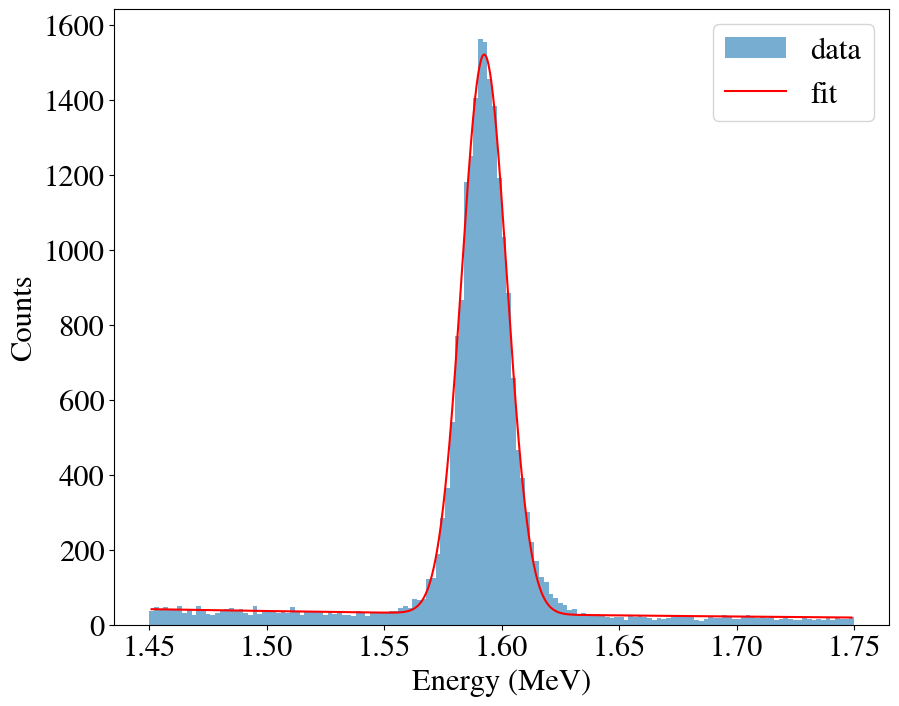

Signal events: 17939.598230272237
Background events: 4535.7060868282615
Total Events by addition: 22475.304317100497
Total Events by row counting: 22469
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.010670963099683711, 0.01096838380826

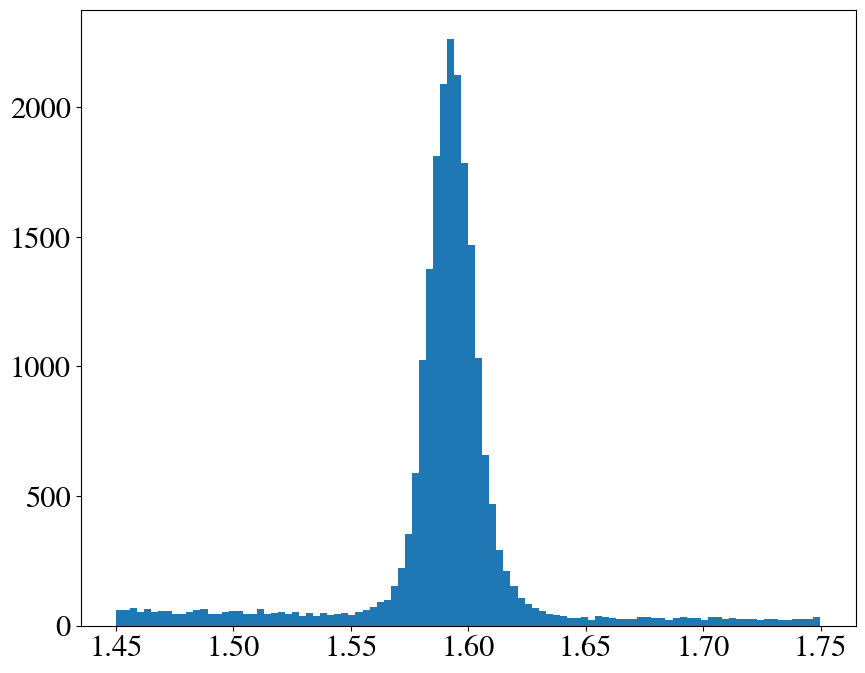

Optimized parameters (popt):
ns: 34.661724417826456
nb: 1338.6231914093496
tau: 2.42174708964984

Covariance matrix (pcov):
ns: [2.09403924e-02 1.68324691e+01 9.53370151e-03]
nb: [1.68324691e+01 1.40928885e+06 6.72024114e+02]
tau: [9.53370151e-03 6.72024114e+02 3.21440206e-01]


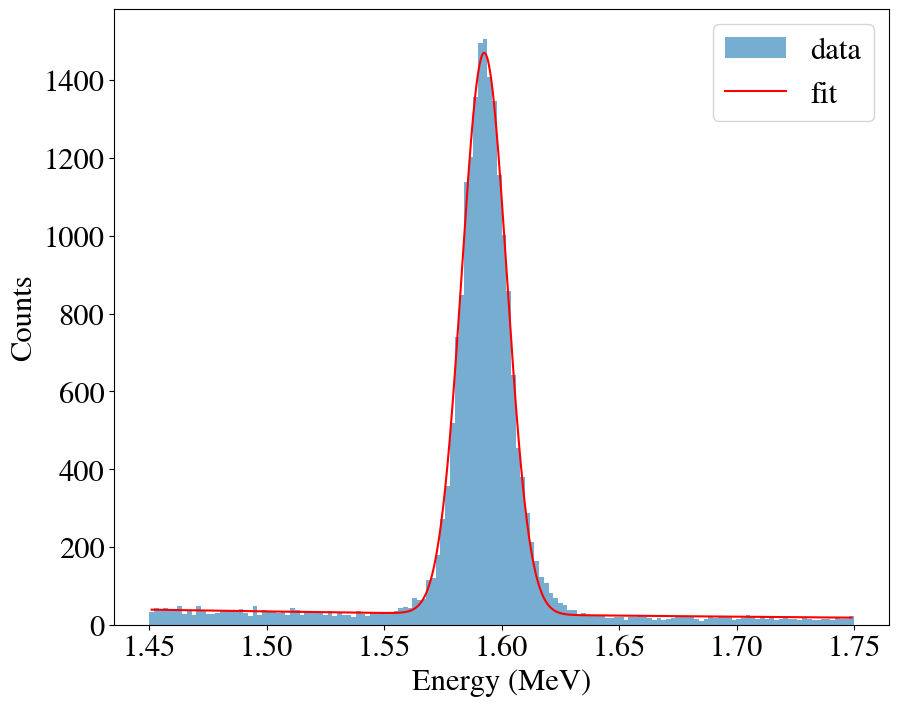

Signal events: 17335.597290430072
Background events: 4260.644671815663
Total Events by addition: 21596.241962245735
Total Events by row counting: 21590
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671, 0.01067096309968371

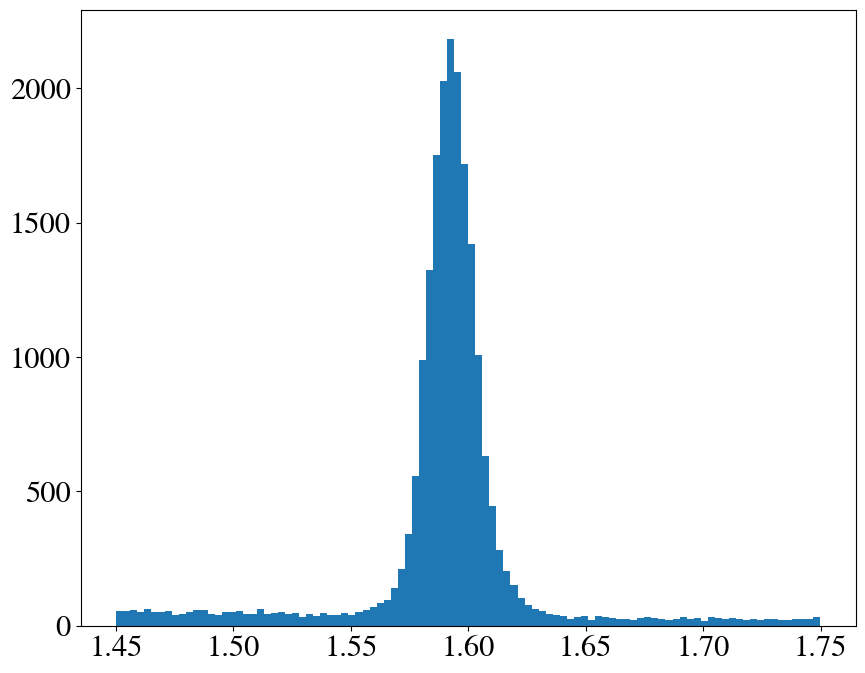

Optimized parameters (popt):
ns: 33.51508140416331
nb: 1062.873387563407
tau: 2.318519562163082

Covariance matrix (pcov):
ns: [2.06075761e-02 1.31630134e+01 9.49044101e-03]
nb: [1.31630134e+01 9.96708348e+05 5.98030290e+02]
tau: [9.49044101e-03 5.98030290e+02 3.59931565e-01]


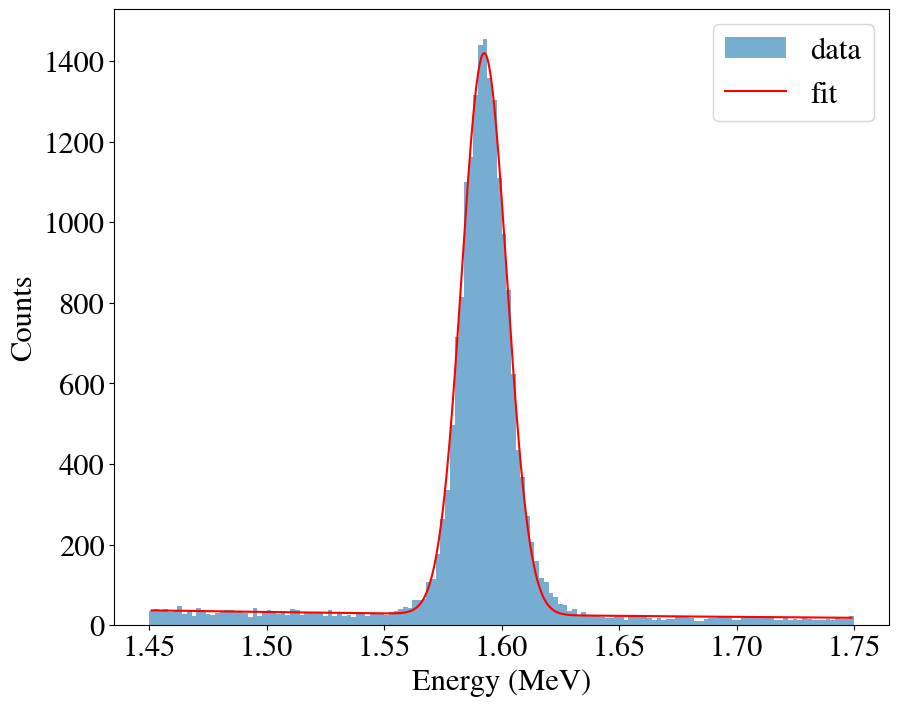

Signal events: 16762.119142570635
Background events: 3983.2493571185605
Total Events by addition: 20745.368499689197
Total Events by row counting: 20740
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 0.01045536998610671

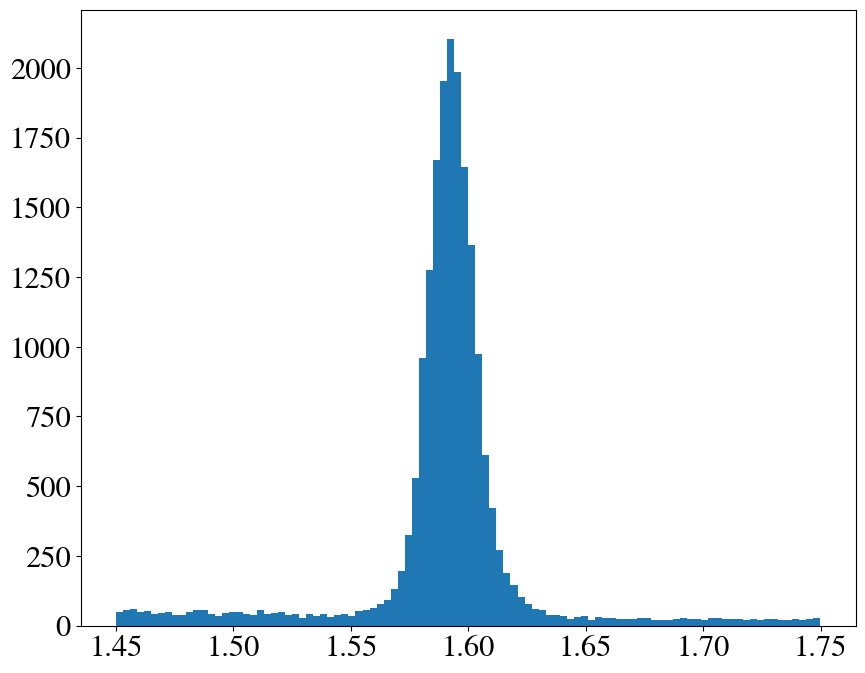

Optimized parameters (popt):
ns: 32.24936222317775
nb: 966.2732355334388
tau: 2.3042208908487

Covariance matrix (pcov):
ns: [1.98239564e-02 1.22434349e+01 9.73546224e-03]
nb: [1.22434349e+01 9.14050154e+05 6.03761829e+02]
tau: [9.73546224e-03 6.03761829e+02 4.00041016e-01]


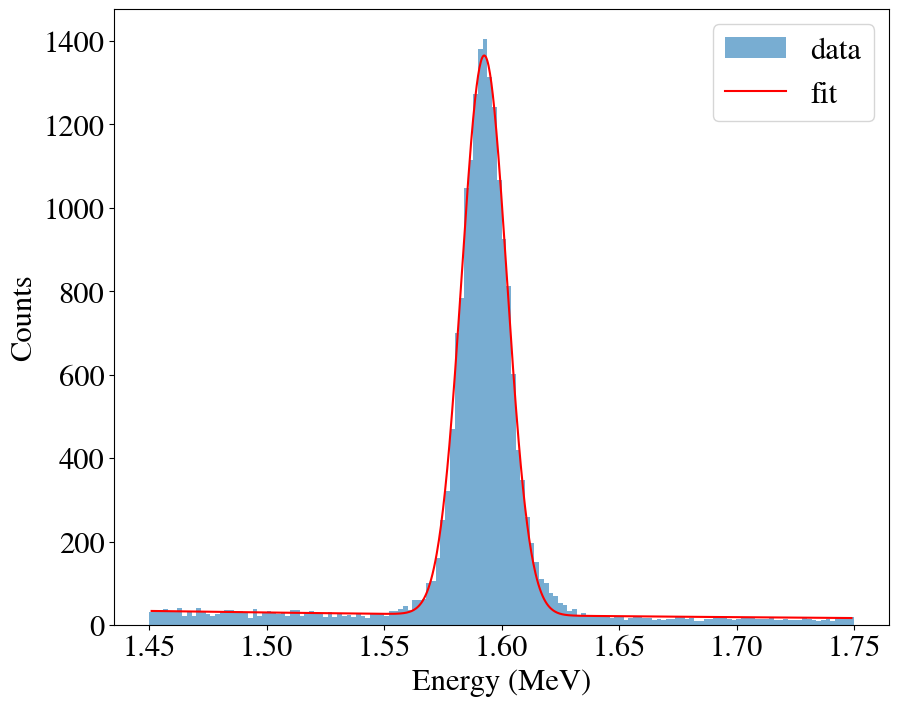

Signal events: 16129.086644249399
Background events: 3704.117635822428
Total Events by addition: 19833.204280071826
Total Events by row counting: 19828
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0.010311780855992261, 

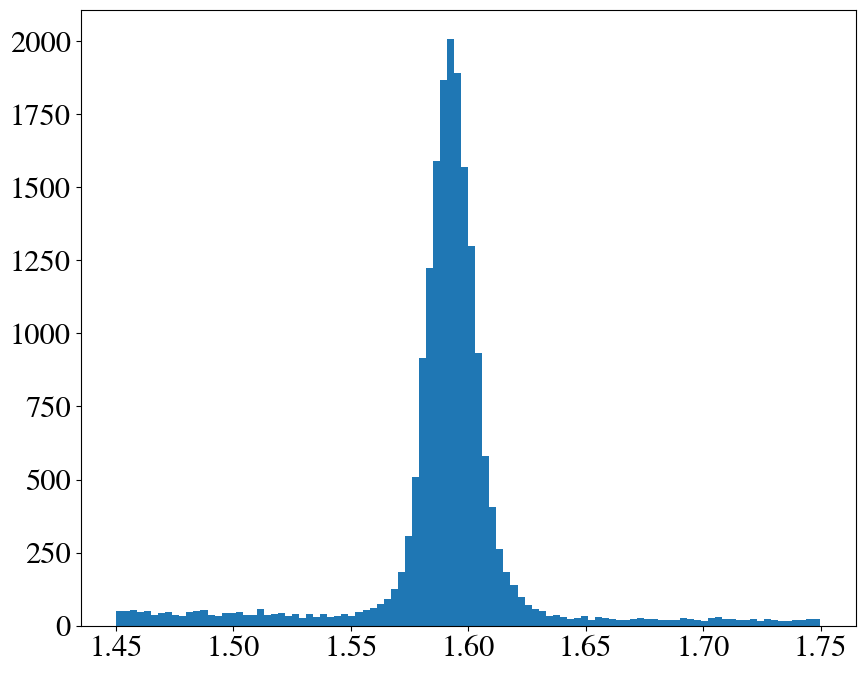

Optimized parameters (popt):
ns: 30.830917427737763
nb: 919.2255220657189
tau: 2.3177826460843236

Covariance matrix (pcov):
ns: [1.88086967e-02 1.19721329e+01 9.99475985e-03]
nb: [1.19721329e+01 9.05197117e+05 6.28763832e+02]
tau: [9.99475985e-03 6.28763832e+02 4.38100526e-01]


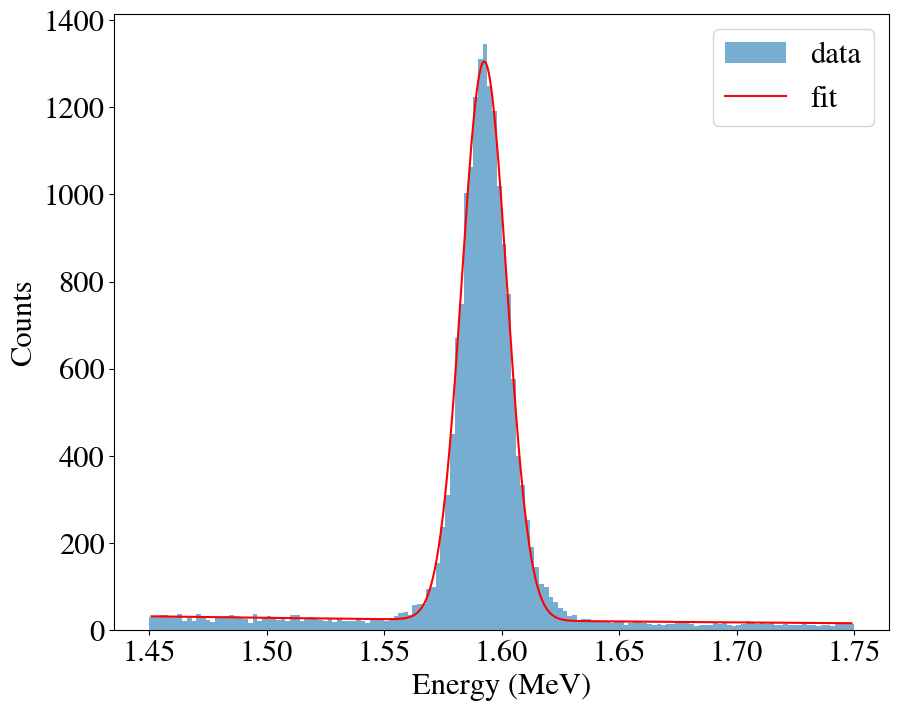

Signal events: 15419.670475104404
Background events: 3448.9315344236525
Total Events by addition: 18868.602009528055
Total Events by row counting: 18863
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.010216460340559565, 0

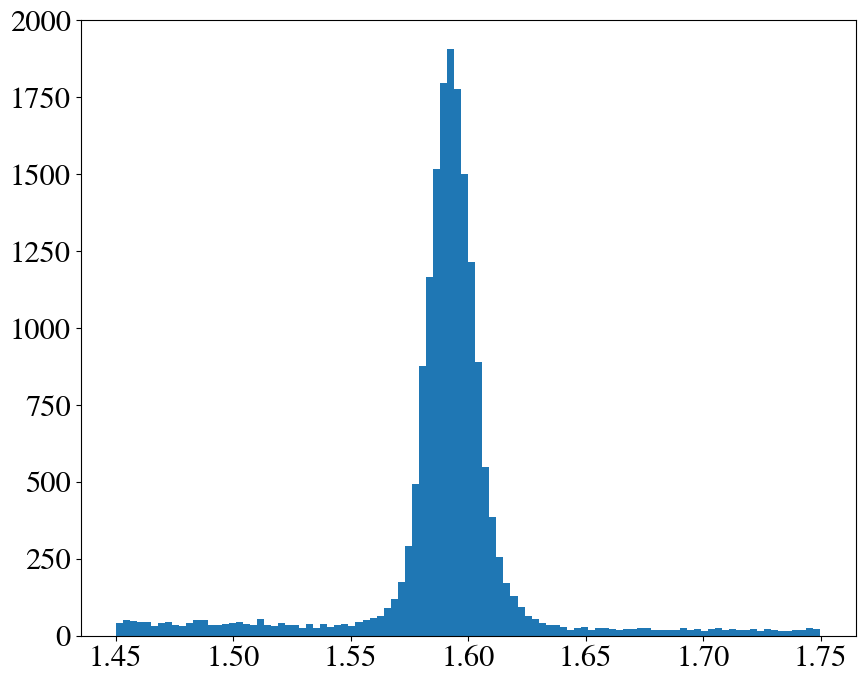

Optimized parameters (popt):
ns: 29.295407308282158
nb: 942.3539169055075
tau: 2.3808337442840686

Covariance matrix (pcov):
ns: [1.74710210e-02 1.28239846e+01 1.03619605e-02]
nb: [1.28239846e+01 1.03106724e+06 6.98298736e+02]
tau: [1.03619605e-02 6.98298736e+02 4.74384532e-01]


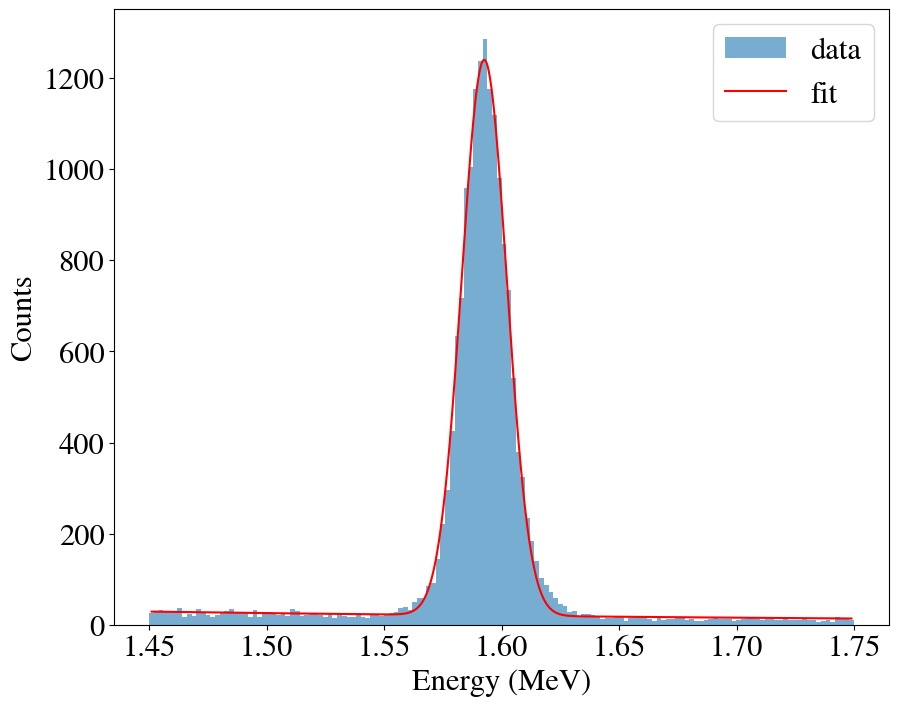

Signal events: 14651.705651849034
Background events: 3199.9487689104726
Total Events by addition: 17851.654420759507
Total Events by row counting: 17846
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010168602902059325, 0.0

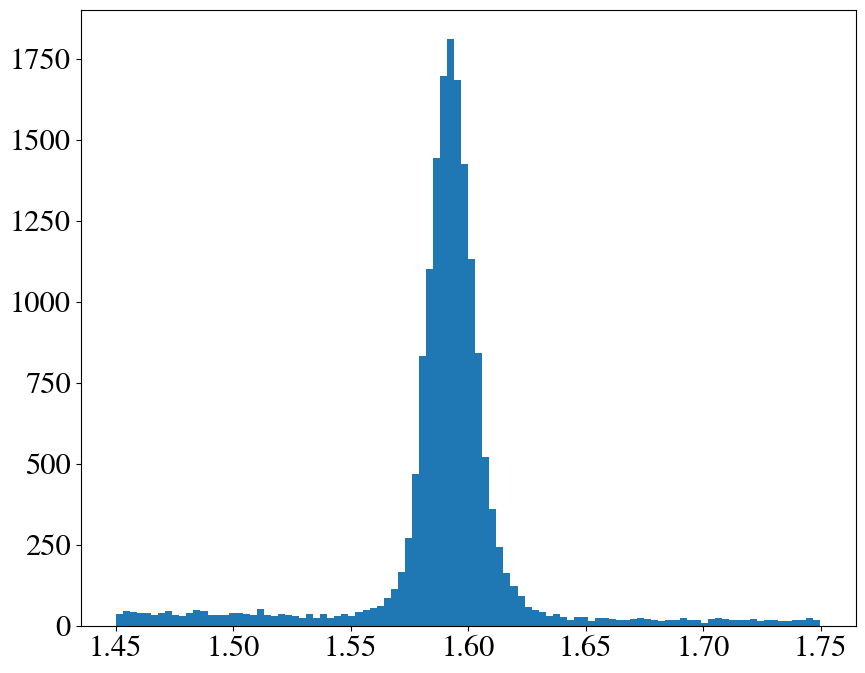

Optimized parameters (popt):
ns: 27.757518167188245
nb: 833.5616282419999
tau: 2.352883374142186

Covariance matrix (pcov):
ns: [1.61022379e-02 1.11095693e+01 1.01751151e-02]
nb: [1.11095693e+01 8.69414991e+05 6.65336857e+02]
tau: [1.01751151e-02 6.65336857e+02 5.10733143e-01]


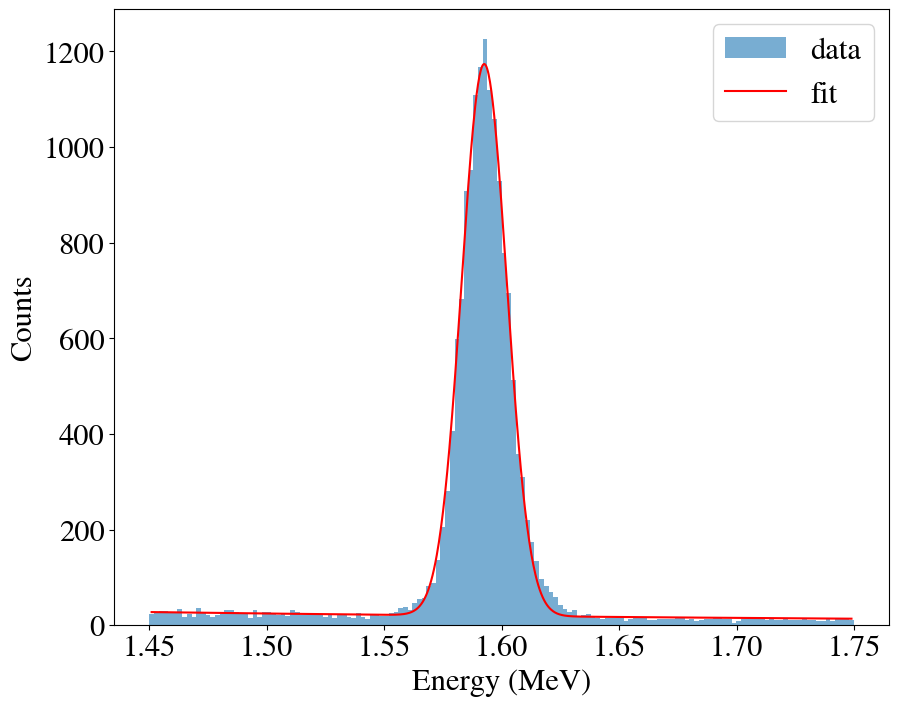

Signal events: 13882.550992780249
Background events: 2958.5217300208697
Total Events by addition: 16841.072722801116
Total Events by row counting: 16836
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.0101426425952176, 0.010

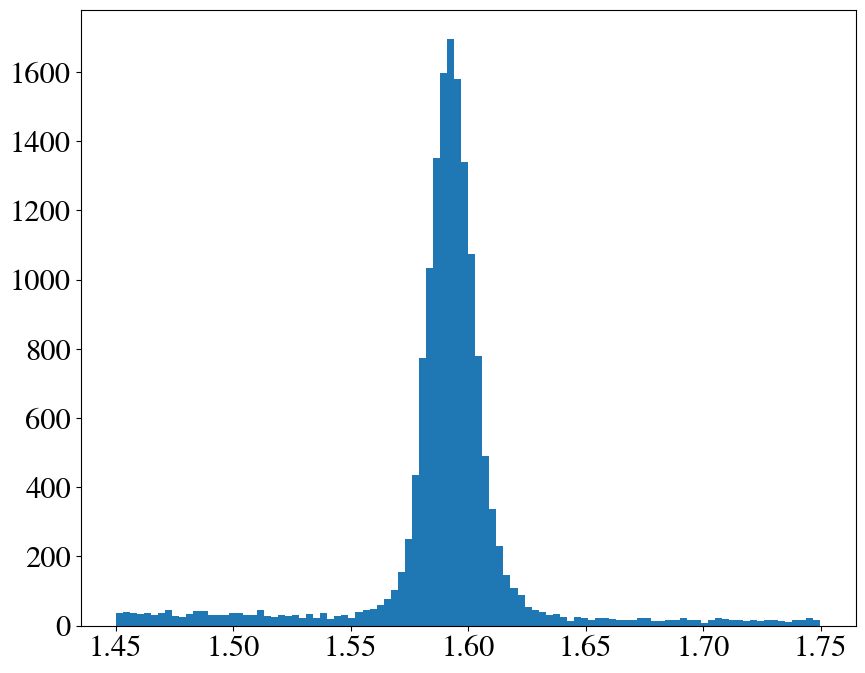

Optimized parameters (popt):
ns: 26.06983761098747
nb: 681.2146457956685
tau: 2.2810159971434585

Covariance matrix (pcov):
ns: [0.01358962 7.96554612 0.00900724]
nb: [7.96554612e+00 5.81899439e+05 5.45042293e+02]
tau: [9.00724016e-03 5.45042293e+02 5.12103953e-01]


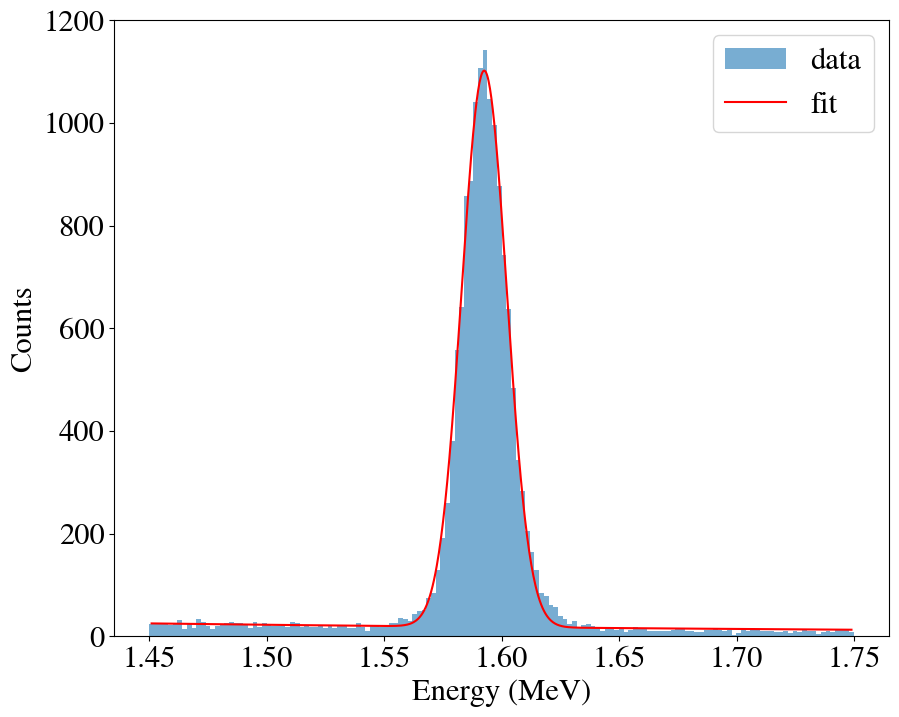

Signal events: 13038.480163397653
Background events: 2709.07573574083
Total Events by addition: 15747.555899138482
Total Events by row counting: 15743
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.010135026389032981, 0.01014

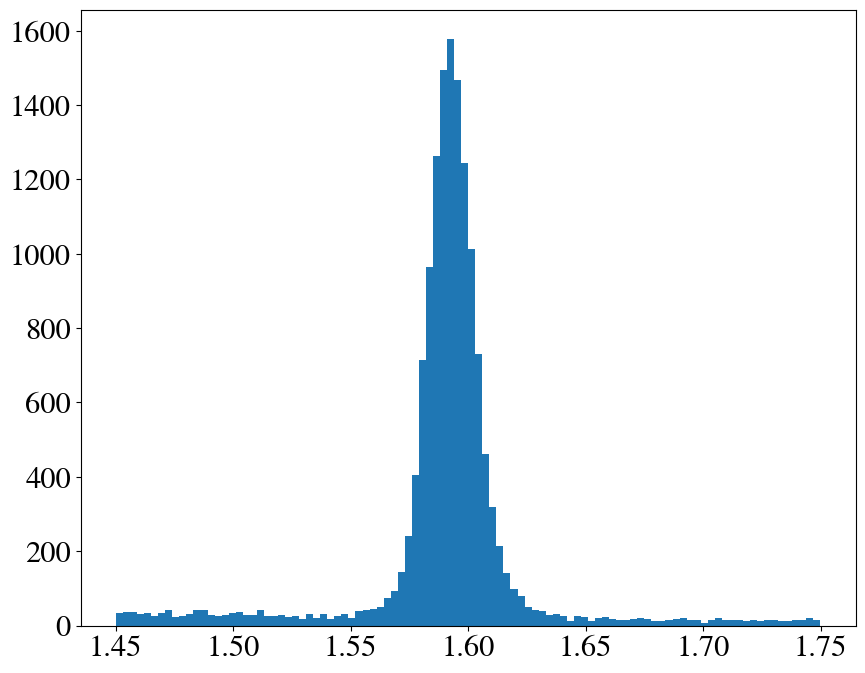

Optimized parameters (popt):
ns: 24.30469236111492
nb: 599.5716373071053
tau: 2.2427064531392995

Covariance matrix (pcov):
ns: [0.01171151 6.29566184 0.00812136]
nb: [6.29566184e+00 4.44038482e+05 4.72174925e+02]
tau: [8.12136330e-03 4.72174925e+02 5.03656926e-01]


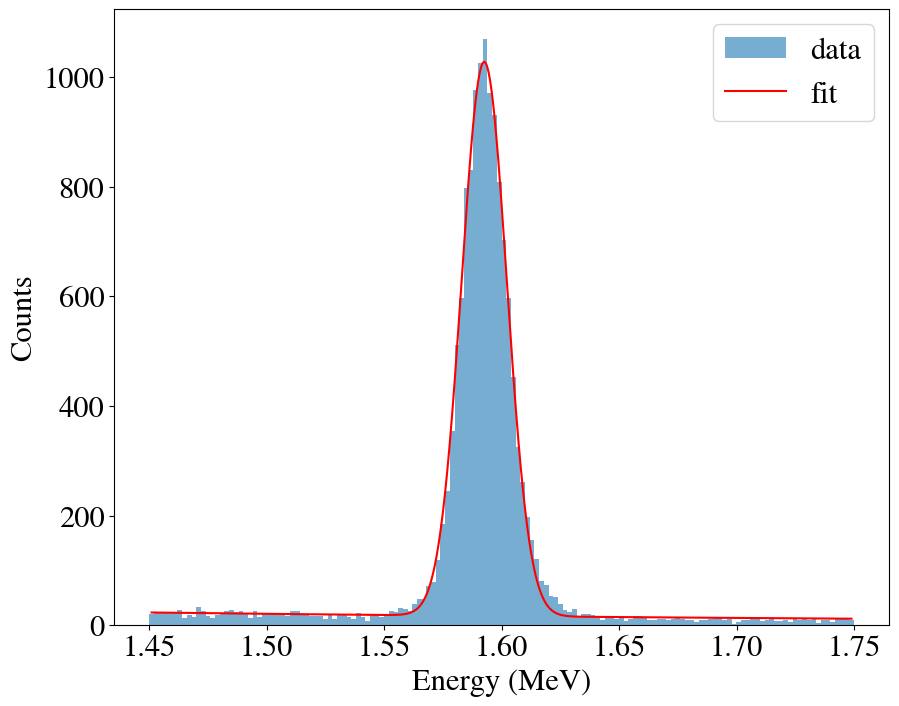

Signal events: 12155.666404853988
Background events: 2533.483818057129
Total Events by addition: 14689.150222911117
Total Events by row counting: 14685
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.010130939297594692, 0.0101350

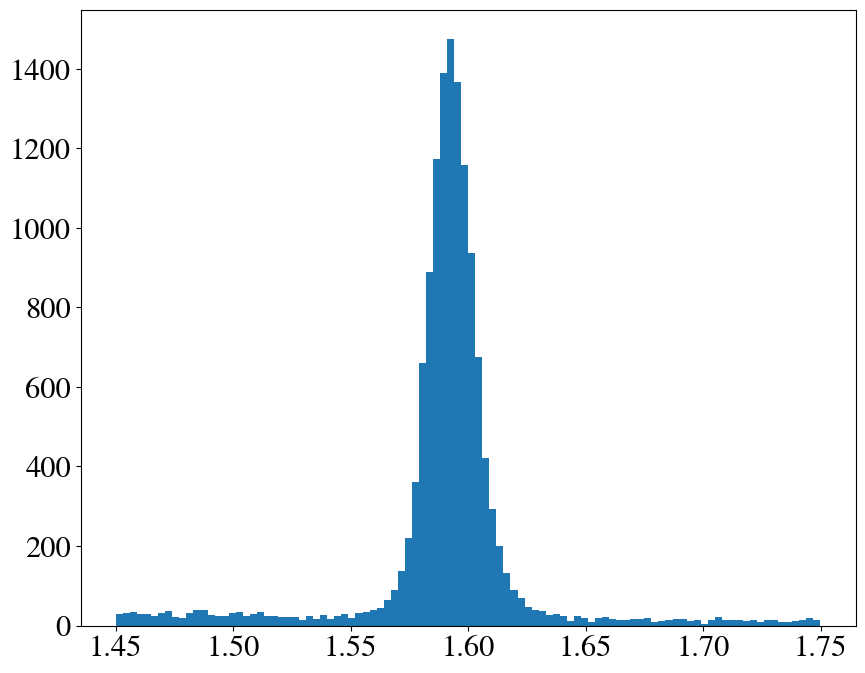

Optimized parameters (popt):
ns: 22.604345637154122
nb: 587.7748509442646
tau: 2.3014861145611296

Covariance matrix (pcov):
ns: [0.01121506 6.88418813 0.00900154]
nb: [6.88418813e+00 5.12631250e+05 5.56631684e+02]
tau: [9.00153757e-03 5.56631684e+02 6.06281472e-01]


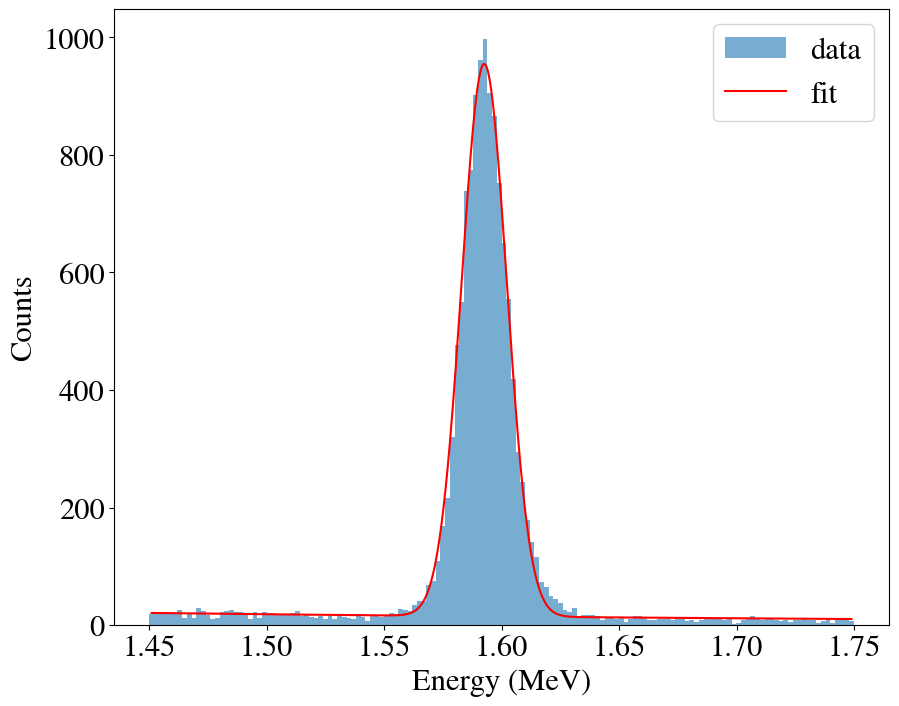

Signal events: 11305.26076128691
Background events: 2262.9542315695494
Total Events by addition: 13568.21499285646
Total Events by row counting: 13565
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799]
fom_err: [0.01012695744331514, 0.010128075880333197, 0.0101309392

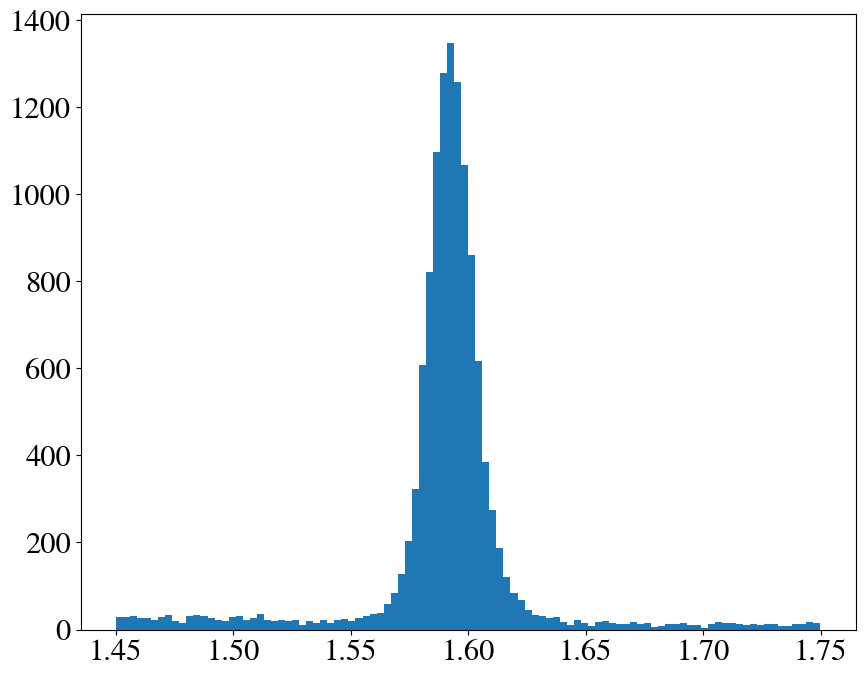

Optimized parameters (popt):
ns: 20.819180765031362
nb: 517.8441978157581
tau: 2.2840882052078753

Covariance matrix (pcov):
ns: [0.01033493 6.10079681 0.00907083]
nb: [6.10079681e+00 4.46985205e+05 5.50716108e+02]
tau: [9.07082675e-03 5.50716108e+02 6.80624765e-01]


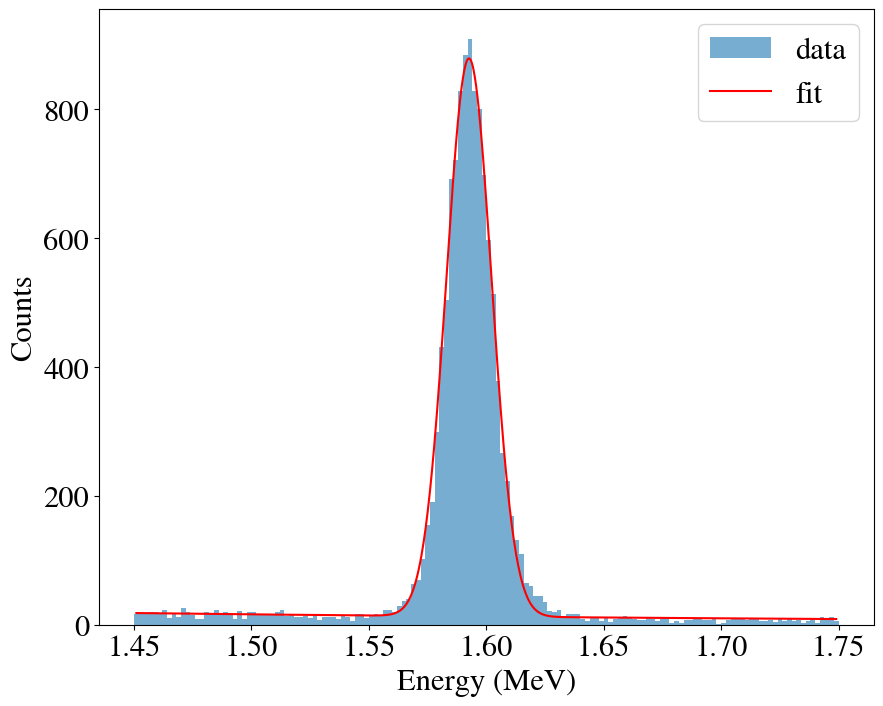

Signal events: 10412.434456770265
Background events: 2049.387946010611
Total Events by addition: 12461.822402780876
Total Events by row counting: 12459
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582]
fom_err: [0.01012695744331514, 0.01012807588

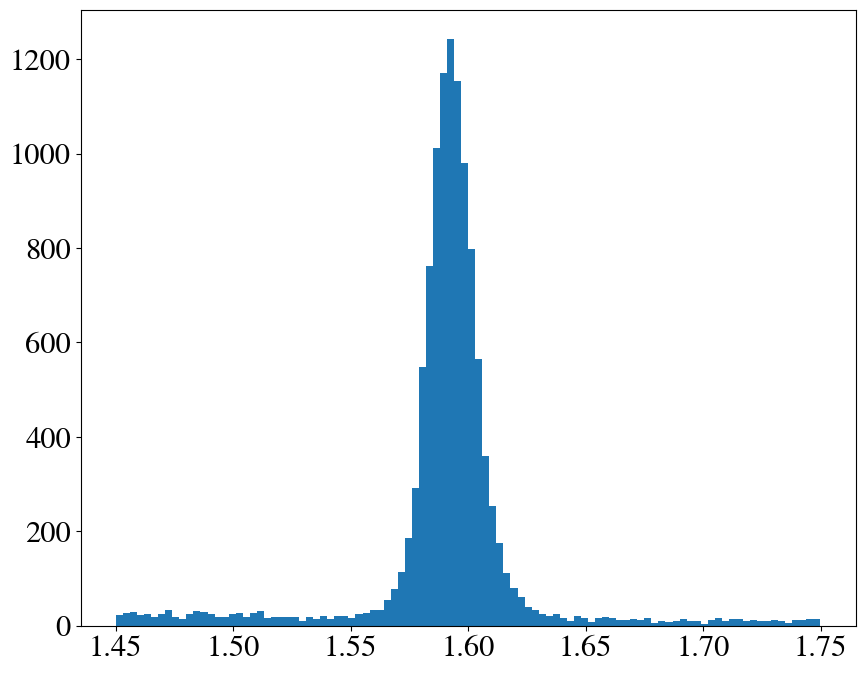

Optimized parameters (popt):
ns: 19.14616785782594
nb: 417.7318717333706
tau: 2.2220298584484683

Covariance matrix (pcov):
ns: [0.0097651  5.0077607  0.00929407]
nb: [5.00776070e+00 3.46656797e+05 5.28899180e+02]
tau: [9.29407144e-03 5.28899180e+02 8.09464373e-01]


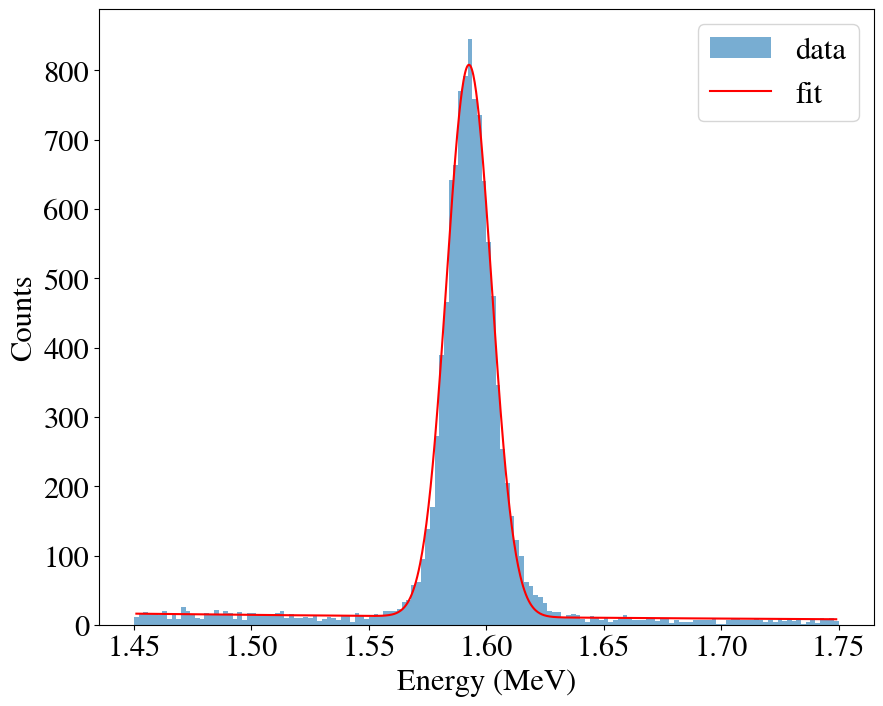

Signal events: 9575.699455608905
Background events: 1823.8658207561423
Total Events by addition: 11399.565276365047
Total Events by row counting: 11397
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188]
fom_err: [0.010126957443

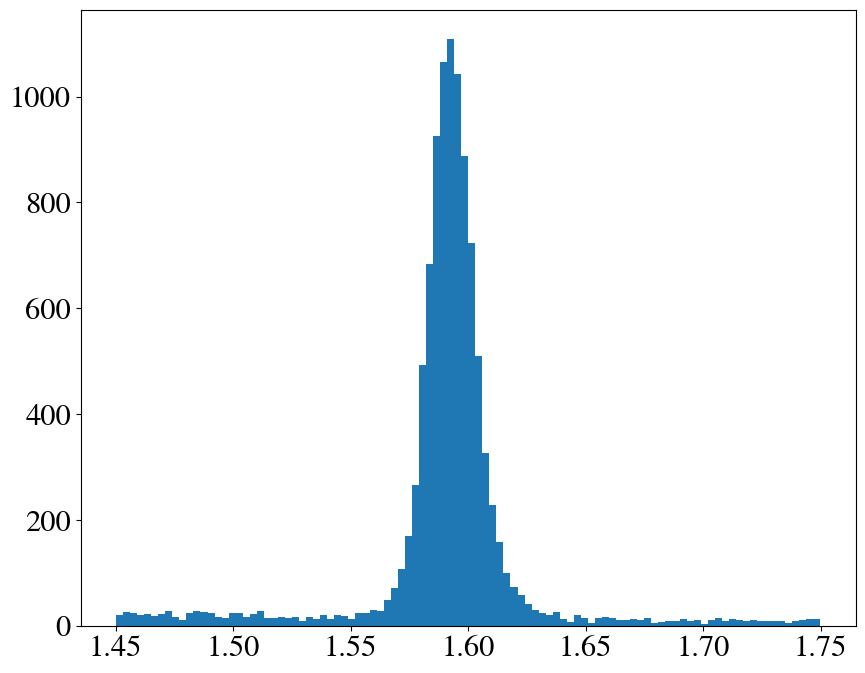

Optimized parameters (popt):
ns: 17.310451522202097
nb: 305.79477632483196
tau: 2.0903333794335595

Covariance matrix (pcov):
ns: [0.0082272  3.10670741 0.00801452]
nb: [3.10670741e+00 1.91900265e+05 3.99230367e+02]
tau: [8.01451500e-03 3.99230367e+02 8.33174726e-01]


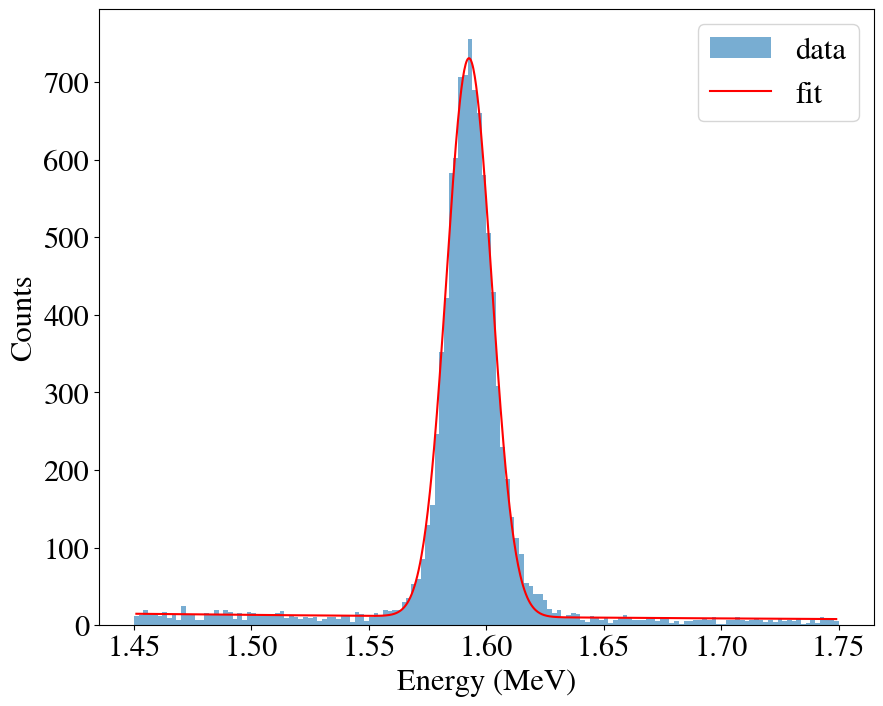

Signal events: 8657.590513588919
Background events: 1644.8190452619526
Total Events by addition: 10302.409558850872
Total Events by row counting: 10300
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388]
fom_

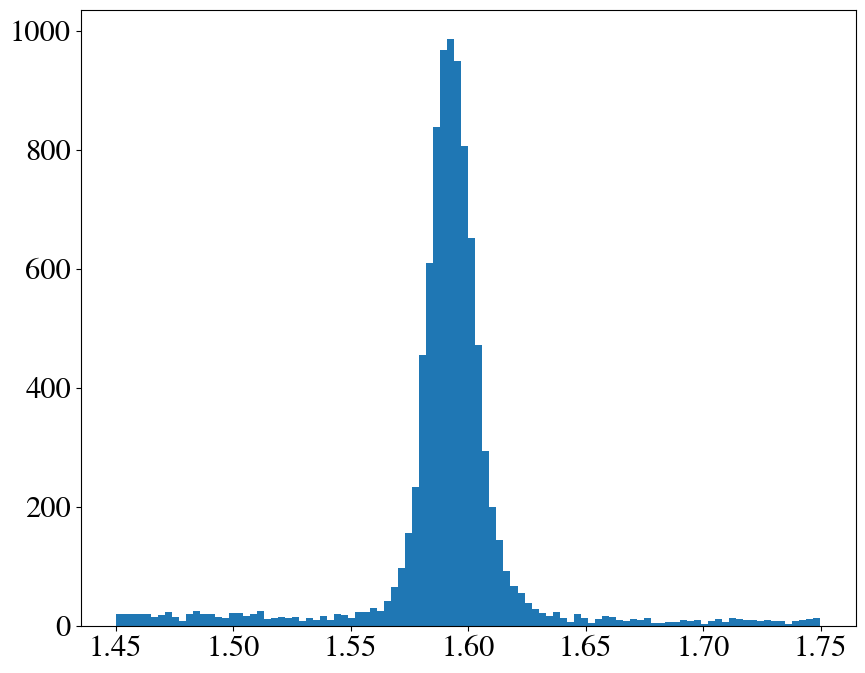

Optimized parameters (popt):
ns: 15.63605447878027
nb: 217.84067919218546
tau: 1.9476567778944802

Covariance matrix (pcov):
ns: [0.00683649 1.82553978 0.00677898]
nb: [1.82553978e+00 1.00823328e+05 2.94370057e+02]
tau: [6.77897913e-03 2.94370057e+02 8.62191588e-01]


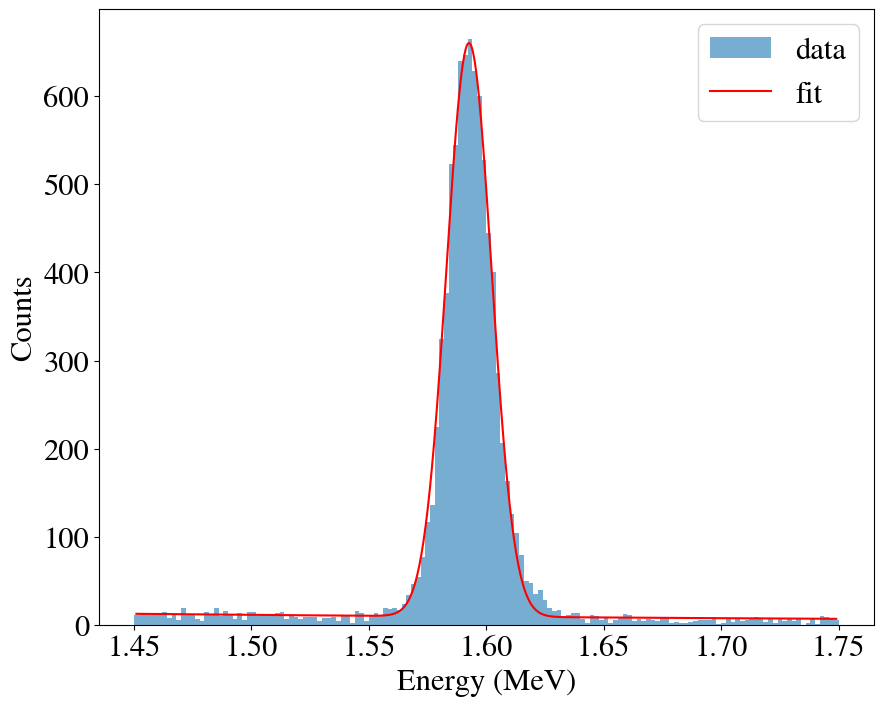

Signal events: 7820.163255234769
Background events: 1469.0461916701865
Total Events by addition: 9289.209446904955
Total Events by row counting: 9287
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.4631

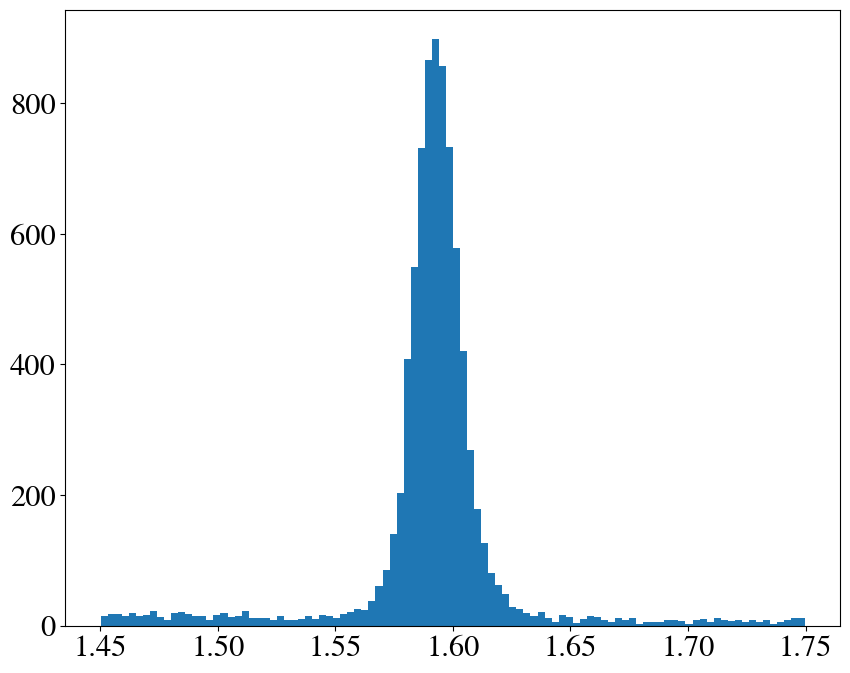

Optimized parameters (popt):
ns: 14.048077581224183
nb: 189.82321852068083
tau: 1.9393885815403418

Covariance matrix (pcov):
ns: [0.0057601  1.50720089 0.00643233]
nb: [1.50720089e+00 8.27472257e+04 2.77208261e+02]
tau: [6.43233462e-03 2.77208261e+02 9.31616461e-01]


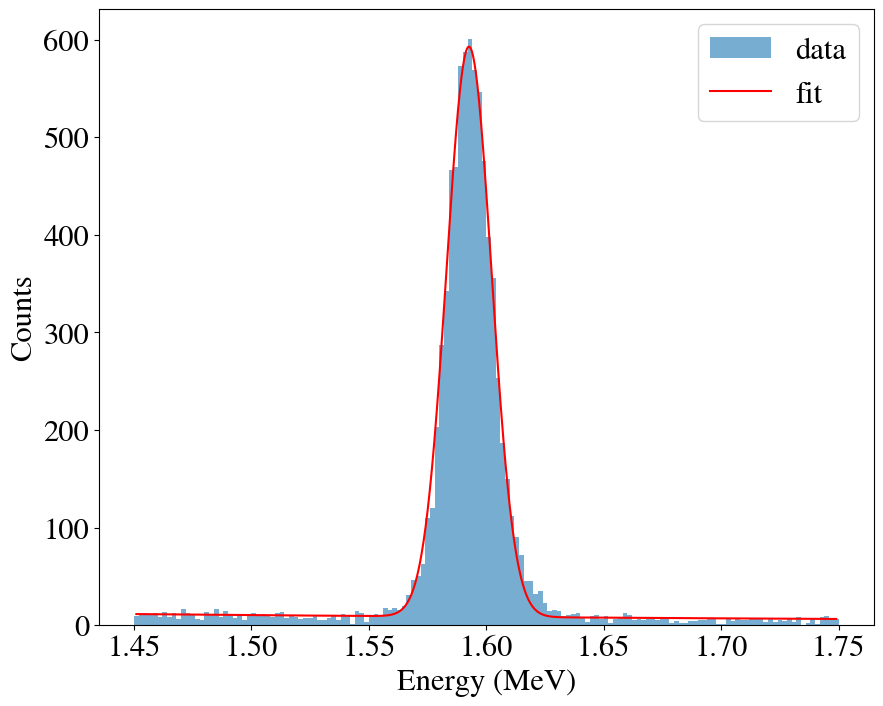

Signal events: 7025.957875528357
Background events: 1296.9971891518544
Total Events by addition: 8322.955064680213
Total Events by row counting: 8321
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.4631

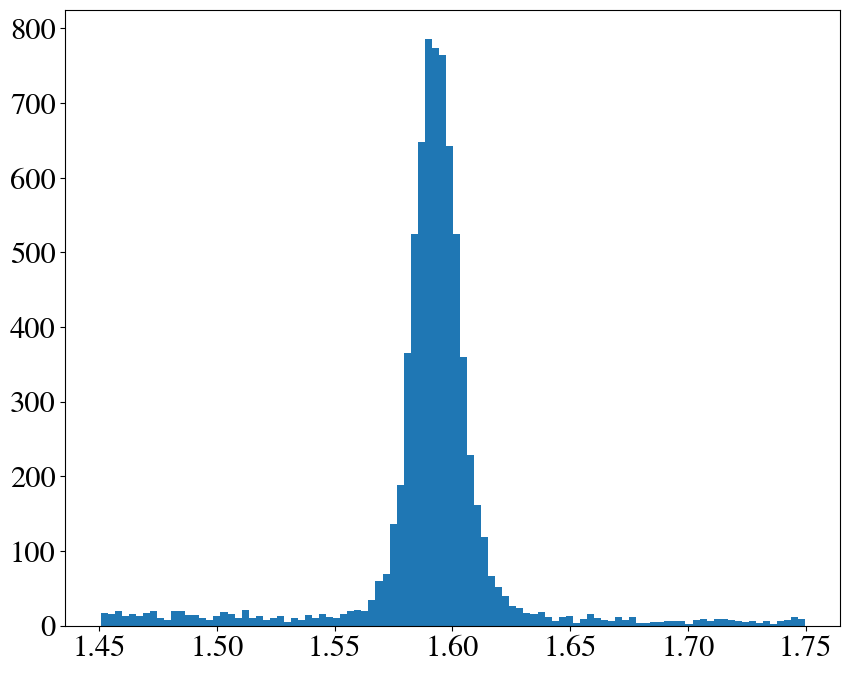

Optimized parameters (popt):
ns: 12.53584483145649
nb: 175.18805462355573
tau: 1.9548134130776829

Covariance matrix (pcov):
ns: [0.00480397 1.30549488 0.00602056]
nb: [1.30549488e+00 7.24775531e+04 2.63164830e+02]
tau: [6.02056220e-03 2.63164830e+02 9.58581627e-01]


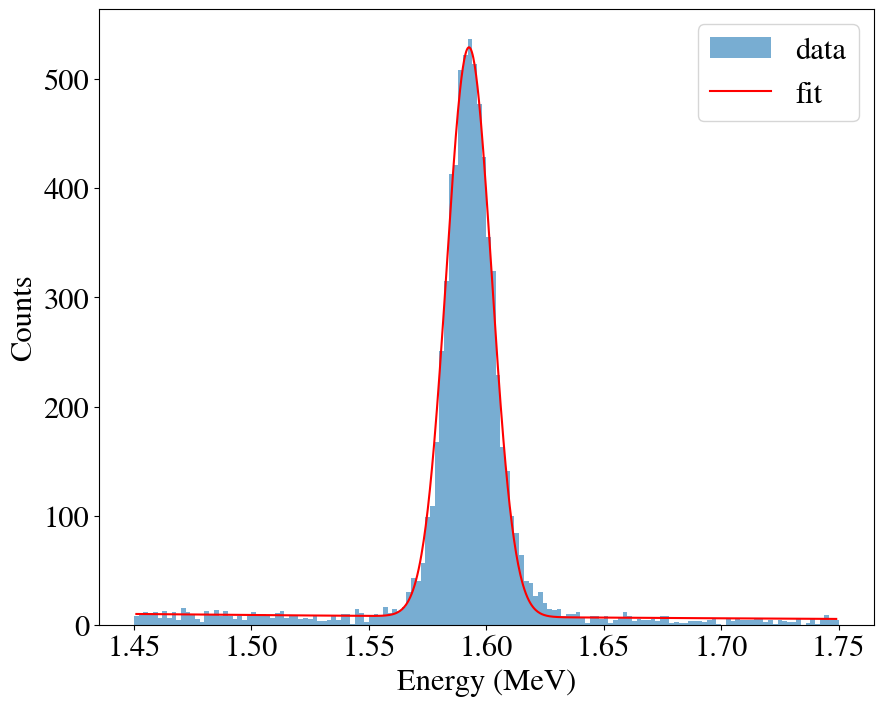

Signal events: 6269.634917000366
Background events: 1168.081890579376
Total Events by addition: 7437.716807579742
Total Events by row counting: 7436
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.46316

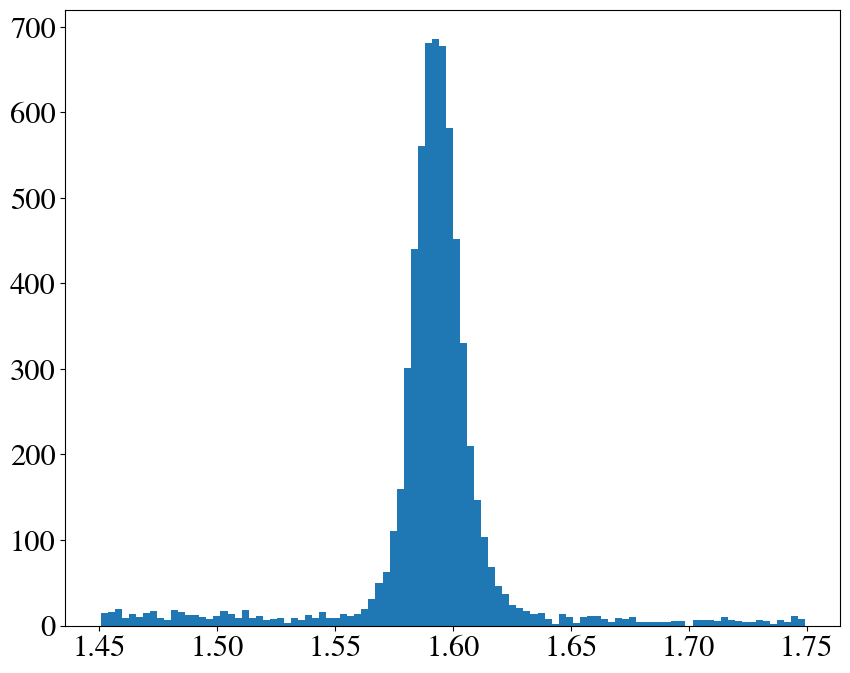

Optimized parameters (popt):
ns: 10.988093217322781
nb: 144.51700865720397
tau: 1.9209271967613548

Covariance matrix (pcov):
ns: [0.00431159 1.07817037 0.00606322]
nb: [1.07817037e+00 5.84259526e+04 2.56967307e+02]
tau: [6.06322263e-03 2.56967307e+02 1.13378256e+00]


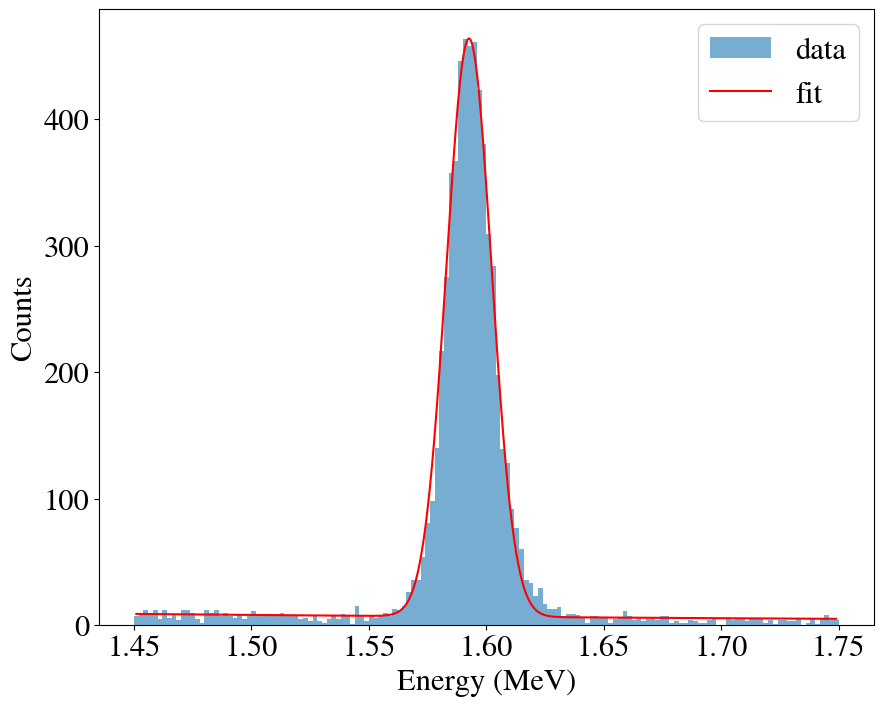

Signal events: 5495.5476741153625
Background events: 1016.76693195137
Total Events by addition: 6512.314606066732
Total Events by row counting: 6511
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.46316

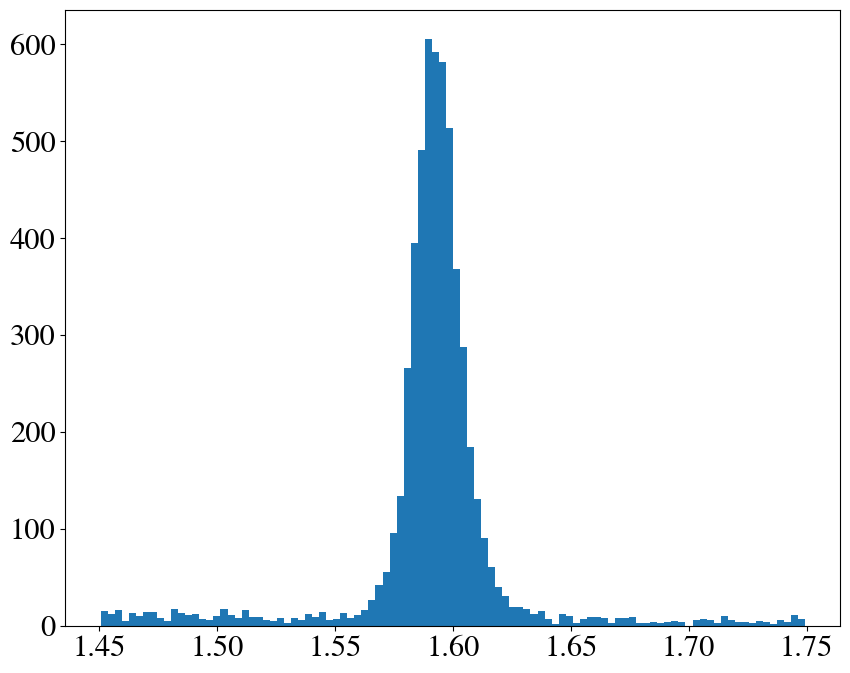

Optimized parameters (popt):
ns: 9.553491530629811
nb: 120.8222177405145
tau: 1.8955759116616582

Covariance matrix (pcov):
ns: [0.00418018 0.98142502 0.00663347]
nb: [9.81425020e-01 5.22570682e+04 2.74789280e+02]
tau: [6.63346641e-03 2.74789280e+02 1.44956101e+00]


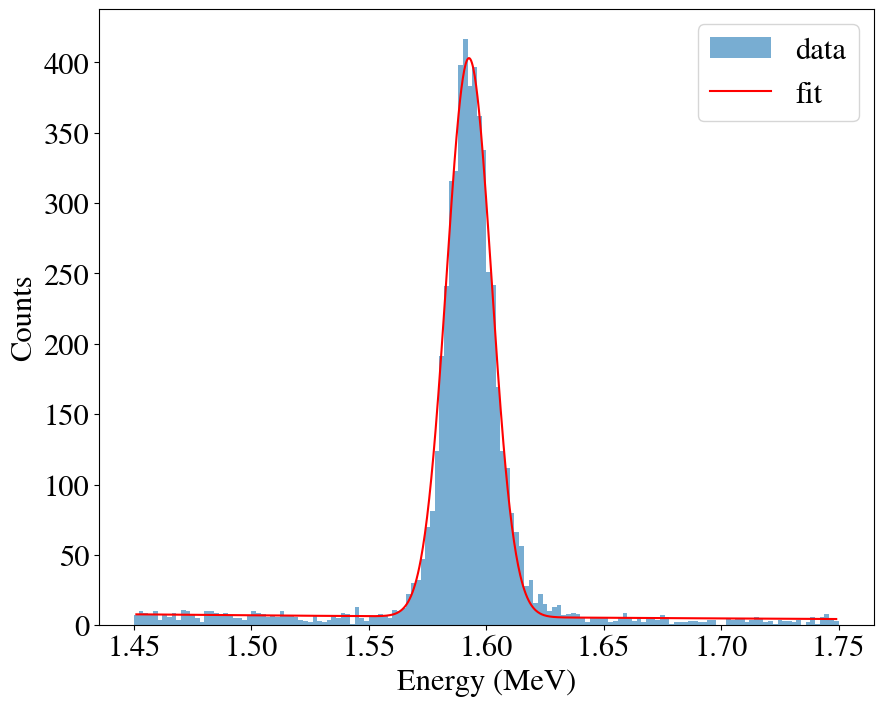

Signal events: 4778.050852177368
Background events: 884.9286443690954
Total Events by addition: 5662.979496546463
Total Events by row counting: 5662
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.46316

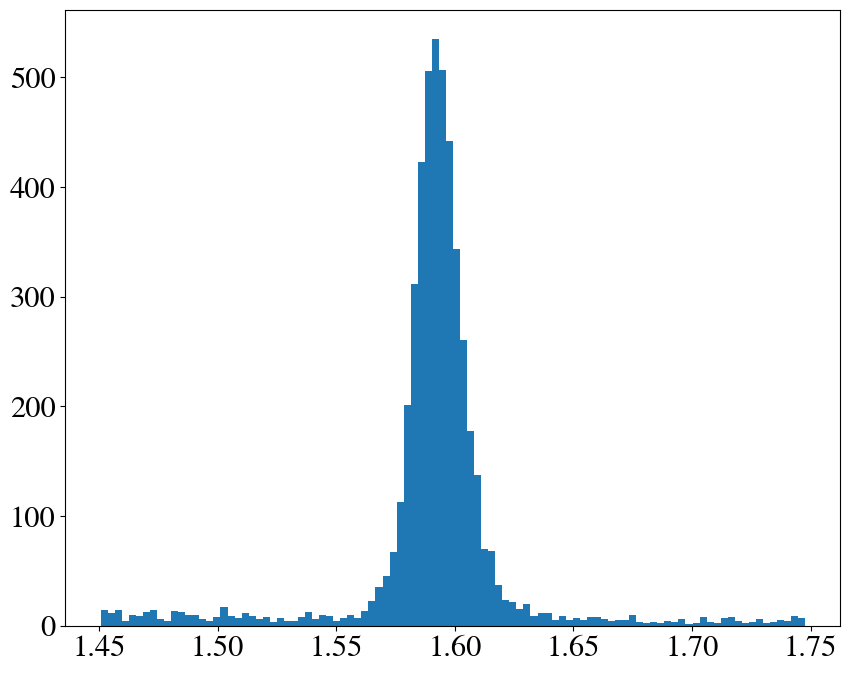

Optimized parameters (popt):
ns: 8.320124888738212
nb: 127.05977289277915
tau: 2.0261089455604266

Covariance matrix (pcov):
ns: [0.00342814 1.10767555 0.00695823]
nb: [1.10767555e+00 6.49080850e+04 3.25259150e+02]
tau: [6.95823163e-03 3.25259150e+02 1.63504923e+00]


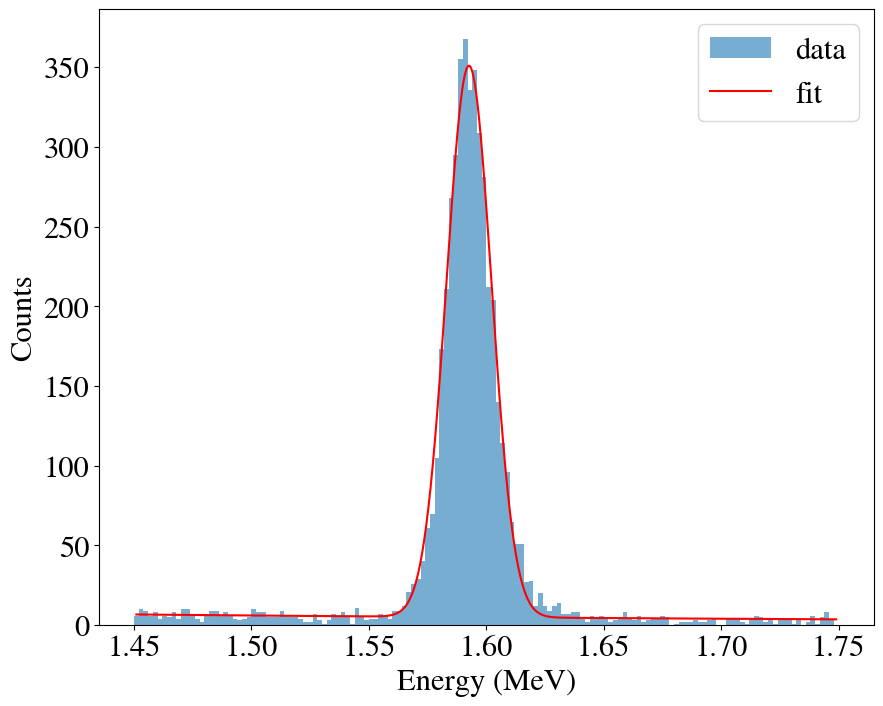

Signal events: 4161.199043030602
Background events: 756.650998268098
Total Events by addition: 4917.8500412987005
Total Events by row counting: 4917
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.46316

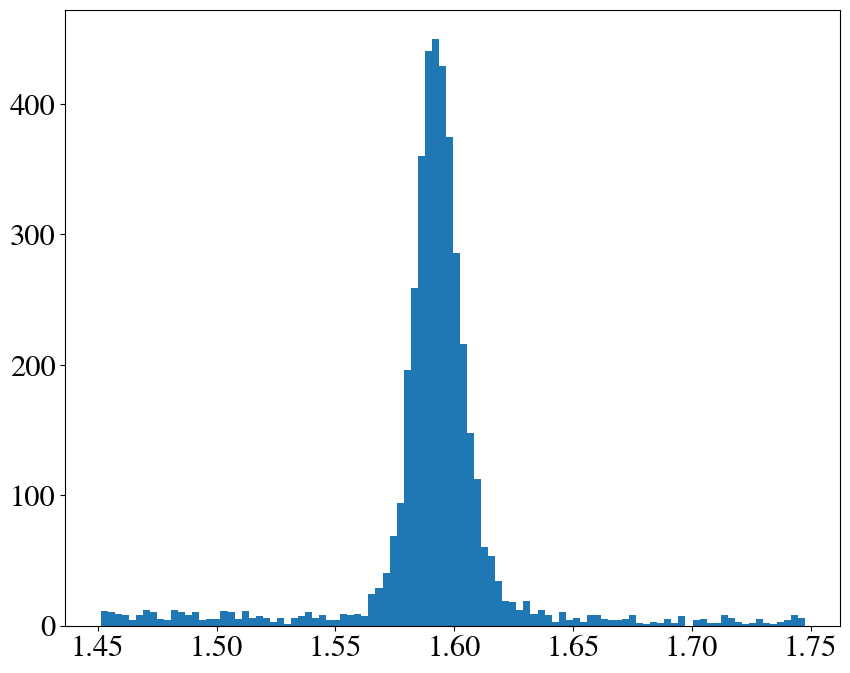

Optimized parameters (popt):
ns: 7.085038018086526
nb: 71.33511880284358
tau: 1.7479483612026934

Covariance matrix (pcov):
ns: [0.00274048 0.44020326 0.00520986]
nb: [4.40203260e-01 2.14110182e+04 1.90265816e+02]
tau: [5.20985806e-03 1.90265816e+02 1.69620353e+00]


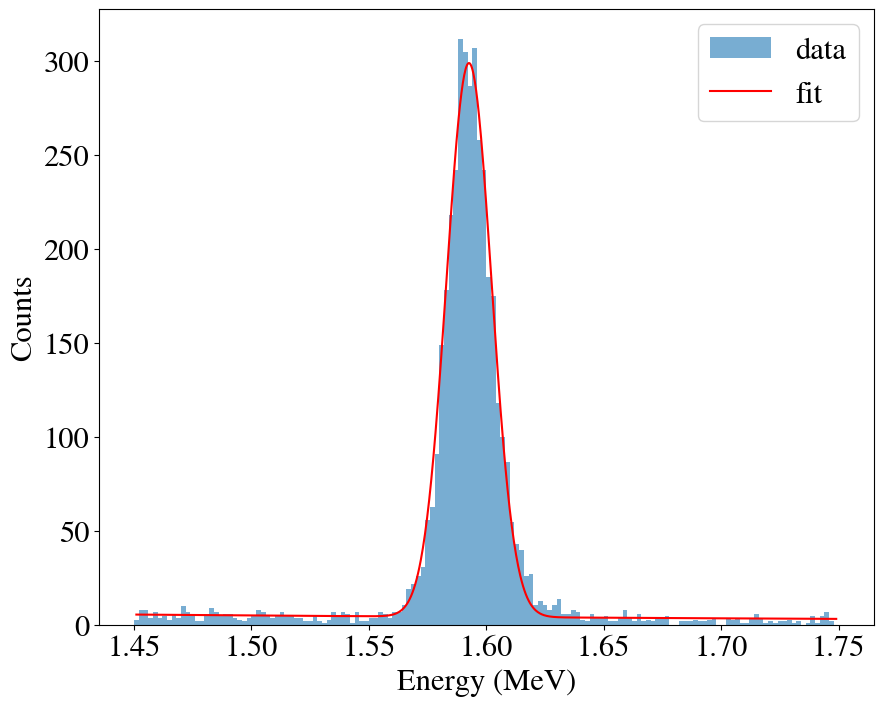

Signal events: 3543.4868845061565
Background events: 660.350270499978
Total Events by addition: 4203.837155006135
Total Events by row counting: 4203
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.46316

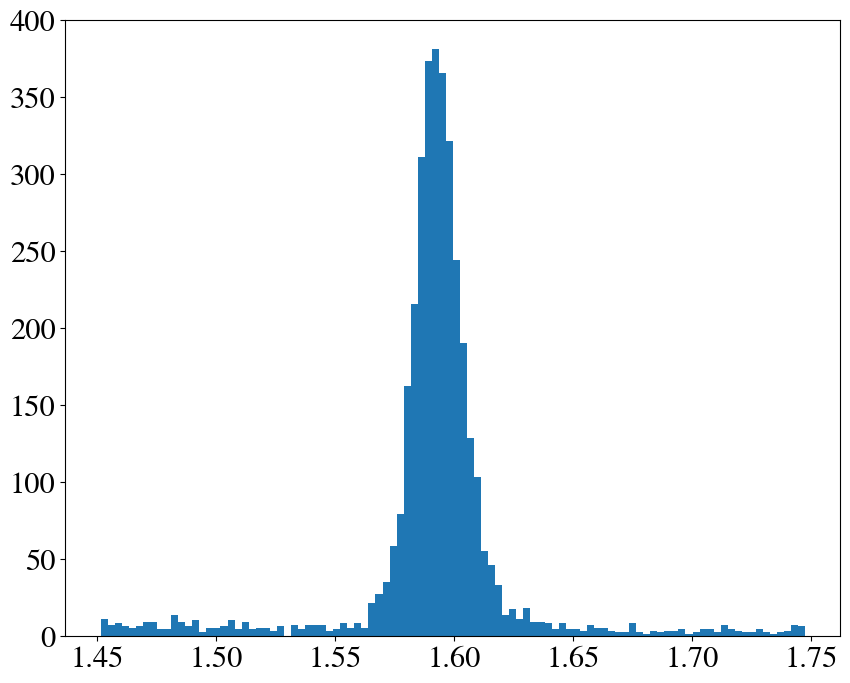

Optimized parameters (popt):
ns: 6.035257162435598
nb: 45.56698685428443
tau: 1.5482117228143026

Covariance matrix (pcov):
ns: [0.0023944  0.22053438 0.00435806]
nb: [2.20534380e-01 9.89738599e+03 1.37353029e+02]
tau: [4.35806195e-03 1.37353029e+02 1.91233372e+00]


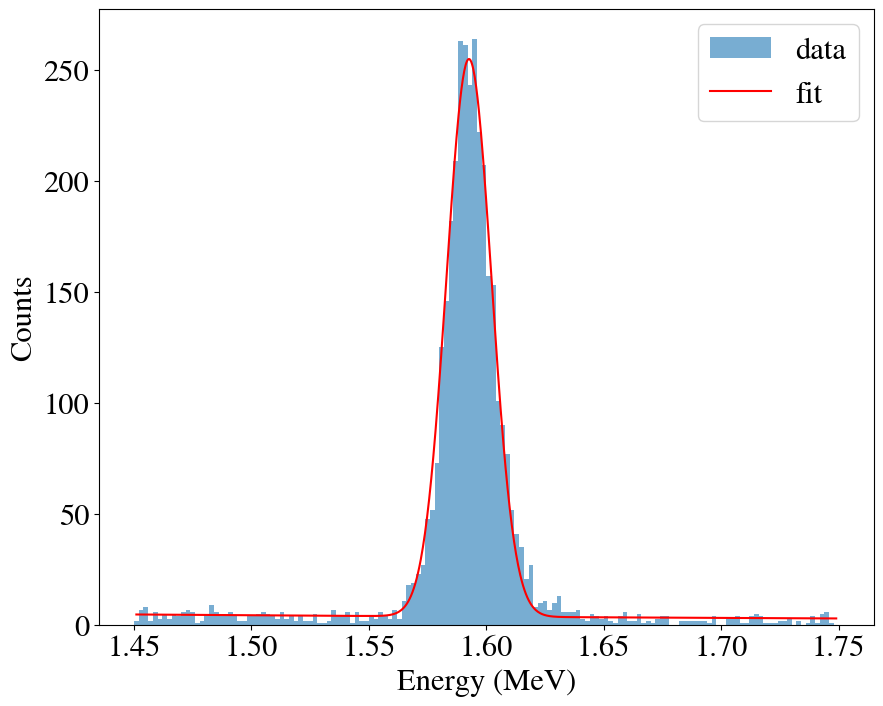

Signal events: 3018.453047833908
Background events: 579.2196973844847
Total Events by addition: 3597.6727452183927
Total Events by row counting: 3597
FOM: [1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.6079422137338188, 1.5308560338602388, 1.4631

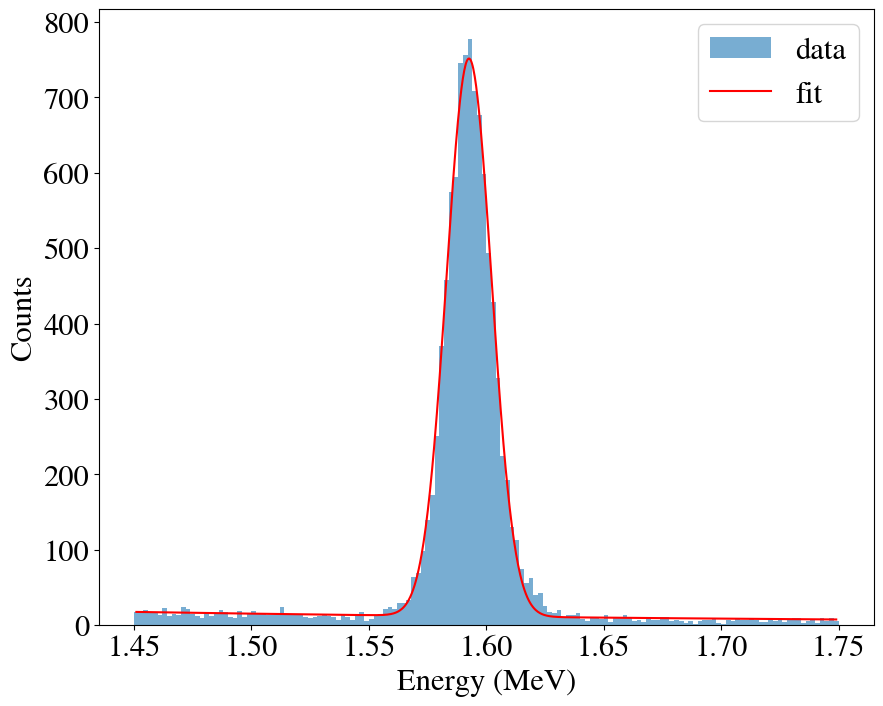

Signal events: 8898.158983506175
Background events: 1785.7385258806924
Total Events by addition: 10683.897509386867
Total Events by row counting: 10680
FOM LINEAR REG: 1.510037037082645
FOM:
[1.0, 1.0000925703419226, 0.9996414557226576, 0.9991644646214515, 0.999372038456345, 1.0014325924565515, 1.0053753576525675, 1.0138326555079669, 1.0263442200660136, 1.0454439853480177, 1.07110927273317, 1.1027370864781392, 1.144991739114428, 1.1949147794158828, 1.2536411534635976, 1.3130198070568981, 1.377187565339858, 1.4402208561711345, 1.5038785263892962, 1.5564487551862127, 1.6065545902696985, 1.6601916518327606, 1.704789968981428, 1.7436658391916773, 1.7829196531057379, 1.8234505950911684, 1.8513944598283163, 1.8757330555519676, 1.8885837354362343, 1.9027921528496916, 1.9102342729464328, 1.9045725645517337, 1.9046121411823245, 1.9004820068920871, 1.8829083386903538, 1.8574325210560008, 1.8303252383529394, 1.7964402206915533, 1.731873146045504, 1.7042726376975799, 1.6494401604608582, 1.60794221

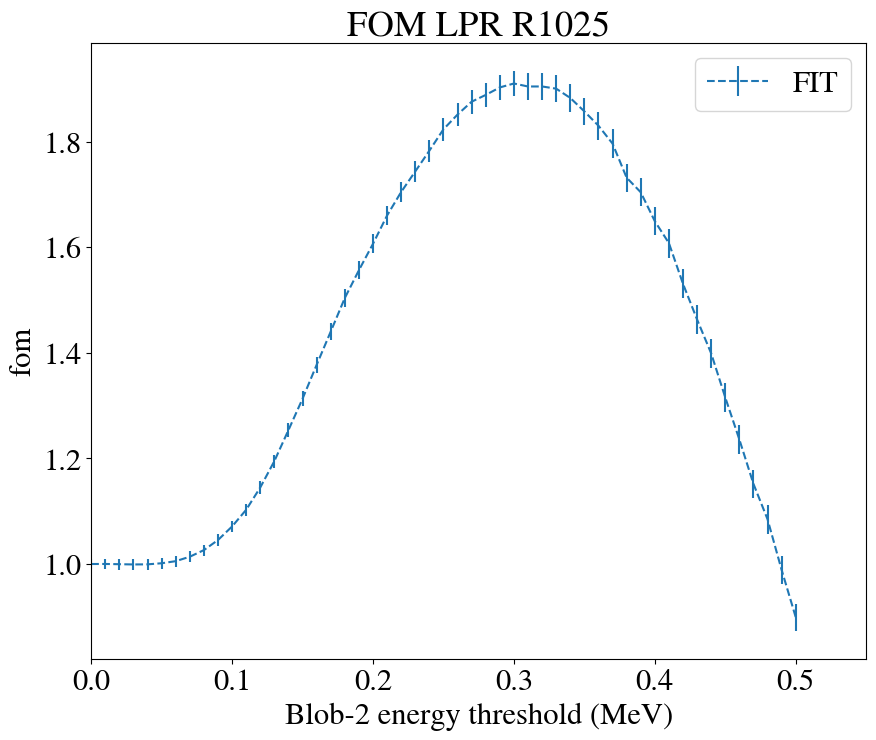

DISTRIBUTIONS AT CUT 0.3


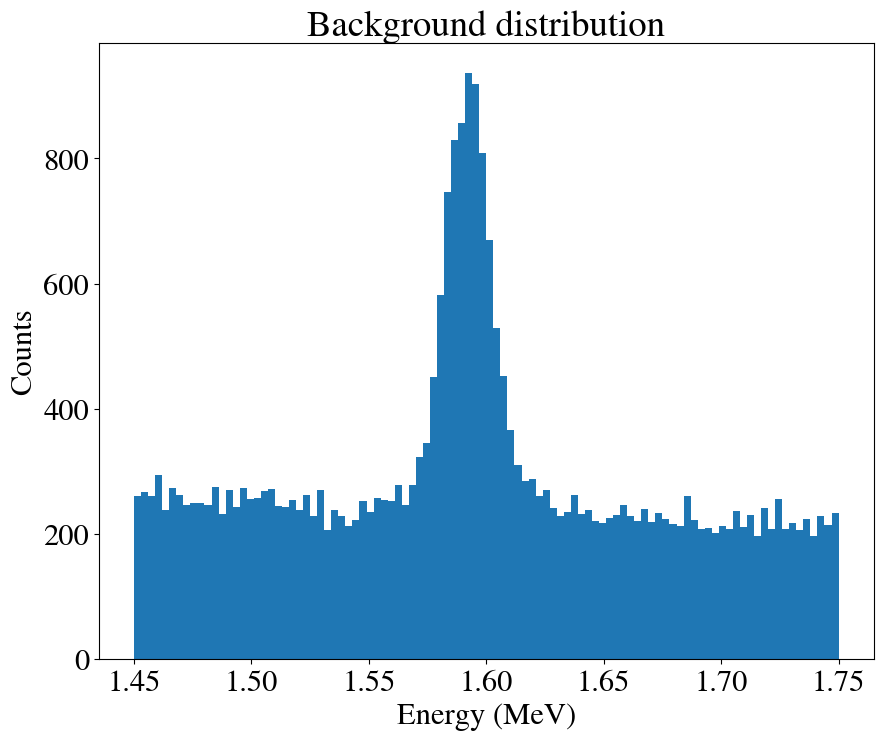

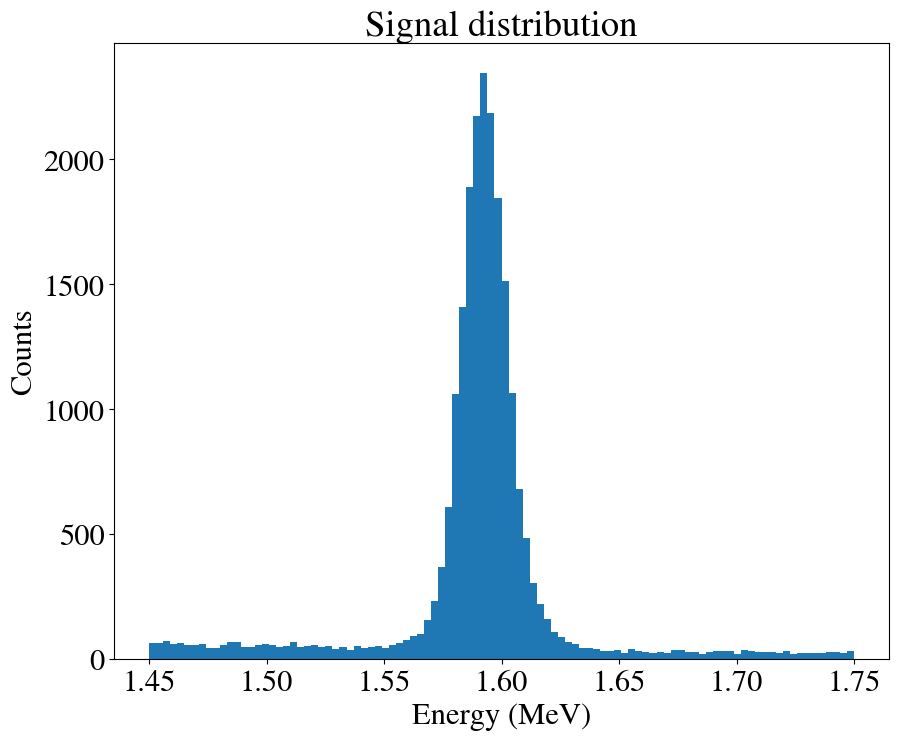

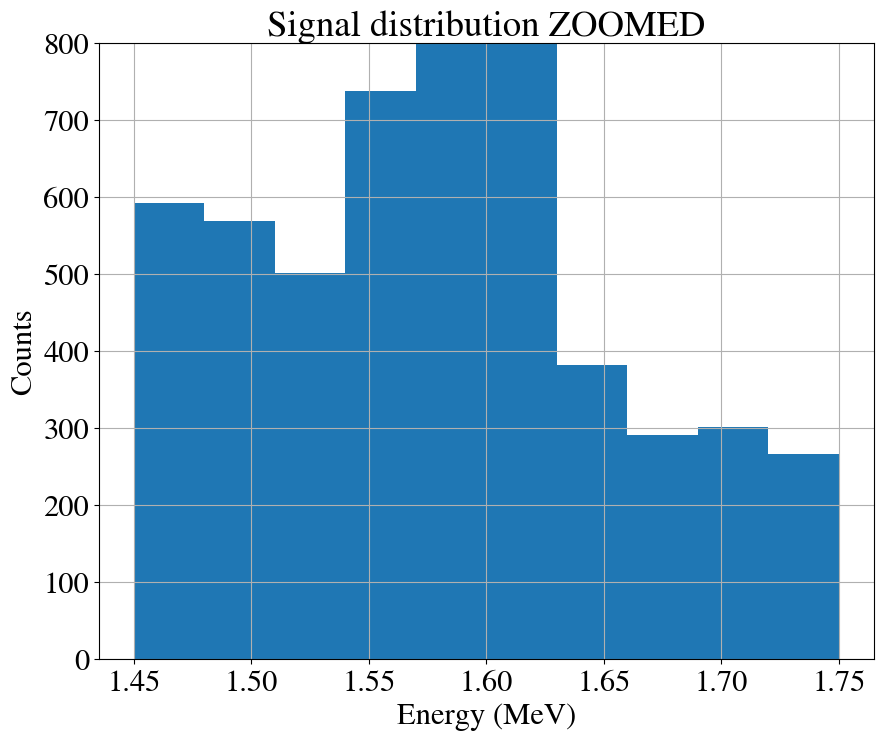

In [2]:
#RUN_NUMBER = '15589, 15590, 15591, 15592, 15593, 15594, 15596, 15597'
RUN_NUMBER = '15589, 15590, 15591, 15592'
#RUN_NUMBER = '15589, 15590, 15591, 15592, 15593'
#RUN_NUMBER = '250925'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
#TIMESTAMP  = '110725, 120725, 130725, 140725, 150725, 160725, 170725, 180725'
#TIMESTAMP  = [int(x) for x in TIMESTAMP.split(',')]
#TIMESTAMP = ['253015'] * len(RUN_NUMBER)
#TIMESTAMP = ['253015', '254015', '255015', '256015', '354015', '355015', '356015', '455015', '456015']

### TIMESTAMP IS ALWAYS blobR scanR voxelS
#TIMESTAMP = ['456018']
#CITY       = 'thekla'
TIMESTAMP = ['1025']
#CITY      = 'beersheba'
CITY       = 'isaura'
#FOM_TS     = '253015'

    

# automate here for each FOM_TS

for TS in TIMESTAMP:
    true_TS = [TS] * len(RUN_NUMBER)
    print('=' * 20)
    print('=' * 20)
    print('\n' * 5)
    print(f'TIMESTAMP: {TS}')
    print('\n' * 5)
    print('=' * 20)
    print('=' * 20)
    main(RUN_NUMBER, true_TS, CITY, true_TS)

In [4]:
# plot the two distributions at the cut line 0.36 MeV for Blob-2 energy threshold.



In [5]:
print('Done!')

Done!


R15589: 456018
Loaded!
R15590: 456018
Loaded!
R15591: 456018
Loaded!


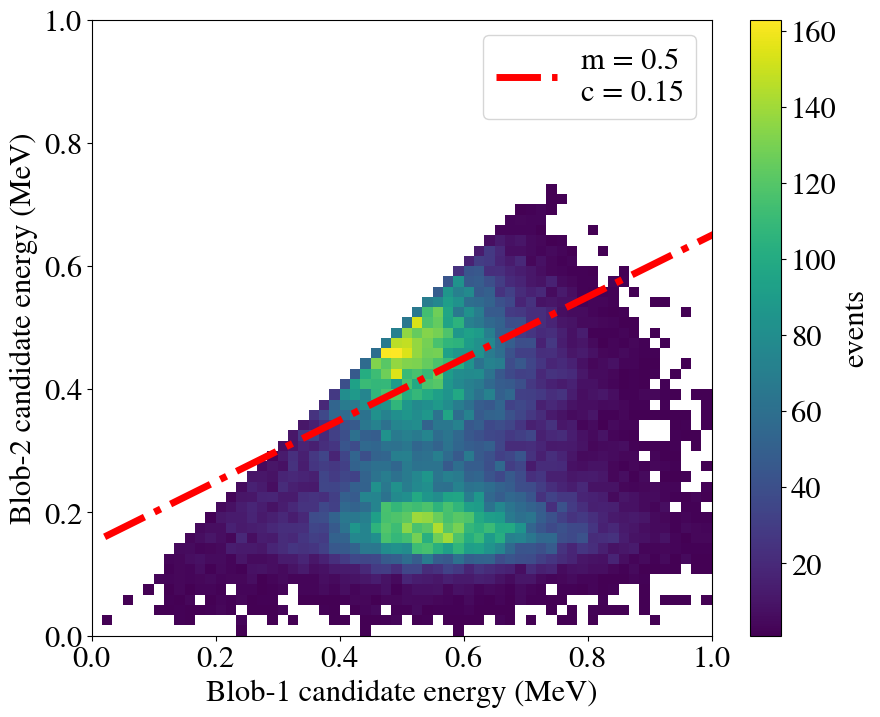

In [18]:
RUN_NUMBER = '15589, 15590, 15591'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
TIMESTAMP = ['456018']
TIMESTAMP  = TIMESTAMP * len(RUN_NUMBER)

# load
hdst_local = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    print(f'R{RN}: {TS}', flush = True)
    n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'
    hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
    print(f'Loaded!', flush = True)
hdst = pd.concat(hdst_local)


# the cut you'd apply across these values
m = 0.5
c = 0.15
x = np.linspace(hdst['eblob1'].min(), hdst['eblob1'].max(), 1000)
y = m*x + c

# Define the paraboloid equation
#a, b, c = 7, -7, 2.1  # Example coefficients for the paraboloid
#y = a * x**2 + b * x + c

# blob 2dhist
#plt.figure(figsize=(12,8))
plt.hist2d(hdst['eblob1'], hdst['eblob2'], bins=(60, 60), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
#plt.plot(x,y, c = 'red', linewidth = 5, linestyle = '-.', label = f'a = {a}\nb = {b}\nc = {c}')
plt.plot(x,y, c = 'red', linewidth = 5, linestyle = '-.', label = f'm = {m}\nc = {c}')
plt.legend()
#plt.title(f'{blob_2dhits_title}')
plt.show()